In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tqdm import tqdm

In [4]:
import cv2
from PIL import Image
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import time
import datetime

In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import albumentations as A
import os

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
torch.cuda.is_available()

False

In [8]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [9]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history['accuracy']
    y2 = history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history['loss']
    y2 = history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [10]:
cur_path = os.path.join(os.getcwd(), 'gtsrb')
cur_path

'C:\\Users\\User\\pythons\\dorognie_znaki\\gtsrb'

In [11]:
path_train = os.path.join(cur_path,'Train.csv')
path_test = os.path.join(cur_path,'Test.csv')

In [12]:
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

In [13]:
test_df.describe()

Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  12630.000000  12630.000000  12630.000000  12630.000000  12630.000000   
mean      50.507759     50.364450      5.998021      5.982423     44.864450   
std       25.088483     23.698908      1.543954      1.427424     23.776102   
min       25.000000     25.000000      1.000000      5.000000     20.000000   
25%       34.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     57.000000      6.000000      6.000000     53.000000   
max      266.000000    232.000000     23.000000     19.000000    244.000000   

             Roi.Y2       ClassId  
count  12630.000000  12630.000000  
mean      44.758116     15.551069  
std       22.494697     11.947123  
min       20.000000      0.000000  
25%       29.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  
max      212.000000     42.000000

In [14]:
train_df.describe()

Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     58.000000      6.000000      6.000000     53.000000   
max      243.000000    225.000000     20.000000     20.000000    223.000000   

             Roi.Y2       ClassId  
count  39209.000000  39209.000000  
mean      44.728379     15.788390  
std       21.971145     12.013238  
min       20.000000      0.000000  
25%       30.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  
max      205.000000     42.000000

In [16]:
meta_df = pd.read_csv(os.path.join(cur_path,'Meta.csv'))
meta_df.head()

Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22

In [17]:
classes = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry',
    18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians',
    28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only',
    36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
    41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'
}

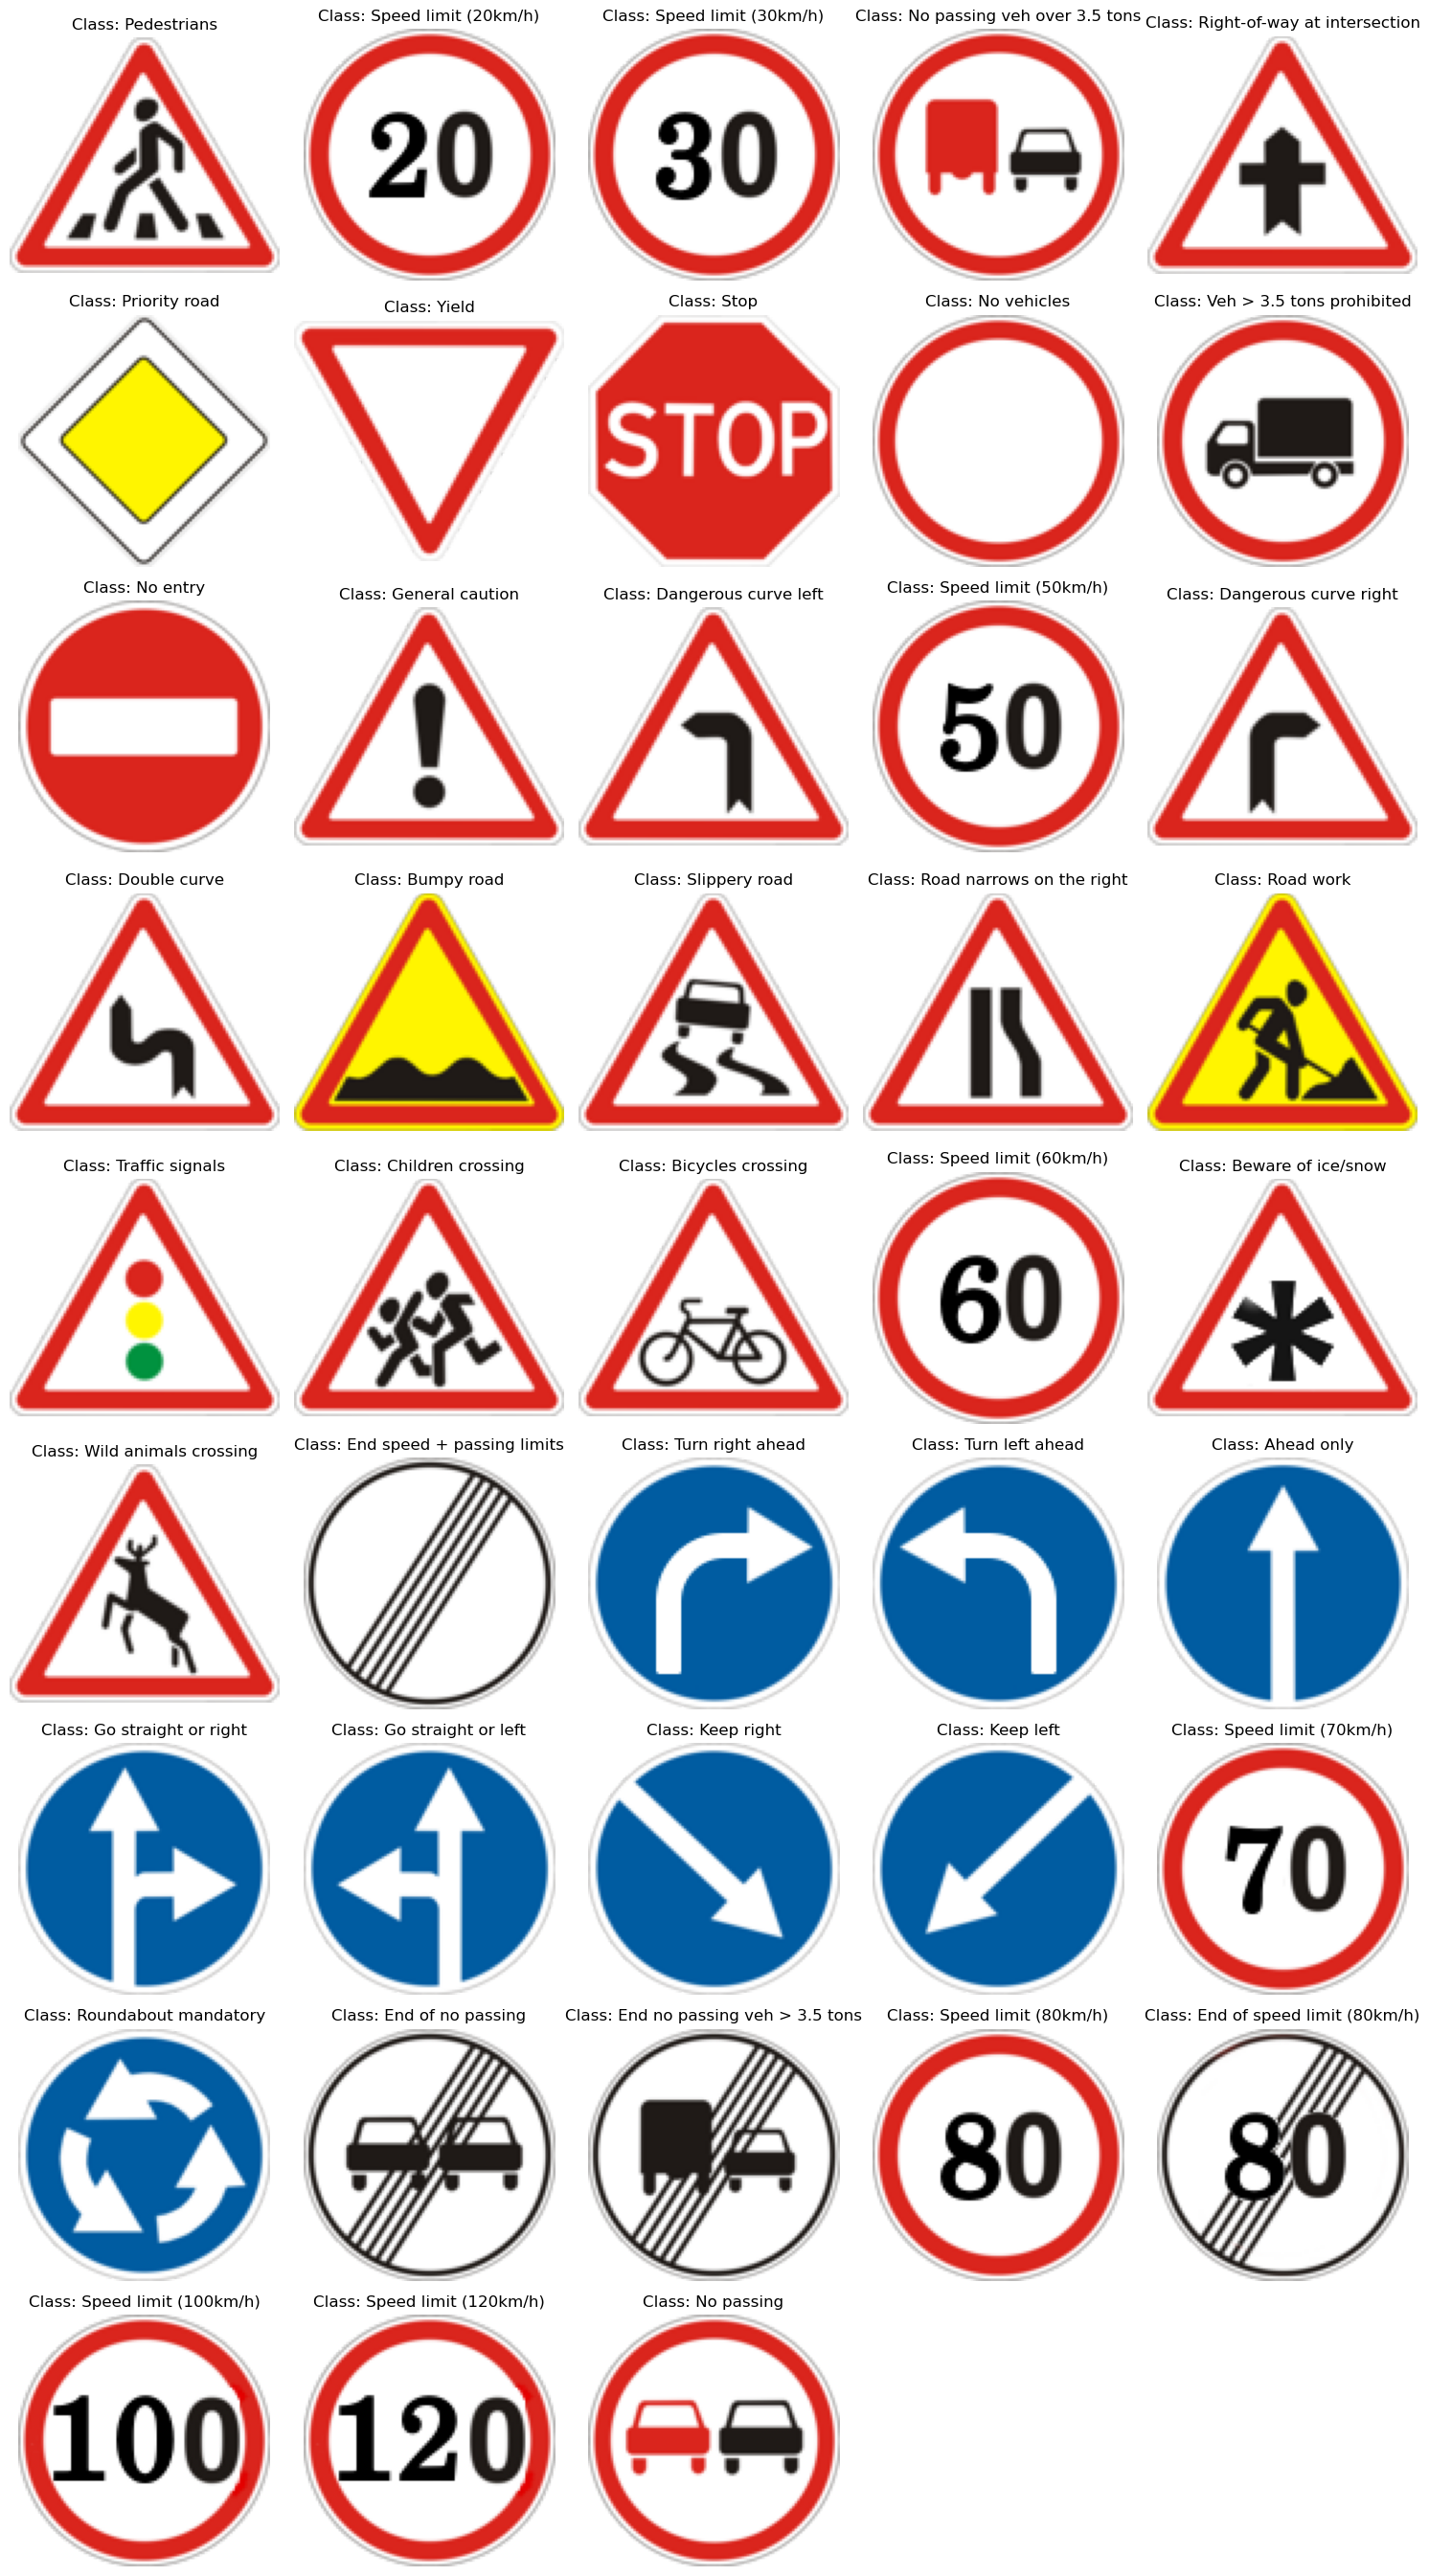

In [18]:
images_per_row = 5
total_images = len(meta_df)
rows = (total_images // images_per_row) + (total_images % images_per_row > 0)

fig, axs = plt.subplots(rows, images_per_row, figsize=(15, rows * 3))
axs = axs.flatten()

for idx, (_, row) in enumerate(meta_df.iterrows()):
    img_path = os.path.join(cur_path, row['Path'])
    class_id = row['ClassId']
    class_name = classes.get(class_id, "Unknown")

    img = Image.open(img_path)

    axs[idx].imshow(img)
    axs[idx].set_title(f"Class: {class_name}")
    axs[idx].axis('off')

for i in range(idx + 1, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()


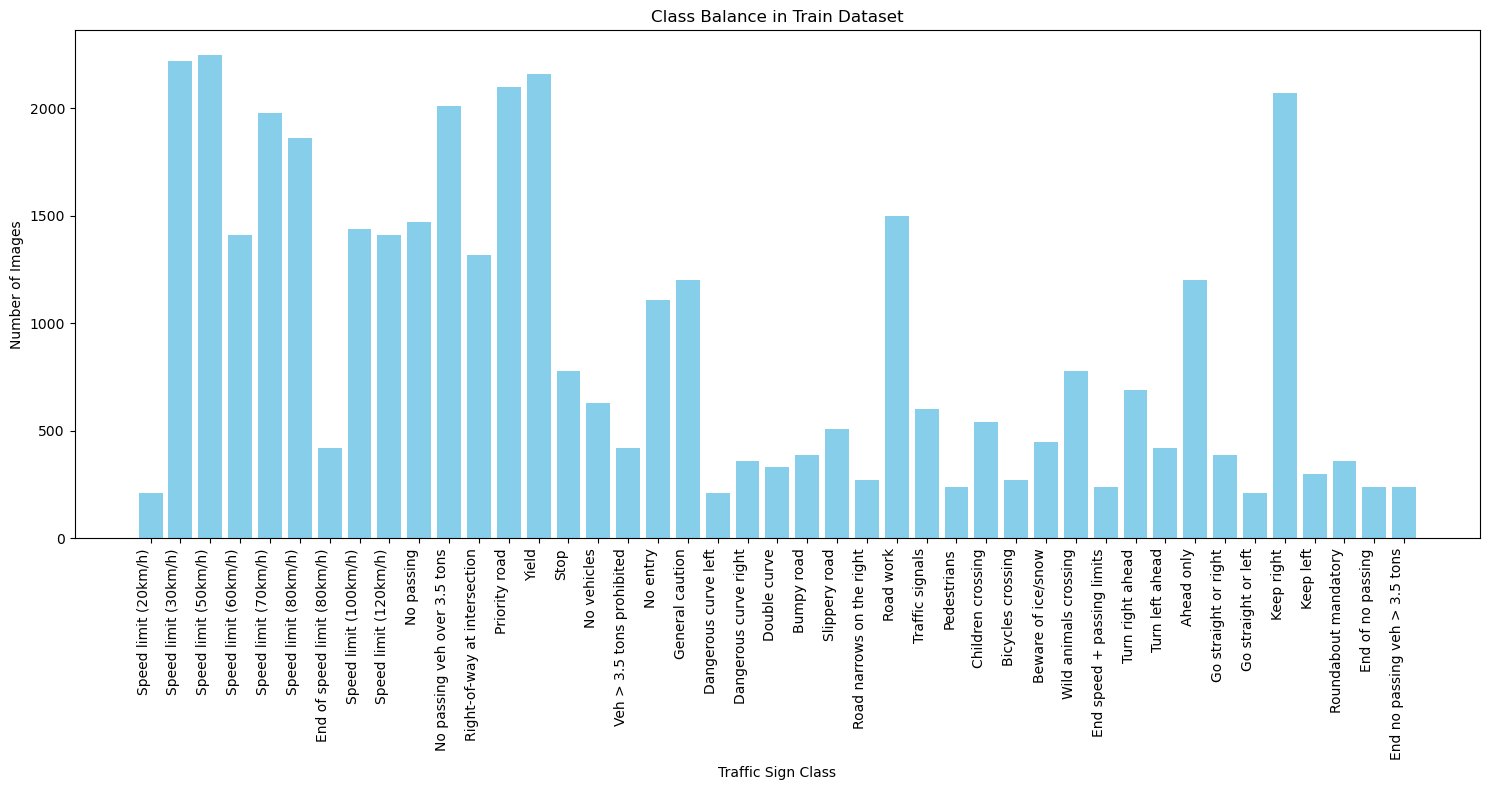

In [19]:
class_counts = train_df['ClassId'].value_counts().sort_index()
class_labels = [classes[i] for i in class_counts.index]

plt.figure(figsize=(15, 8))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Traffic Sign Class')
plt.ylabel('Number of Images')
plt.title('Class Balance in Train Dataset')
plt.tight_layout()
plt.show() #вывод => они не сбалансированы

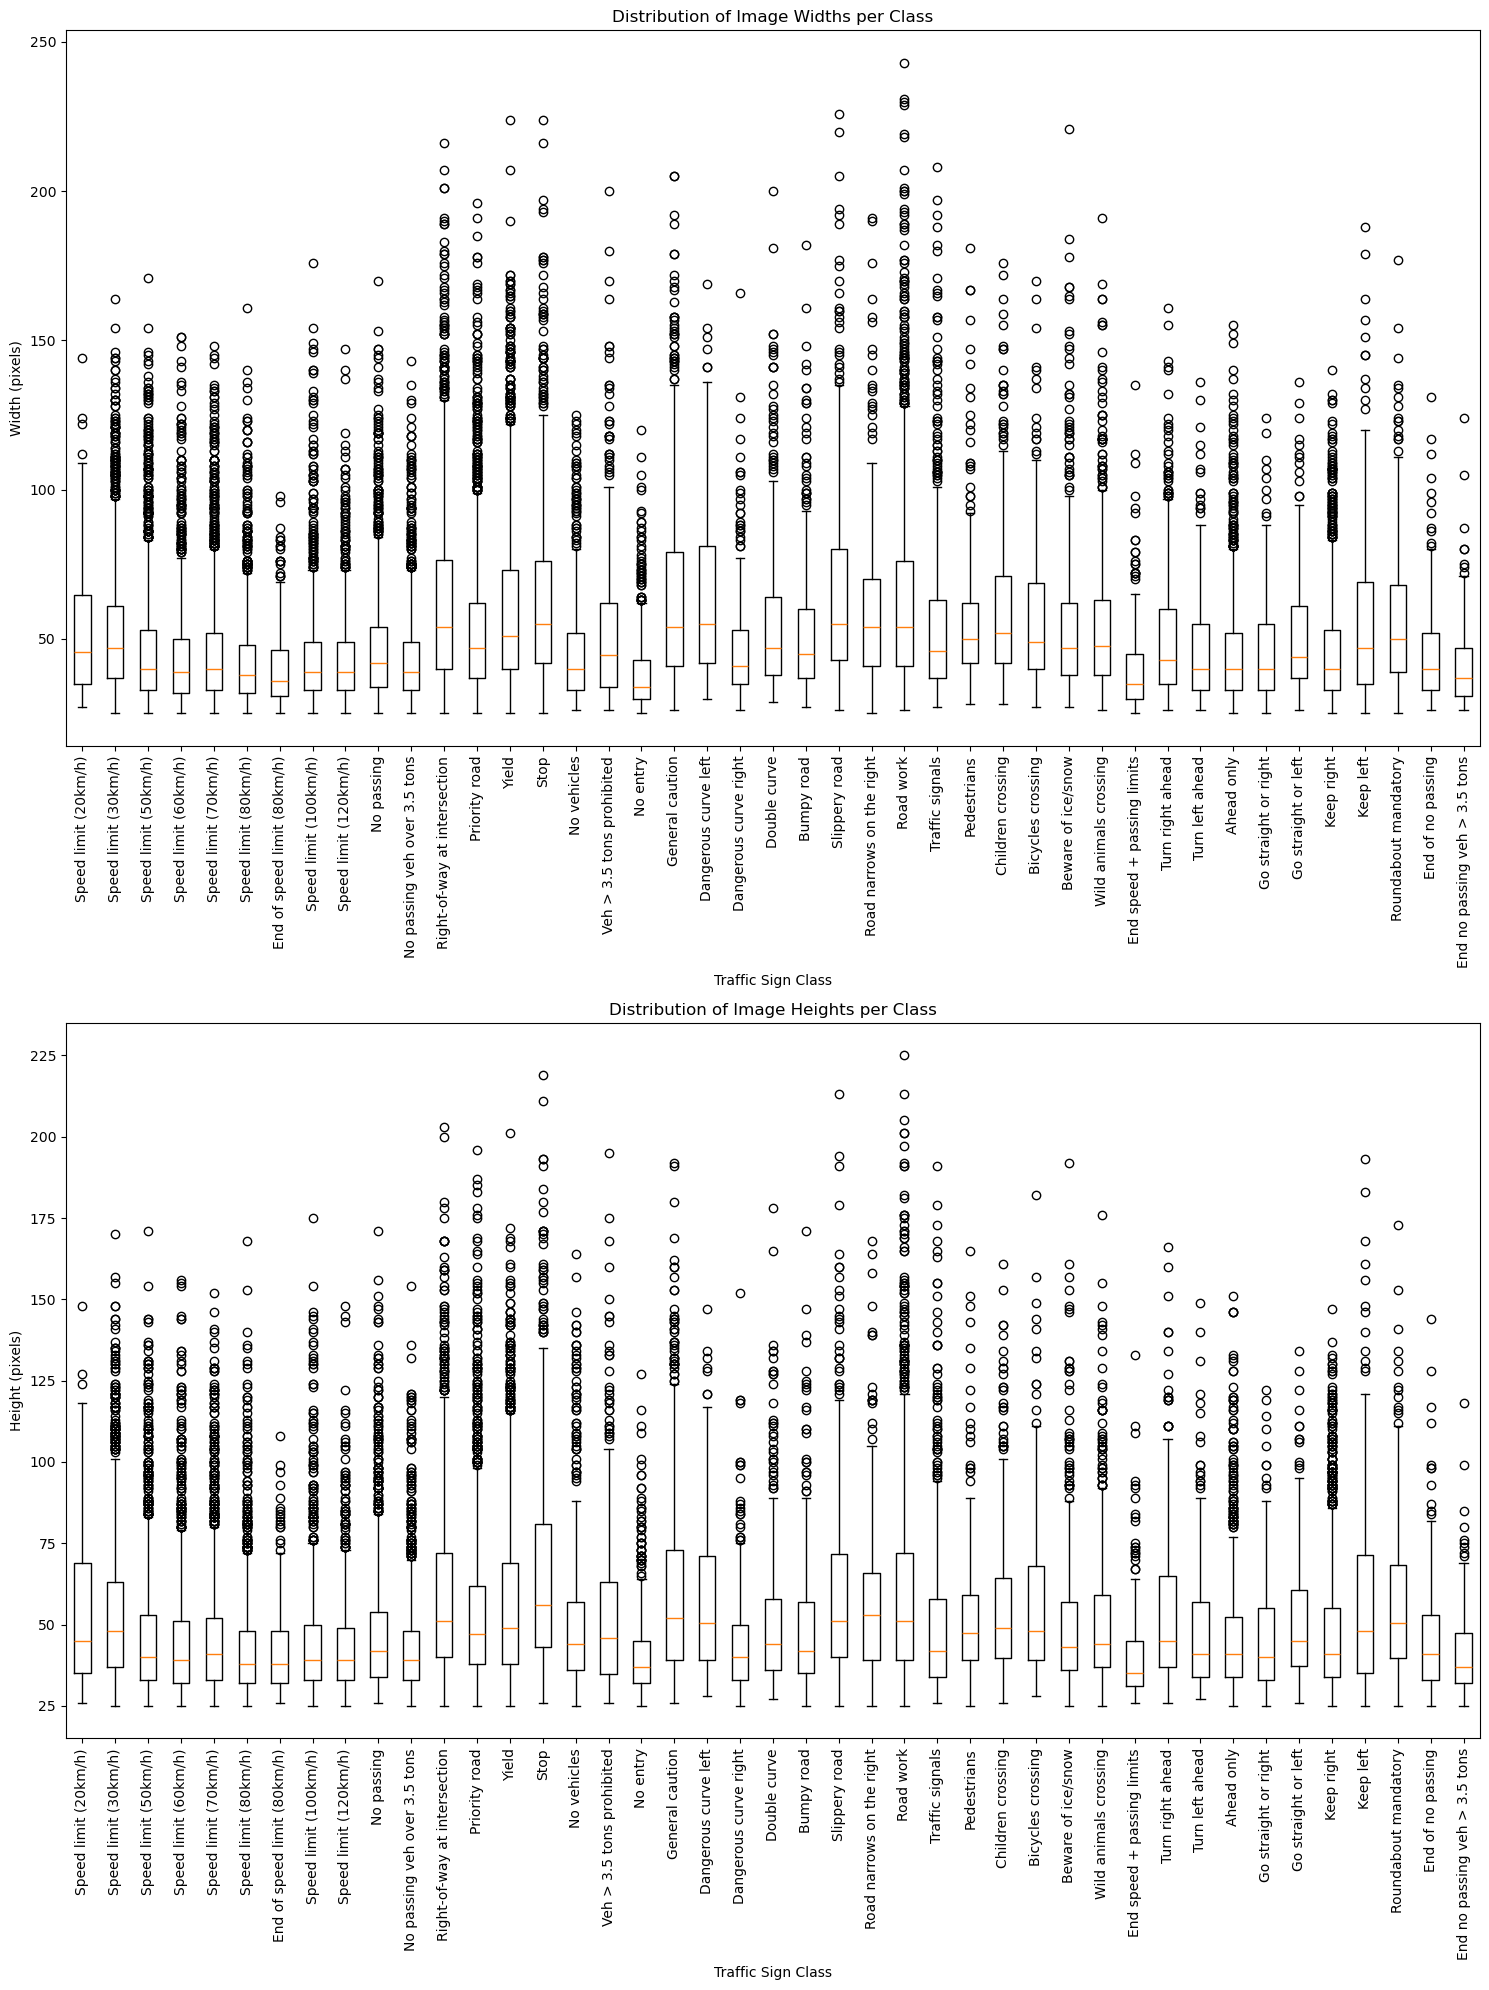

In [20]:
train_df['ClassName'] = train_df['ClassId'].map(classes)

fig, axs = plt.subplots(2, 1, figsize=(15, 20))

axs[0].boxplot([train_df[train_df['ClassId'] == i]['Width'] for i in range(len(classes))], labels=classes.values())
axs[0].set_xlabel('Traffic Sign Class')
axs[0].set_ylabel('Width (pixels)')
axs[0].set_title('Distribution of Image Widths per Class')
axs[0].tick_params(axis='x', rotation=90)

axs[1].boxplot([train_df[train_df['ClassId'] == i]['Height'] for i in range(len(classes))], labels=classes.values())
axs[1].set_xlabel('Traffic Sign Class')
axs[1].set_ylabel('Height (pixels)')
axs[1].set_title('Distribution of Image Heights per Class')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show() #вывод => они не сбалансированы


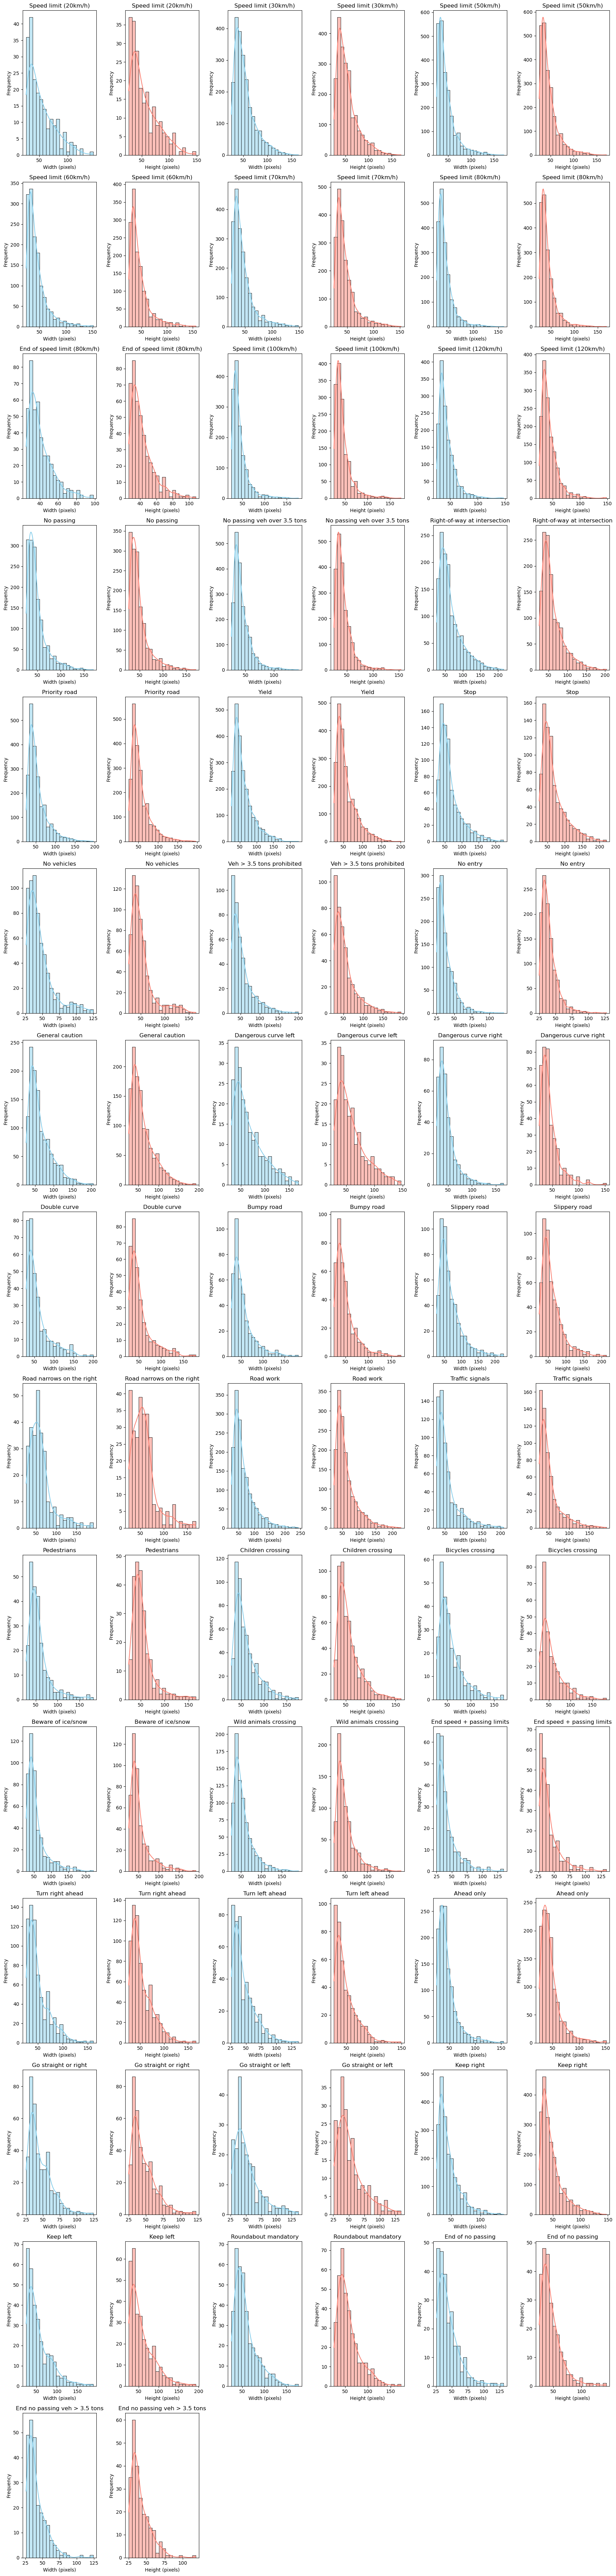

In [21]:
num_classes = len(classes)
num_rows = (num_classes * 2 + 5) // 6 
plt.figure(figsize=(18, num_rows * 5))  

for i, (class_id, class_name) in enumerate(classes.items()):
    plt.subplot(num_rows, 6, 2 * i + 1) 
    sns.histplot(train_df[train_df['ClassId'] == class_id]['Width'], bins=20, kde=True, color="skyblue")
    plt.title(f"{class_name}")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Frequency")
    
    plt.subplot(num_rows, 6, 2 * i + 2)  
    sns.histplot(train_df[train_df['ClassId'] == class_id]['Height'], bins=20, kde=True, color="salmon")
    plt.title(f"{class_name}")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show() #вывод => Все классы имеют одинаковое распределение высоты и ширины, некоторые классы в среднем содержат изображения большего размера

In [22]:
class GTSRBDataset(Dataset):
    def __init__(self, dataframe, root_dir, train=False):
        self.annotations = dataframe
        self.root_dir = root_dir
        
        #нормализация для RGB
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        #АУГМЕНТАЦИЯ
        if train:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # рандомно делаем crop и resize
                transforms.RandomHorizontalFlip(), #случайное переворачивание по горизонтали
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  #рандомно меняем эти параметры
                transforms.ToTensor(),
                self.normalize
            ])
        else:
            # transform для валидации (без аугментации)
            self.transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                self.normalize
            ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx]['Path'])
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx]['ClassId']

        image = self.transform(image)
        return image, label

In [23]:
print(train_df.head())
print(test_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path              ClassName  
0  Train/20/00020_00000_00000.png  Dangerous curve right  
1  Train/20/00020_00000_00001.png  Dangerous curve right  
2  Train/20/00020_00000_00002.png  Dangerous curve right  
3  Train/20/00020_00000_00003.png  Dangerous curve right  
4  Train/20/00020_00000_00004.png  Dangerous curve right  
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38

In [24]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
          nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
          nn.BatchNorm2d(6),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
          nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        in_features = out.shape[1]
        self.fc = nn.Linear(in_features=in_features, out_features=120)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


In [25]:
class LeNet5_extend(nn.Module):
    def __init__(self, num_classes=43): #  43 класса для нашего датасета
        super(LeNet5_extend, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

In [29]:
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.005, 0.01]
num_epochs_list = [10, 15, 20]
cost = nn.CrossEntropyLoss()   #CrossEntropyLoss() наиболее подходит для задач многоклассовой классификации, возьмем это за аксиому и не будем варьировать

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.1875, Accuracy: 65.38%, Val Loss: 0.6320, Val Accuracy: 80.04%
--------------------
Epoch [2/10], Average Loss: 0.4909, Accuracy: 84.20%, Val Loss: 0.4590, Val Accuracy: 85.44%
--------------------
Epoch [3/10], Average Loss: 0.3577, Accuracy: 88.37%, Val Loss: 0.4218, Val Accuracy: 87.20%
--------------------
Epoch [4/10], Average Loss: 0.2844, Accuracy: 90.69%, Val Loss: 0.3927, Val Accuracy: 88.38%
--------------------
Epoch [5/10], Average Loss: 0.2424, Accuracy: 92.17%, Val Loss: 0.3864, Val Accuracy: 88.61%
--------------------
Epoch [6/10], Average Loss: 0.2116, Accuracy: 93.03%, Val Loss: 0.3383, Val Accuracy: 90.13%
--------------------
Epoch [7/10], Average Loss: 0.

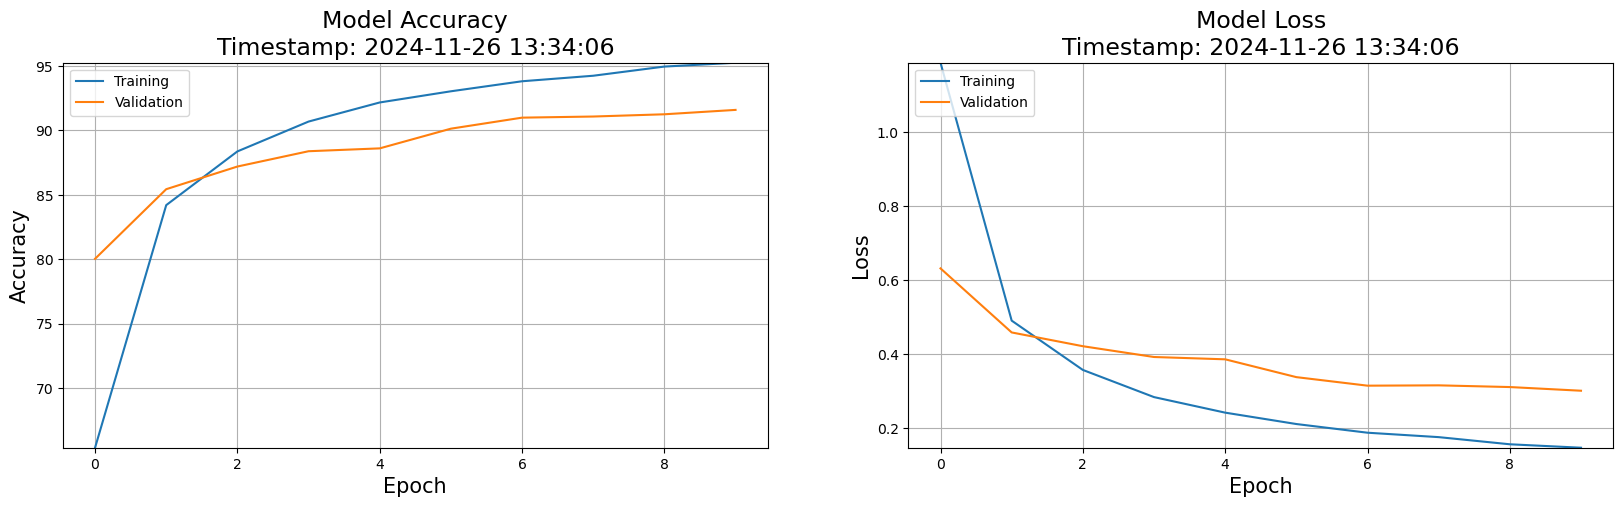

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1227, Accuracy: 96.11%, Val Loss: 0.2922, Val Accuracy: 91.85%
--------------------
Epoch [2/10], Average Loss: 0.1120, Accuracy: 96.31%, Val Loss: 0.2741, Val Accuracy: 92.25%
--------------------
Epoch [3/10], Average Loss: 0.1064, Accuracy: 96.61%, Val Loss: 0.2878, Val Accuracy: 91.91%
--------------------
Epoch [4/10], Average Loss: 0.1072, Accuracy: 96.57%, Val Loss: 0.2693, Val Accuracy: 92.45%
--------------------
Epoch [5/10], Average Loss: 0.1043, Accuracy: 96.66%, Val Loss: 0.2627, Val Accuracy: 92.71%
--------------------
Epoch [6/10], Average Loss: 0.1041, Accuracy: 96.58%, Val Loss: 0.2548, Val Accuracy: 92.85%
--------------------
Epoch [7/10], Average Loss: 0.0985, Accuracy: 96.86

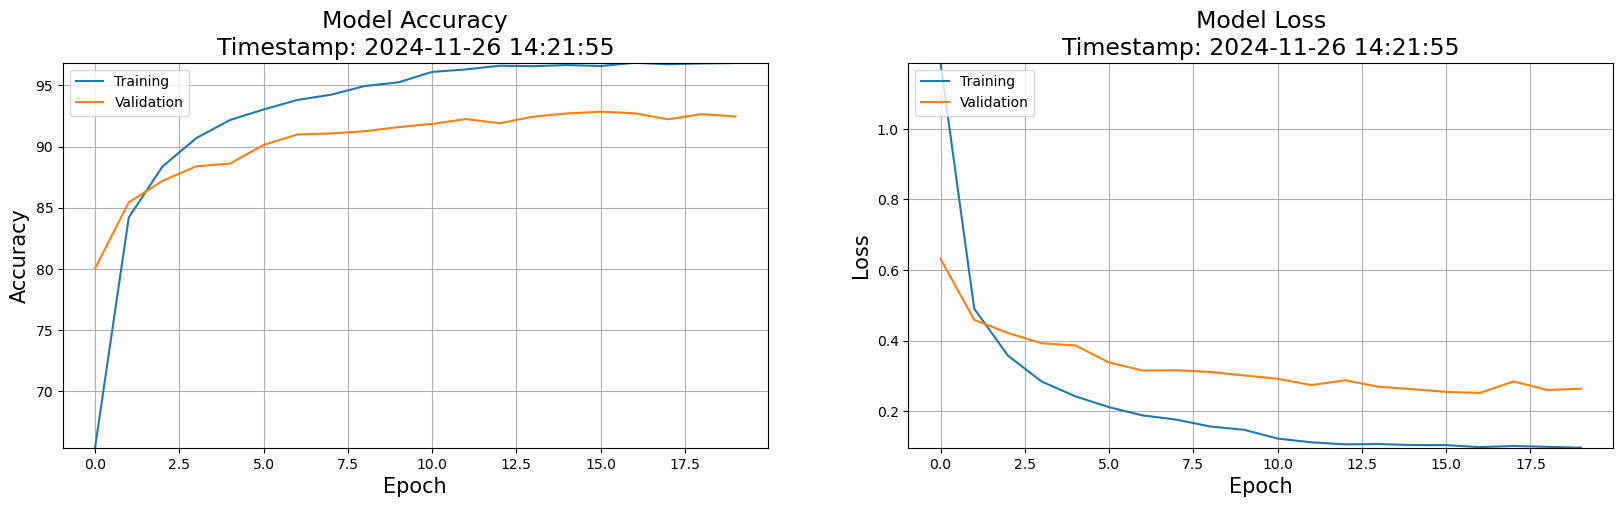

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.1408, Accuracy: 65.99%, Val Loss: 0.5728, Val Accuracy: 82.17%
--------------------
Epoch [2/15], Average Loss: 0.4901, Accuracy: 84.18%, Val Loss: 0.4636, Val Accuracy: 84.70%
--------------------
Epoch [3/15], Average Loss: 0.3435, Accuracy: 88.83%, Val Loss: 0.3887, Val Accuracy: 87.82%
--------------------
Epoch [4/15], Average Loss: 0.2780, Accuracy: 90.88%, Val Loss: 0.3625, Val Accuracy: 88.60%
--------------------
Epoch [5/15], Average Loss: 0.2326, Accuracy: 92.44%, Val Loss: 0.3576, Val Accuracy: 89.64%
--------------------
Epoch [6/15], Average Loss: 0.2071, Accuracy: 93.24%, Val Loss: 0.3201, Val Accuracy: 90.11%
--------------------
Epoch [7/15], Average Loss: 0.

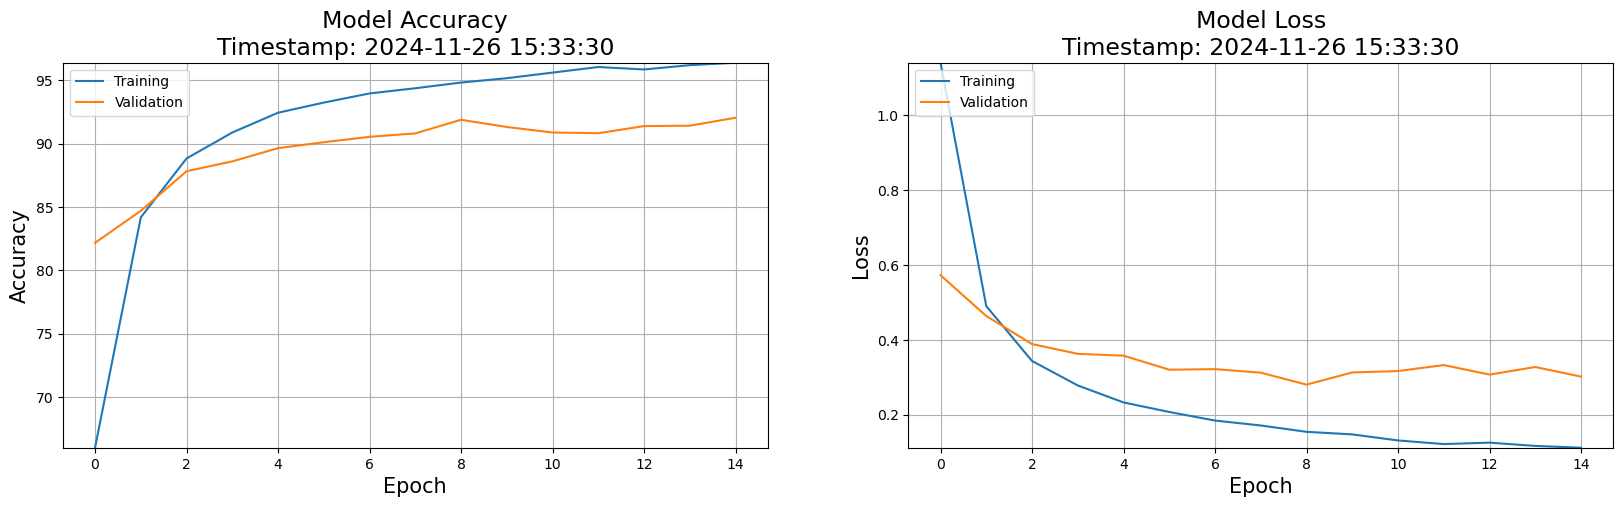

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.0918, Accuracy: 97.07%, Val Loss: 0.2864, Val Accuracy: 92.42%
--------------------
Epoch [2/15], Average Loss: 0.0856, Accuracy: 97.23%, Val Loss: 0.2778, Val Accuracy: 92.71%
--------------------
Epoch [3/15], Average Loss: 0.0829, Accuracy: 97.36%, Val Loss: 0.2761, Val Accuracy: 92.46%
--------------------
Epoch [4/15], Average Loss: 0.0803, Accuracy: 97.34%, Val Loss: 0.2559, Val Accuracy: 92.95%
--------------------
Epoch [5/15], Average Loss: 0.0802, Accuracy: 97.44%, Val Loss: 0.2635, Val Accuracy: 92.82%
--------------------
Epoch [6/15], Average Loss: 0.0850, Accuracy: 97.32%, Val Loss: 0.2780, Val Accuracy: 92.25%
--------------------
Epoch [7/15], Average Loss: 0.0786, Accuracy: 97.44

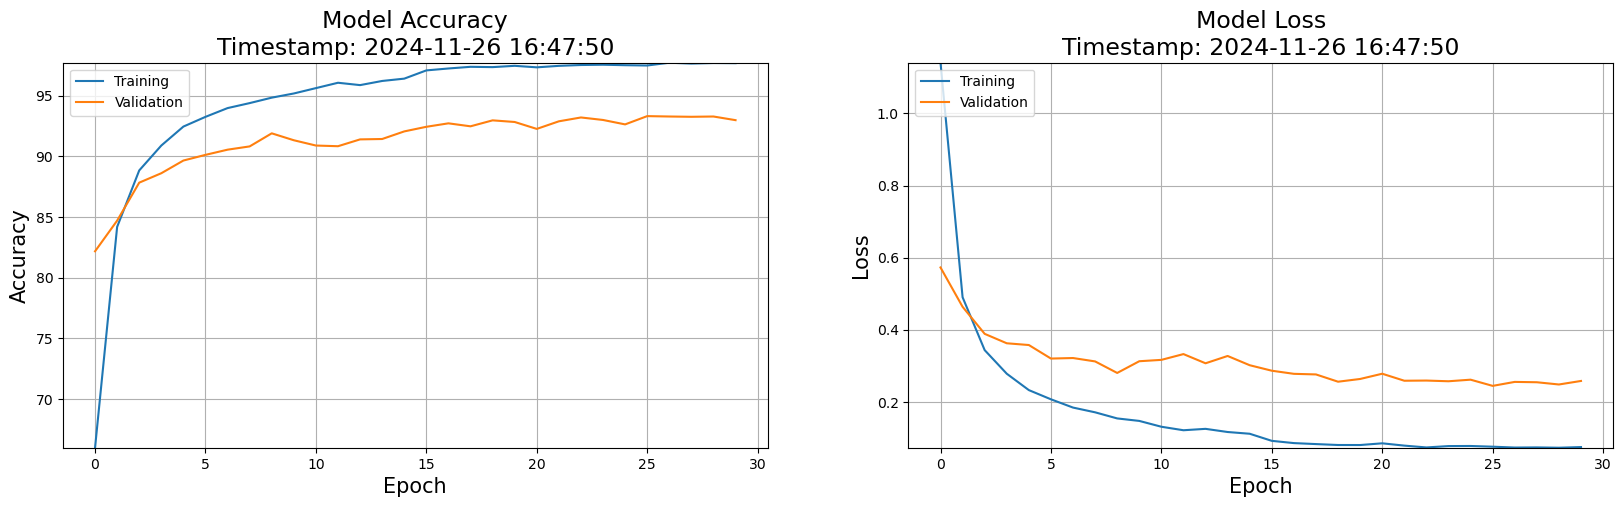

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.1597, Accuracy: 65.56%, Val Loss: 0.5847, Val Accuracy: 81.76%
--------------------
Epoch [2/20], Average Loss: 0.4867, Accuracy: 84.36%, Val Loss: 0.4634, Val Accuracy: 85.42%
--------------------
Epoch [3/20], Average Loss: 0.3525, Accuracy: 88.56%, Val Loss: 0.3540, Val Accuracy: 88.63%
--------------------
Epoch [4/20], Average Loss: 0.2848, Accuracy: 90.78%, Val Loss: 0.3636, Val Accuracy: 89.01%
--------------------
Epoch [5/20], Average Loss: 0.2379, Accuracy: 92.22%, Val Loss: 0.3291, Val Accuracy: 89.86%
--------------------
Epoch [6/20], Average Loss: 0.2055, Accuracy: 93.19%, Val Loss: 0.3538, Val Accuracy: 89.64%
--------------------
Epoch [7/20], Average Loss: 0.

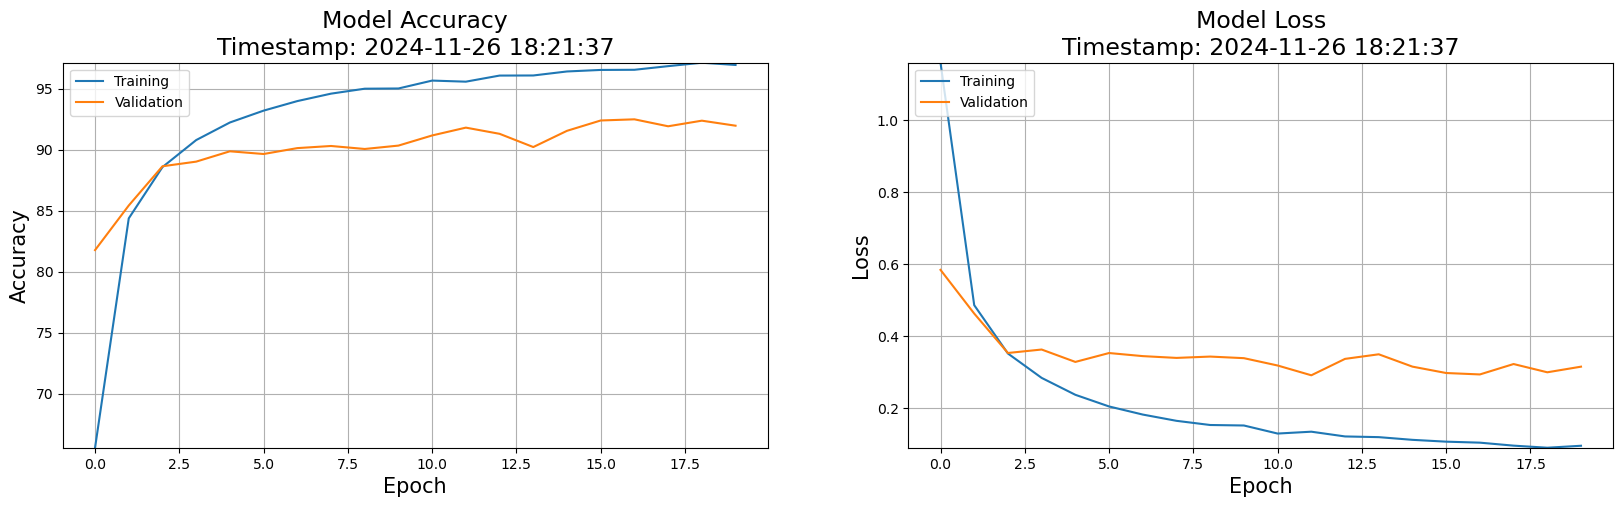

batch_size= 32 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.0776, Accuracy: 97.54%, Val Loss: 0.2842, Val Accuracy: 92.86%
--------------------
Epoch [2/20], Average Loss: 0.0741, Accuracy: 97.58%, Val Loss: 0.2747, Val Accuracy: 92.75%
--------------------
Epoch [3/20], Average Loss: 0.0717, Accuracy: 97.67%, Val Loss: 0.2566, Val Accuracy: 93.16%
--------------------
Epoch [4/20], Average Loss: 0.0667, Accuracy: 97.90%, Val Loss: 0.2778, Val Accuracy: 92.89%
--------------------
Epoch [5/20], Average Loss: 0.0678, Accuracy: 97.84%, Val Loss: 0.2717, Val Accuracy: 92.81%
--------------------
Epoch [6/20], Average Loss: 0.0659, Accuracy: 97.85%, Val Loss: 0.2870, Val Accuracy: 92.83%
--------------------
Epoch [7/20], Average Loss: 0.0685, Accuracy: 97.73

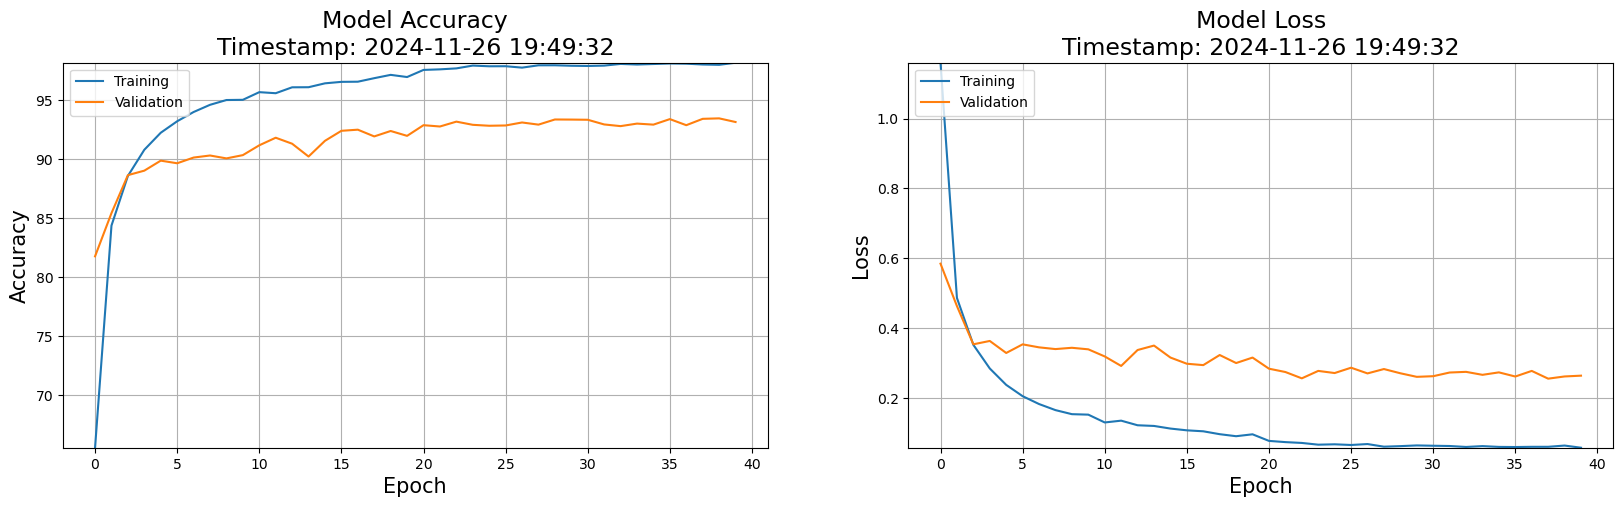

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.3993, Accuracy: 57.41%, Val Loss: 0.7703, Val Accuracy: 75.70%
--------------------
Epoch [2/10], Average Loss: 0.5906, Accuracy: 80.95%, Val Loss: 0.5491, Val Accuracy: 83.12%
--------------------
Epoch [3/10], Average Loss: 0.4372, Accuracy: 86.02%, Val Loss: 0.5037, Val Accuracy: 84.68%
--------------------
Epoch [4/10], Average Loss: 0.3617, Accuracy: 88.23%, Val Loss: 0.4589, Val Accuracy: 86.73%
--------------------
Epoch [5/10], Average Loss: 0.3107, Accuracy: 90.10%, Val Loss: 0.4588, Val Accuracy: 87.02%
--------------------
Epoch [6/10], Average Loss: 0.2869, Accuracy: 90.84%, Val Loss: 0.4223, Val Accuracy: 88.09%
--------------------
Epoch [7/10], Average Loss: 0.

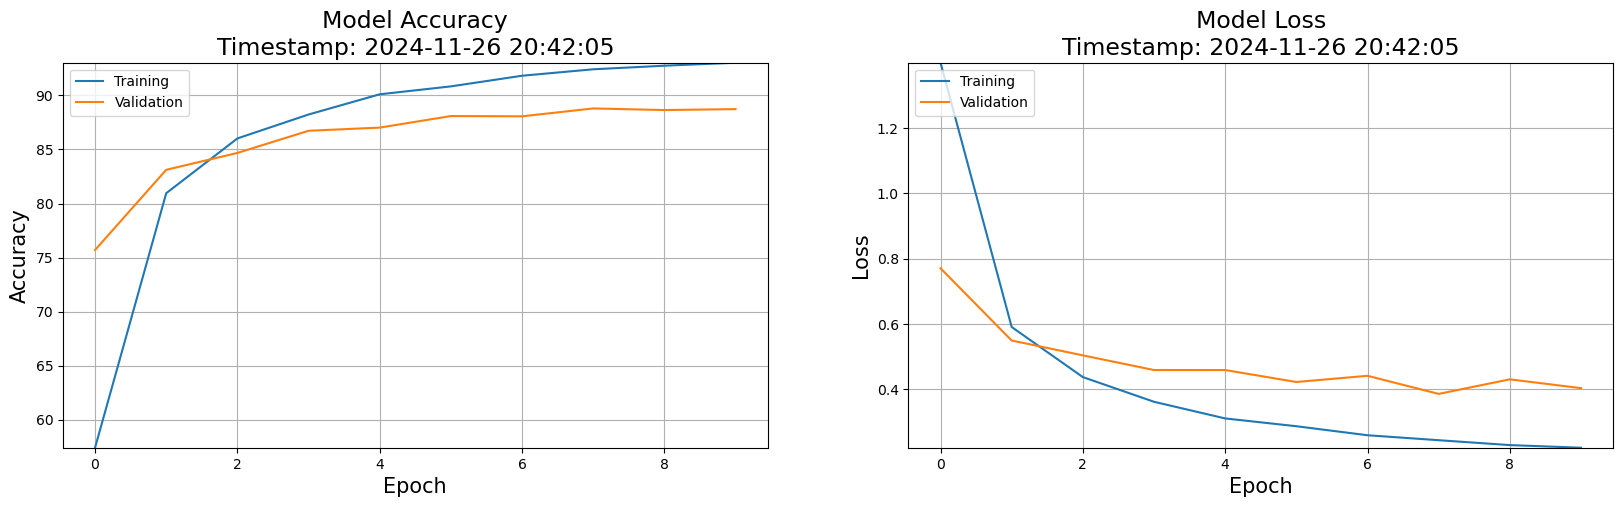

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1673, Accuracy: 94.59%, Val Loss: 0.3476, Val Accuracy: 90.49%
--------------------
Epoch [2/10], Average Loss: 0.1515, Accuracy: 95.02%, Val Loss: 0.3251, Val Accuracy: 90.78%
--------------------
Epoch [3/10], Average Loss: 0.1386, Accuracy: 95.46%, Val Loss: 0.3281, Val Accuracy: 90.94%
--------------------
Epoch [4/10], Average Loss: 0.1380, Accuracy: 95.40%, Val Loss: 0.3243, Val Accuracy: 91.05%
--------------------
Epoch [5/10], Average Loss: 0.1368, Accuracy: 95.52%, Val Loss: 0.3177, Val Accuracy: 91.26%
--------------------
Epoch [6/10], Average Loss: 0.1286, Accuracy: 95.70%, Val Loss: 0.3085, Val Accuracy: 91.48%
--------------------
Epoch [7/10], Average Loss: 0.1326, Accuracy: 95.73

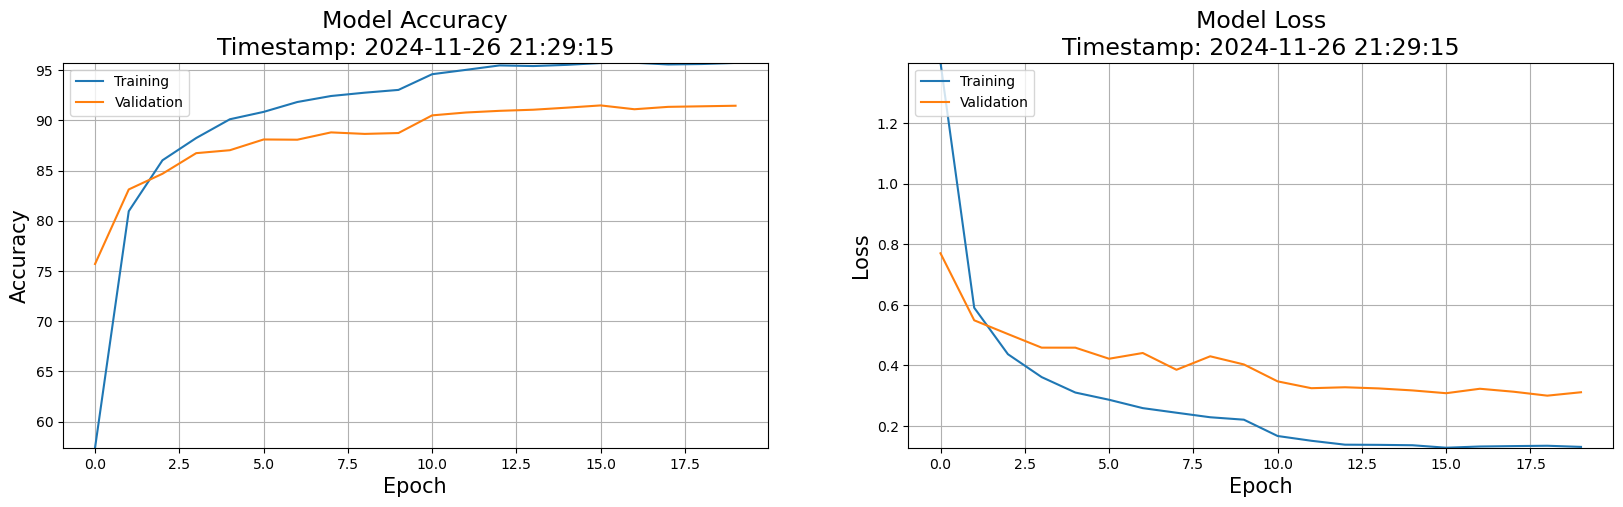

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.5995, Accuracy: 51.15%, Val Loss: 0.8650, Val Accuracy: 72.40%
--------------------
Epoch [2/15], Average Loss: 0.6810, Accuracy: 77.79%, Val Loss: 0.5817, Val Accuracy: 81.50%
--------------------
Epoch [3/15], Average Loss: 0.4690, Accuracy: 84.56%, Val Loss: 0.4863, Val Accuracy: 84.30%
--------------------
Epoch [4/15], Average Loss: 0.3843, Accuracy: 87.60%, Val Loss: 0.4683, Val Accuracy: 85.55%
--------------------
Epoch [5/15], Average Loss: 0.3340, Accuracy: 89.26%, Val Loss: 0.4552, Val Accuracy: 86.23%
--------------------
Epoch [6/15], Average Loss: 0.3041, Accuracy: 90.09%, Val Loss: 0.4228, Val Accuracy: 87.42%
--------------------
Epoch [7/15], Average Loss: 0.

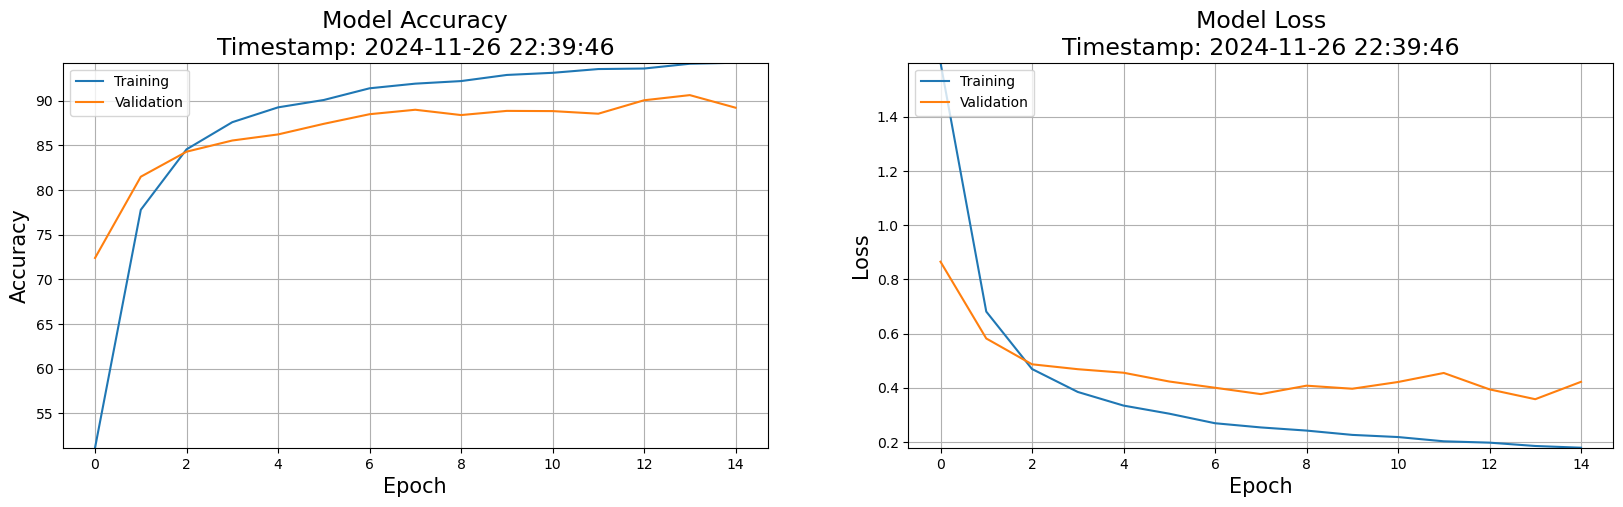

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.1387, Accuracy: 95.65%, Val Loss: 0.3498, Val Accuracy: 90.66%
--------------------
Epoch [2/15], Average Loss: 0.1294, Accuracy: 95.87%, Val Loss: 0.3395, Val Accuracy: 91.20%
--------------------
Epoch [3/15], Average Loss: 0.1177, Accuracy: 96.24%, Val Loss: 0.3386, Val Accuracy: 91.07%
--------------------
Epoch [4/15], Average Loss: 0.1150, Accuracy: 96.35%, Val Loss: 0.3189, Val Accuracy: 91.21%
--------------------
Epoch [5/15], Average Loss: 0.1168, Accuracy: 96.21%, Val Loss: 0.3263, Val Accuracy: 91.31%
--------------------
Epoch [6/15], Average Loss: 0.1146, Accuracy: 96.33%, Val Loss: 0.3157, Val Accuracy: 91.32%
--------------------
Epoch [7/15], Average Loss: 0.1155, Accuracy: 96.37

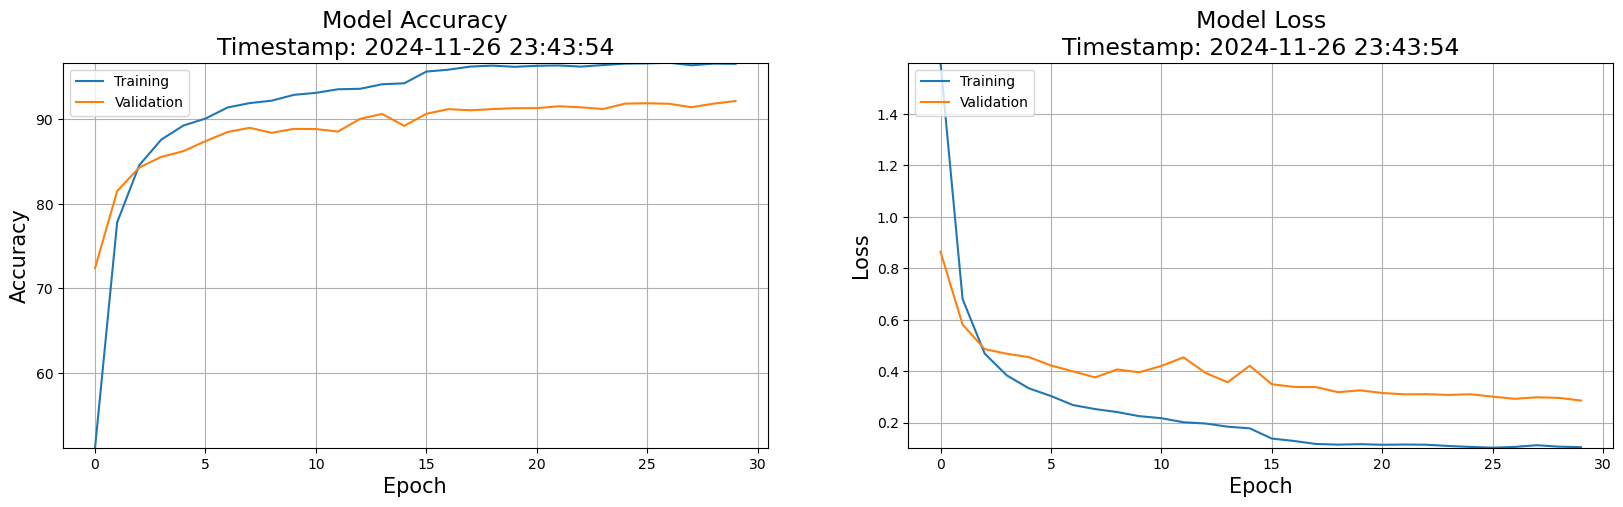

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.5576, Accuracy: 53.14%, Val Loss: 0.8350, Val Accuracy: 72.88%
--------------------
Epoch [2/20], Average Loss: 0.6660, Accuracy: 78.49%, Val Loss: 0.5912, Val Accuracy: 81.60%
--------------------
Epoch [3/20], Average Loss: 0.4647, Accuracy: 85.12%, Val Loss: 0.5789, Val Accuracy: 82.25%
--------------------
Epoch [4/20], Average Loss: 0.3733, Accuracy: 87.95%, Val Loss: 0.5245, Val Accuracy: 84.21%
--------------------
Epoch [5/20], Average Loss: 0.3222, Accuracy: 89.46%, Val Loss: 0.4495, Val Accuracy: 87.24%
--------------------
Epoch [6/20], Average Loss: 0.2957, Accuracy: 90.53%, Val Loss: 0.3849, Val Accuracy: 88.61%
--------------------
Epoch [7/20], Average Loss: 0.

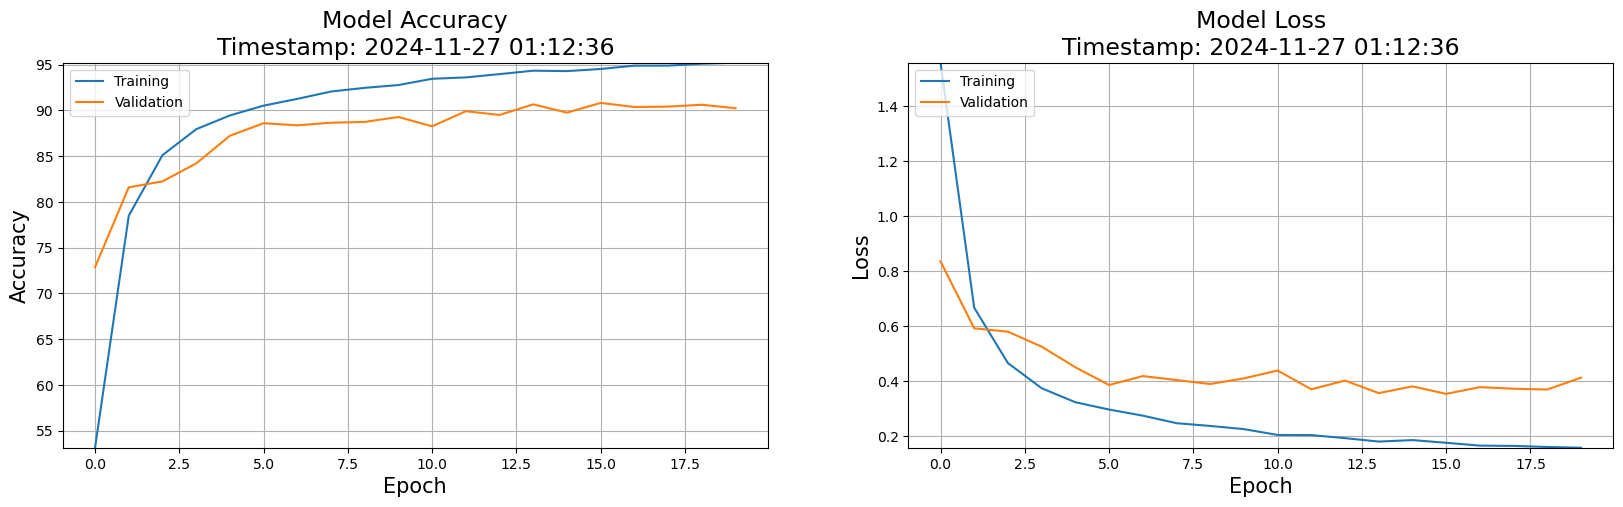

batch_size= 32 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.1211, Accuracy: 96.07%, Val Loss: 0.3417, Val Accuracy: 91.56%
--------------------
Epoch [2/20], Average Loss: 0.1116, Accuracy: 96.43%, Val Loss: 0.3087, Val Accuracy: 92.07%
--------------------
Epoch [3/20], Average Loss: 0.1022, Accuracy: 96.81%, Val Loss: 0.3195, Val Accuracy: 91.88%
--------------------
Epoch [4/20], Average Loss: 0.0990, Accuracy: 96.70%, Val Loss: 0.3092, Val Accuracy: 92.11%
--------------------
Epoch [5/20], Average Loss: 0.1008, Accuracy: 96.65%, Val Loss: 0.3180, Val Accuracy: 91.83%
--------------------
Epoch [6/20], Average Loss: 0.0944, Accuracy: 96.88%, Val Loss: 0.3133, Val Accuracy: 91.86%
--------------------
Epoch [7/20], Average Loss: 0.0971, Accuracy: 96.83

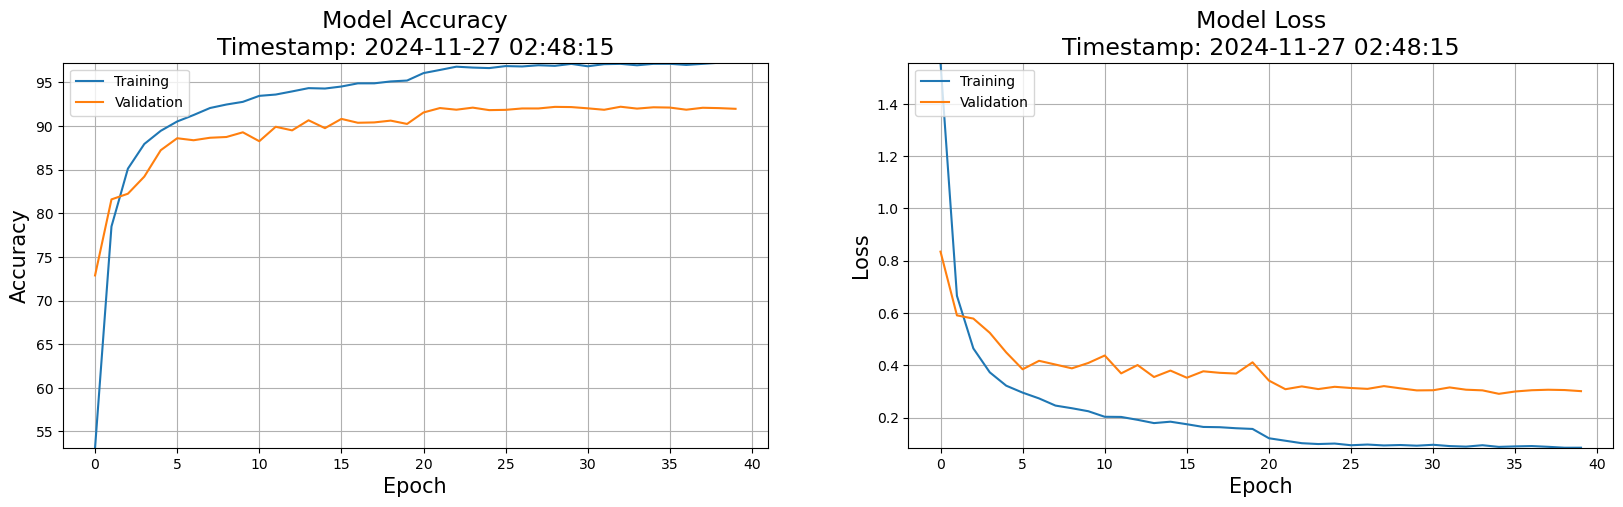

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.9130, Accuracy: 44.01%, Val Loss: 1.1776, Val Accuracy: 62.11%
--------------------
Epoch [2/10], Average Loss: 0.9318, Accuracy: 70.49%, Val Loss: 0.7736, Val Accuracy: 75.86%
--------------------
Epoch [3/10], Average Loss: 0.6542, Accuracy: 78.98%, Val Loss: 0.6372, Val Accuracy: 80.00%
--------------------
Epoch [4/10], Average Loss: 0.5515, Accuracy: 82.37%, Val Loss: 0.8008, Val Accuracy: 77.47%
--------------------
Epoch [5/10], Average Loss: 0.4792, Accuracy: 84.72%, Val Loss: 0.5776, Val Accuracy: 82.70%
--------------------
Epoch [6/10], Average Loss: 0.4343, Accuracy: 86.30%, Val Loss: 0.5831, Val Accuracy: 83.36%
--------------------
Epoch [7/10], Average Loss: 0.39

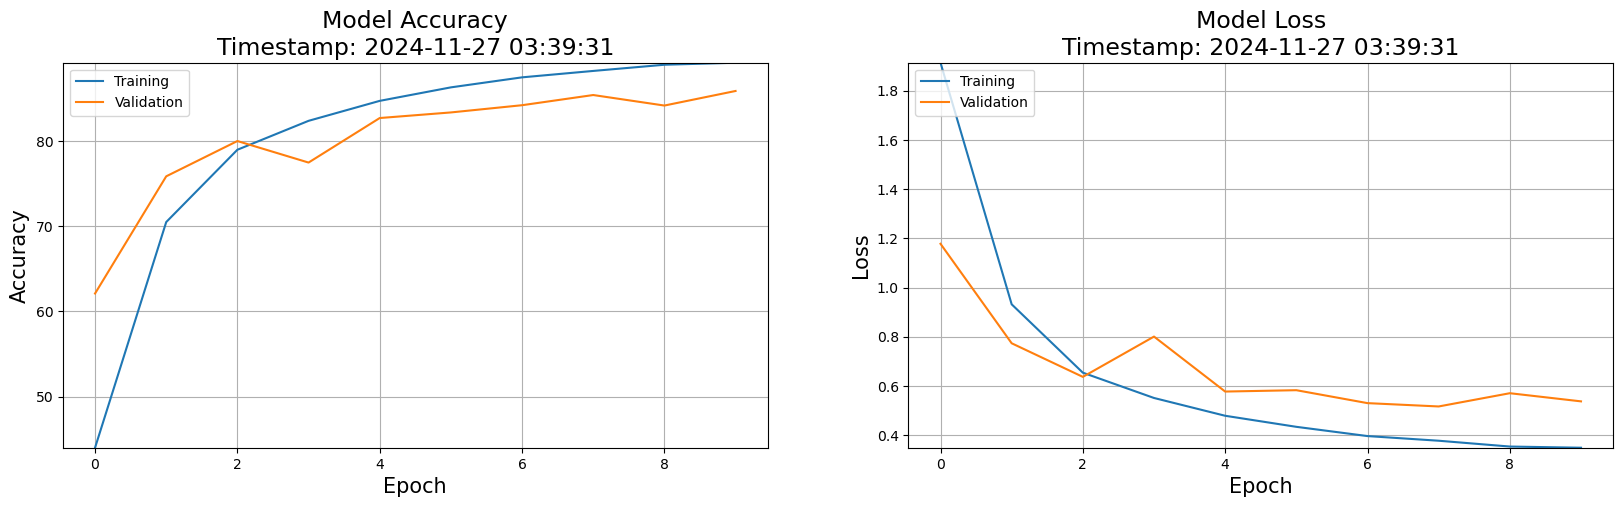

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.2568, Accuracy: 91.83%, Val Loss: 0.3960, Val Accuracy: 88.69%
--------------------
Epoch [2/10], Average Loss: 0.2234, Accuracy: 92.63%, Val Loss: 0.3957, Val Accuracy: 88.42%
--------------------
Epoch [3/10], Average Loss: 0.2162, Accuracy: 93.04%, Val Loss: 0.3899, Val Accuracy: 88.79%
--------------------
Epoch [4/10], Average Loss: 0.2100, Accuracy: 93.17%, Val Loss: 0.3725, Val Accuracy: 89.14%
--------------------
Epoch [5/10], Average Loss: 0.2038, Accuracy: 93.28%, Val Loss: 0.3834, Val Accuracy: 88.73%
--------------------
Epoch [6/10], Average Loss: 0.2053, Accuracy: 93.21%, Val Loss: 0.3801, Val Accuracy: 88.96%
--------------------
Epoch [7/10], Average Loss: 0.2024, Accuracy: 93.33%,

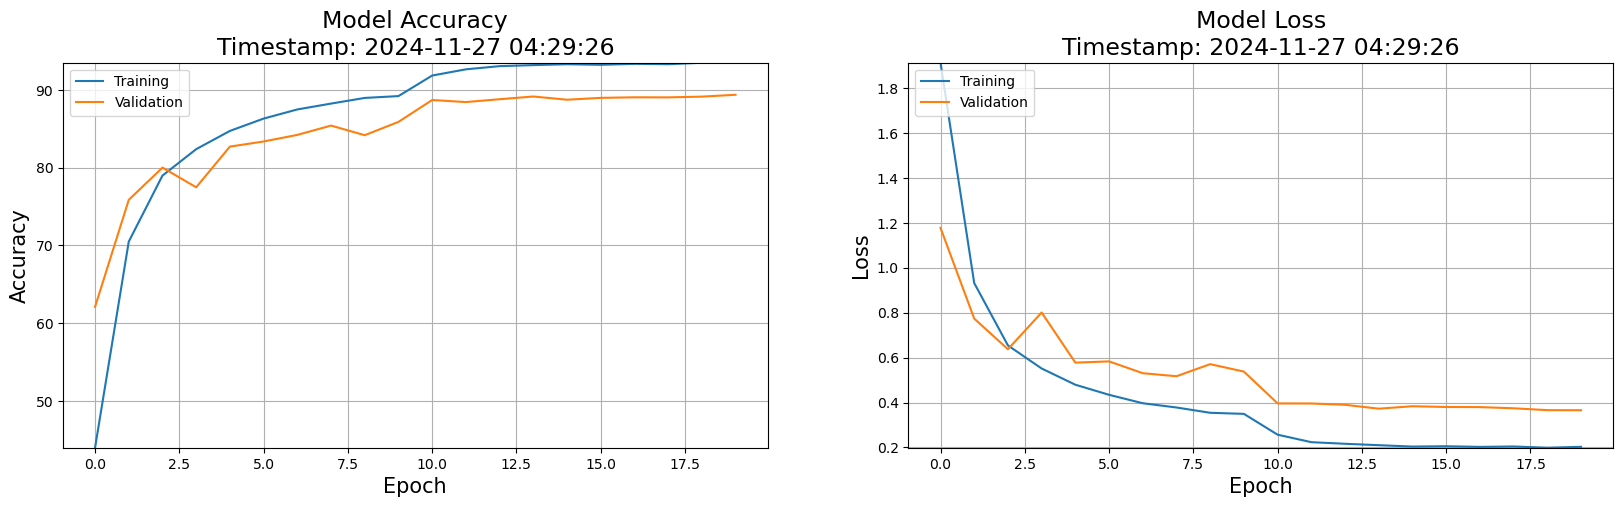

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.8154, Accuracy: 46.56%, Val Loss: 1.0594, Val Accuracy: 66.63%
--------------------
Epoch [2/15], Average Loss: 0.8634, Accuracy: 72.40%, Val Loss: 0.7975, Val Accuracy: 74.83%
--------------------
Epoch [3/15], Average Loss: 0.6589, Accuracy: 78.78%, Val Loss: 0.6633, Val Accuracy: 79.46%
--------------------
Epoch [4/15], Average Loss: 0.5597, Accuracy: 82.24%, Val Loss: 0.6257, Val Accuracy: 81.20%
--------------------
Epoch [5/15], Average Loss: 0.4942, Accuracy: 84.17%, Val Loss: 0.5794, Val Accuracy: 83.26%
--------------------
Epoch [6/15], Average Loss: 0.4536, Accuracy: 85.59%, Val Loss: 0.6050, Val Accuracy: 82.64%
--------------------
Epoch [7/15], Average Loss: 0.41

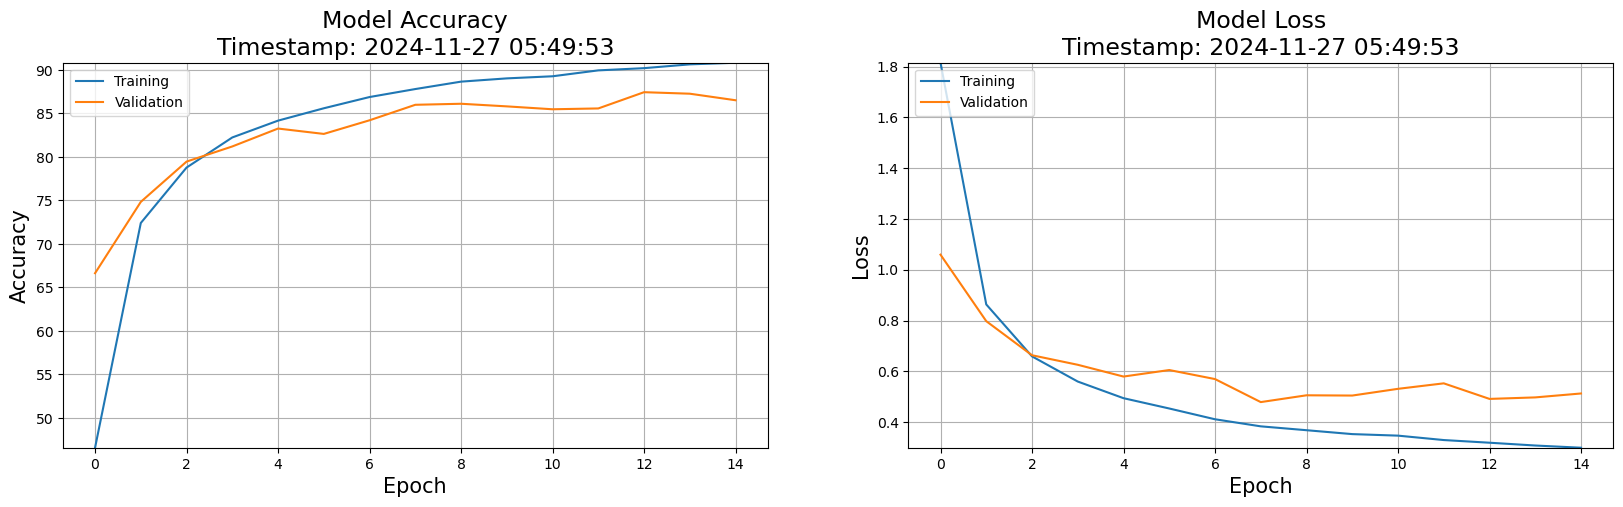

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.2196, Accuracy: 93.20%, Val Loss: 0.4120, Val Accuracy: 88.54%
--------------------
Epoch [2/15], Average Loss: 0.1968, Accuracy: 93.71%, Val Loss: 0.3855, Val Accuracy: 89.06%
--------------------
Epoch [3/15], Average Loss: 0.1940, Accuracy: 93.74%, Val Loss: 0.3938, Val Accuracy: 89.13%
--------------------
Epoch [4/15], Average Loss: 0.1923, Accuracy: 93.90%, Val Loss: 0.3778, Val Accuracy: 89.68%
--------------------
Epoch [5/15], Average Loss: 0.1855, Accuracy: 94.04%, Val Loss: 0.3755, Val Accuracy: 89.71%
--------------------
Epoch [6/15], Average Loss: 0.1844, Accuracy: 94.14%, Val Loss: 0.3663, Val Accuracy: 89.96%
--------------------
Epoch [7/15], Average Loss: 0.1798, Accuracy: 94.11%,

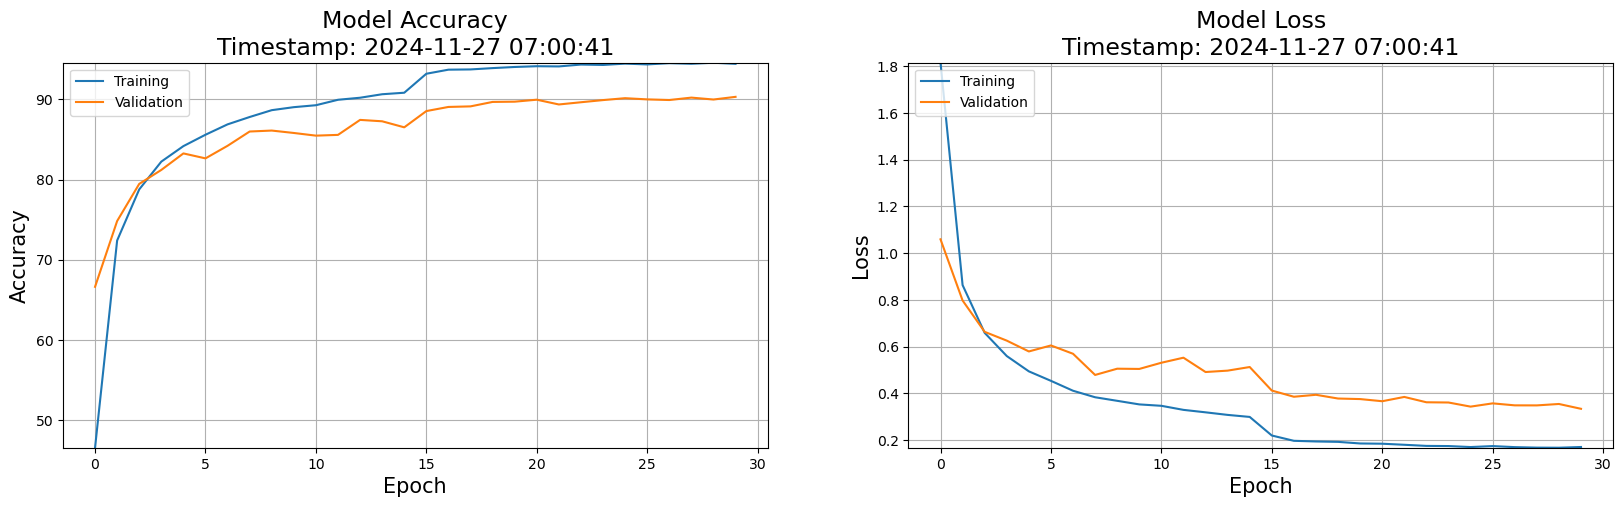

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.8096, Accuracy: 46.68%, Val Loss: 1.0323, Val Accuracy: 67.88%
--------------------
Epoch [2/20], Average Loss: 0.8437, Accuracy: 73.12%, Val Loss: 0.7235, Val Accuracy: 76.91%
--------------------
Epoch [3/20], Average Loss: 0.6169, Accuracy: 80.35%, Val Loss: 0.6458, Val Accuracy: 80.04%
--------------------
Epoch [4/20], Average Loss: 0.5243, Accuracy: 83.17%, Val Loss: 0.6396, Val Accuracy: 81.85%
--------------------
Epoch [5/20], Average Loss: 0.4787, Accuracy: 84.84%, Val Loss: 0.6210, Val Accuracy: 82.72%
--------------------
Epoch [6/20], Average Loss: 0.4413, Accuracy: 86.00%, Val Loss: 0.5465, Val Accuracy: 84.20%
--------------------
Epoch [7/20], Average Loss: 0.41

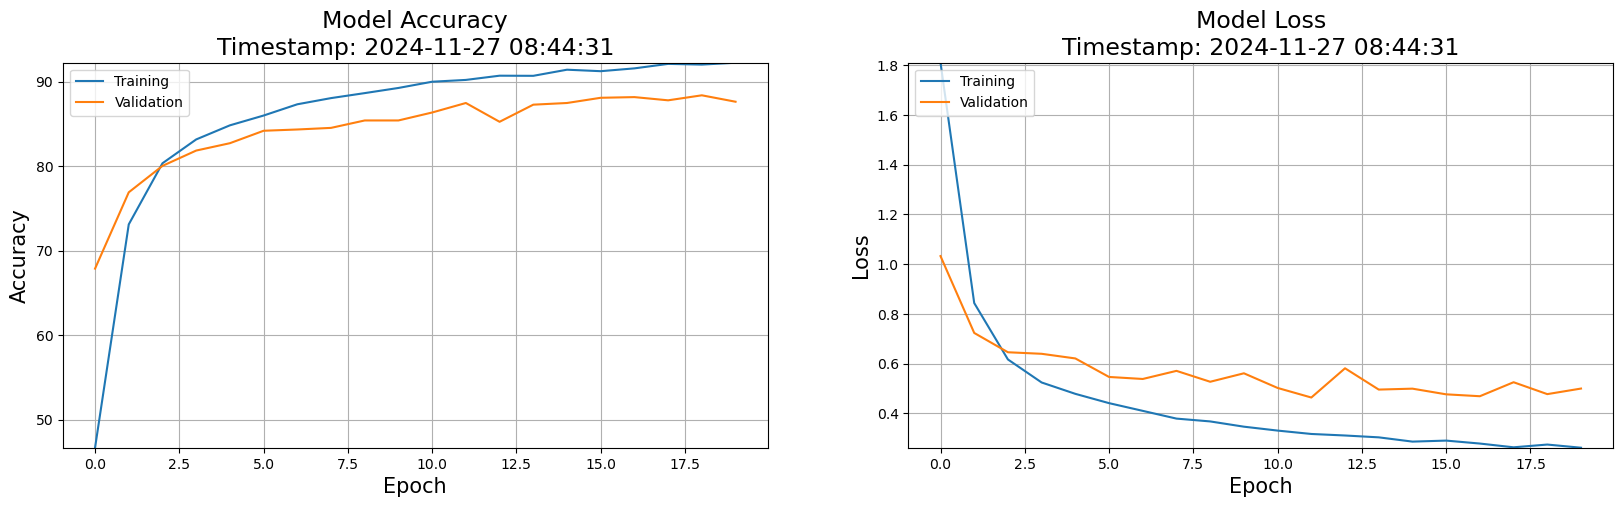

batch_size= 32 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.1873, Accuracy: 94.23%, Val Loss: 0.4231, Val Accuracy: 89.97%
--------------------
Epoch [2/20], Average Loss: 0.1658, Accuracy: 94.64%, Val Loss: 0.3855, Val Accuracy: 90.11%
--------------------
Epoch [3/20], Average Loss: 0.1660, Accuracy: 94.86%, Val Loss: 0.3830, Val Accuracy: 90.33%
--------------------
Epoch [4/20], Average Loss: 0.1593, Accuracy: 94.93%, Val Loss: 0.3705, Val Accuracy: 90.28%
--------------------
Epoch [5/20], Average Loss: 0.1604, Accuracy: 94.86%, Val Loss: 0.3680, Val Accuracy: 90.93%
--------------------
Epoch [6/20], Average Loss: 0.1591, Accuracy: 94.97%, Val Loss: 0.3694, Val Accuracy: 90.51%
--------------------
Epoch [7/20], Average Loss: 0.1503, Accuracy: 95.34%,

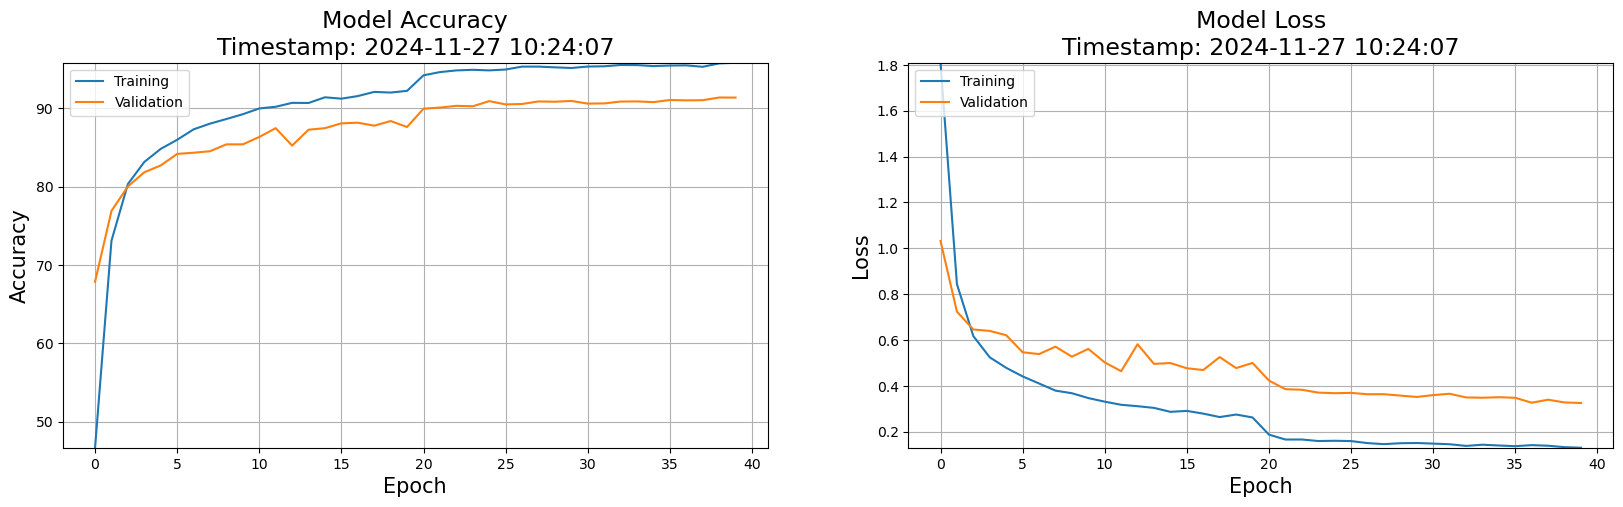

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.2641, Accuracy: 62.90%, Val Loss: 0.6450, Val Accuracy: 79.65%
--------------------
Epoch [2/10], Average Loss: 0.5083, Accuracy: 83.94%, Val Loss: 0.4368, Val Accuracy: 85.94%
--------------------
Epoch [3/10], Average Loss: 0.3547, Accuracy: 88.73%, Val Loss: 0.3799, Val Accuracy: 87.69%
--------------------
Epoch [4/10], Average Loss: 0.2759, Accuracy: 91.32%, Val Loss: 0.3256, Val Accuracy: 89.46%
--------------------
Epoch [5/10], Average Loss: 0.2272, Accuracy: 92.71%, Val Loss: 0.3196, Val Accuracy: 89.96%
--------------------
Epoch [6/10], Average Loss: 0.1993, Accuracy: 93.44%, Val Loss: 0.3064, Val Accuracy: 90.45%
--------------------
Epoch [7/10], Average Loss: 0.

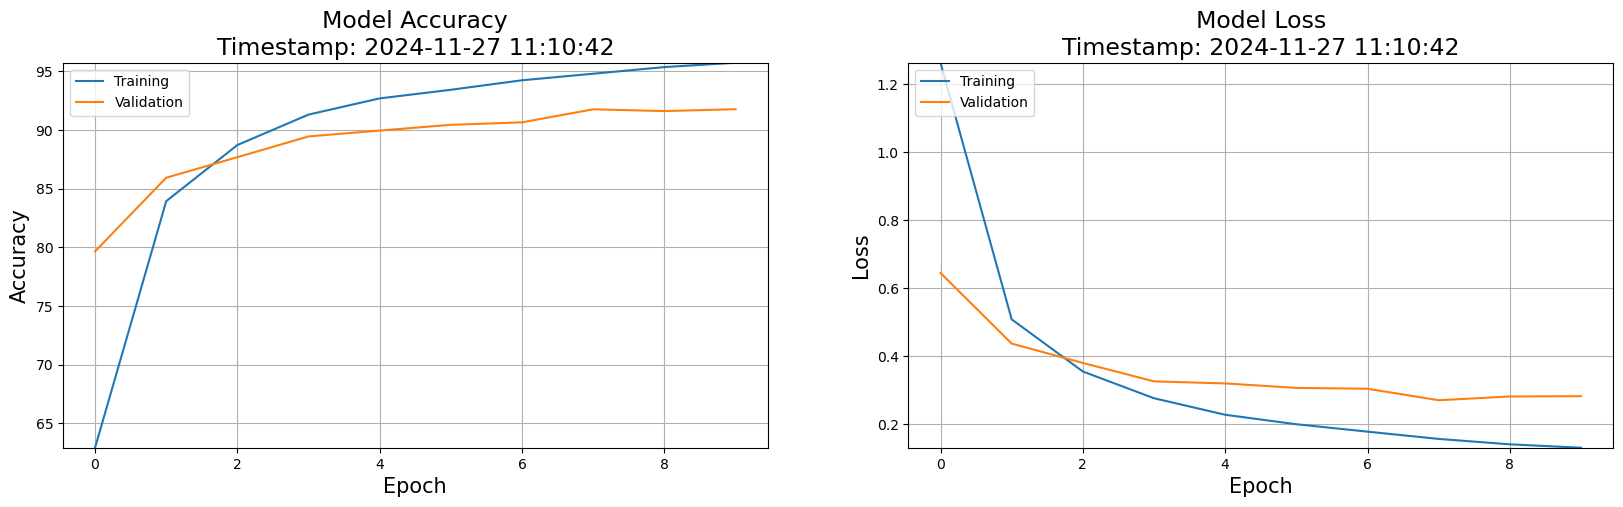

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1133, Accuracy: 96.29%, Val Loss: 0.2476, Val Accuracy: 92.57%
--------------------
Epoch [2/10], Average Loss: 0.1045, Accuracy: 96.66%, Val Loss: 0.2509, Val Accuracy: 92.34%
--------------------
Epoch [3/10], Average Loss: 0.1004, Accuracy: 96.80%, Val Loss: 0.2505, Val Accuracy: 92.45%
--------------------
Epoch [4/10], Average Loss: 0.0994, Accuracy: 96.82%, Val Loss: 0.2527, Val Accuracy: 92.50%
--------------------
Epoch [5/10], Average Loss: 0.0985, Accuracy: 96.84%, Val Loss: 0.2420, Val Accuracy: 92.90%
--------------------
Epoch [6/10], Average Loss: 0.0911, Accuracy: 97.09%, Val Loss: 0.2525, Val Accuracy: 92.49%
--------------------
Epoch [7/10], Average Loss: 0.0916, Accuracy: 97.12

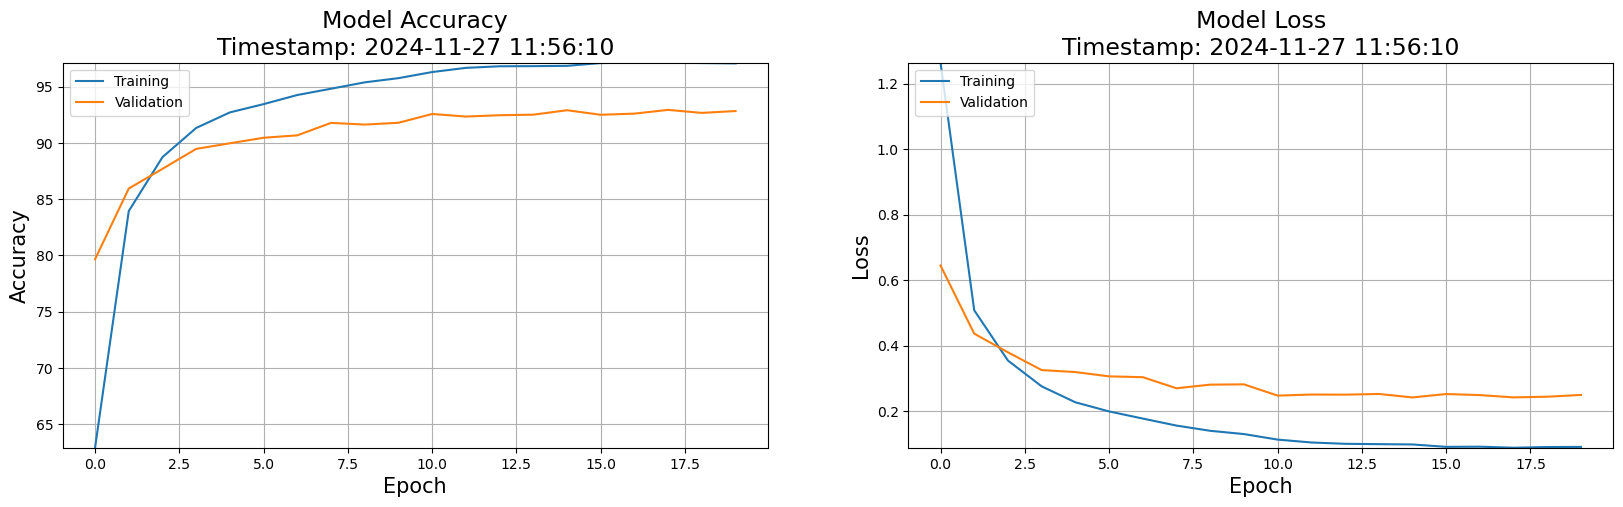

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.1636, Accuracy: 66.67%, Val Loss: 0.6228, Val Accuracy: 80.34%
--------------------
Epoch [2/15], Average Loss: 0.5002, Accuracy: 84.47%, Val Loss: 0.4522, Val Accuracy: 85.70%
--------------------
Epoch [3/15], Average Loss: 0.3402, Accuracy: 89.15%, Val Loss: 0.4067, Val Accuracy: 87.24%
--------------------
Epoch [4/15], Average Loss: 0.2703, Accuracy: 91.30%, Val Loss: 0.3671, Val Accuracy: 88.37%
--------------------
Epoch [5/15], Average Loss: 0.2275, Accuracy: 92.77%, Val Loss: 0.3240, Val Accuracy: 89.85%
--------------------
Epoch [6/15], Average Loss: 0.1950, Accuracy: 93.68%, Val Loss: 0.3375, Val Accuracy: 89.77%
--------------------
Epoch [7/15], Average Loss: 0.

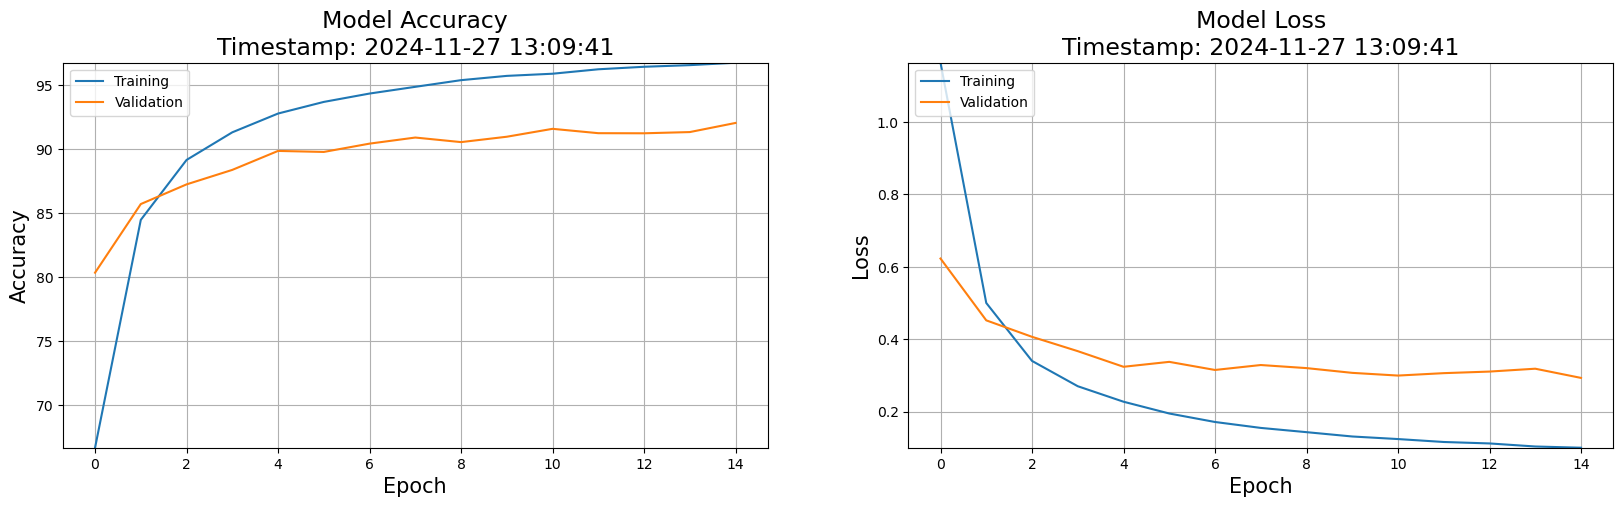

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.0847, Accuracy: 97.33%, Val Loss: 0.2880, Val Accuracy: 91.97%
--------------------
Epoch [2/15], Average Loss: 0.0777, Accuracy: 97.42%, Val Loss: 0.2929, Val Accuracy: 92.03%
--------------------
Epoch [3/15], Average Loss: 0.0765, Accuracy: 97.56%, Val Loss: 0.2799, Val Accuracy: 92.32%
--------------------
Epoch [4/15], Average Loss: 0.0751, Accuracy: 97.56%, Val Loss: 0.2720, Val Accuracy: 92.42%
--------------------
Epoch [5/15], Average Loss: 0.0727, Accuracy: 97.68%, Val Loss: 0.2720, Val Accuracy: 92.40%
--------------------
Epoch [6/15], Average Loss: 0.0727, Accuracy: 97.72%, Val Loss: 0.2719, Val Accuracy: 92.53%
--------------------
Epoch [7/15], Average Loss: 0.0724, Accuracy: 97.64

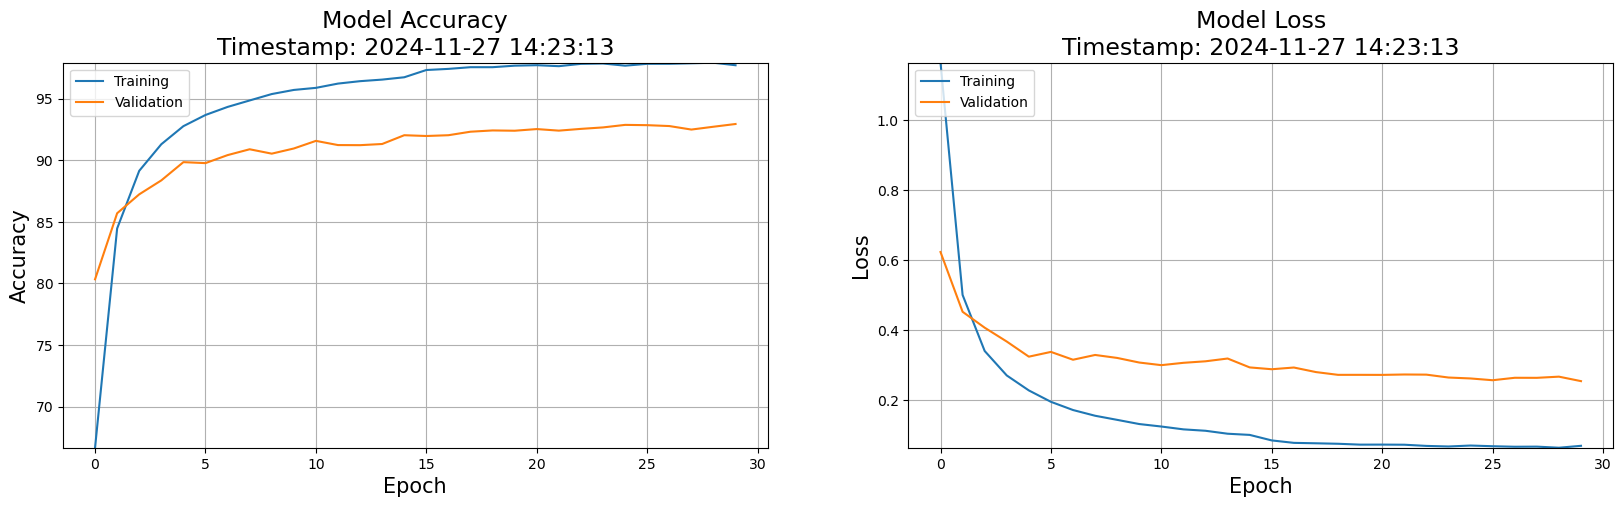

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.1983, Accuracy: 64.92%, Val Loss: 0.6002, Val Accuracy: 81.24%
--------------------
Epoch [2/20], Average Loss: 0.4846, Accuracy: 84.86%, Val Loss: 0.4256, Val Accuracy: 86.18%
--------------------
Epoch [3/20], Average Loss: 0.3471, Accuracy: 89.04%, Val Loss: 0.4018, Val Accuracy: 87.60%
--------------------
Epoch [4/20], Average Loss: 0.2746, Accuracy: 91.01%, Val Loss: 0.3509, Val Accuracy: 89.03%
--------------------
Epoch [5/20], Average Loss: 0.2269, Accuracy: 92.71%, Val Loss: 0.3305, Val Accuracy: 89.75%
--------------------
Epoch [6/20], Average Loss: 0.2009, Accuracy: 93.42%, Val Loss: 0.3614, Val Accuracy: 89.19%
--------------------
Epoch [7/20], Average Loss: 0.

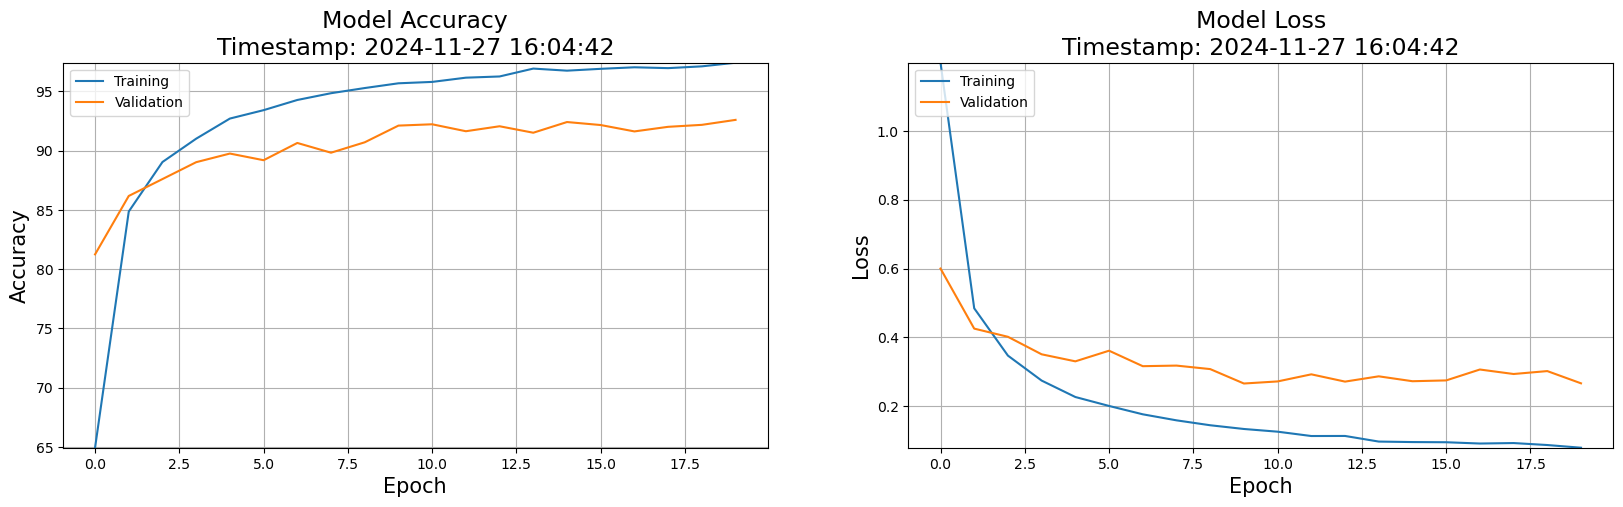

batch_size= 64 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.0656, Accuracy: 97.78%, Val Loss: 0.2568, Val Accuracy: 93.02%
--------------------
Epoch [2/20], Average Loss: 0.0637, Accuracy: 97.89%, Val Loss: 0.2538, Val Accuracy: 93.20%
--------------------
Epoch [3/20], Average Loss: 0.0622, Accuracy: 98.00%, Val Loss: 0.2597, Val Accuracy: 92.91%
--------------------
Epoch [4/20], Average Loss: 0.0621, Accuracy: 98.02%, Val Loss: 0.2464, Val Accuracy: 93.15%
--------------------
Epoch [5/20], Average Loss: 0.0607, Accuracy: 98.03%, Val Loss: 0.2702, Val Accuracy: 92.83%
--------------------
Epoch [6/20], Average Loss: 0.0585, Accuracy: 98.10%, Val Loss: 0.2480, Val Accuracy: 93.37%
--------------------
Epoch [7/20], Average Loss: 0.0562, Accuracy: 98.14

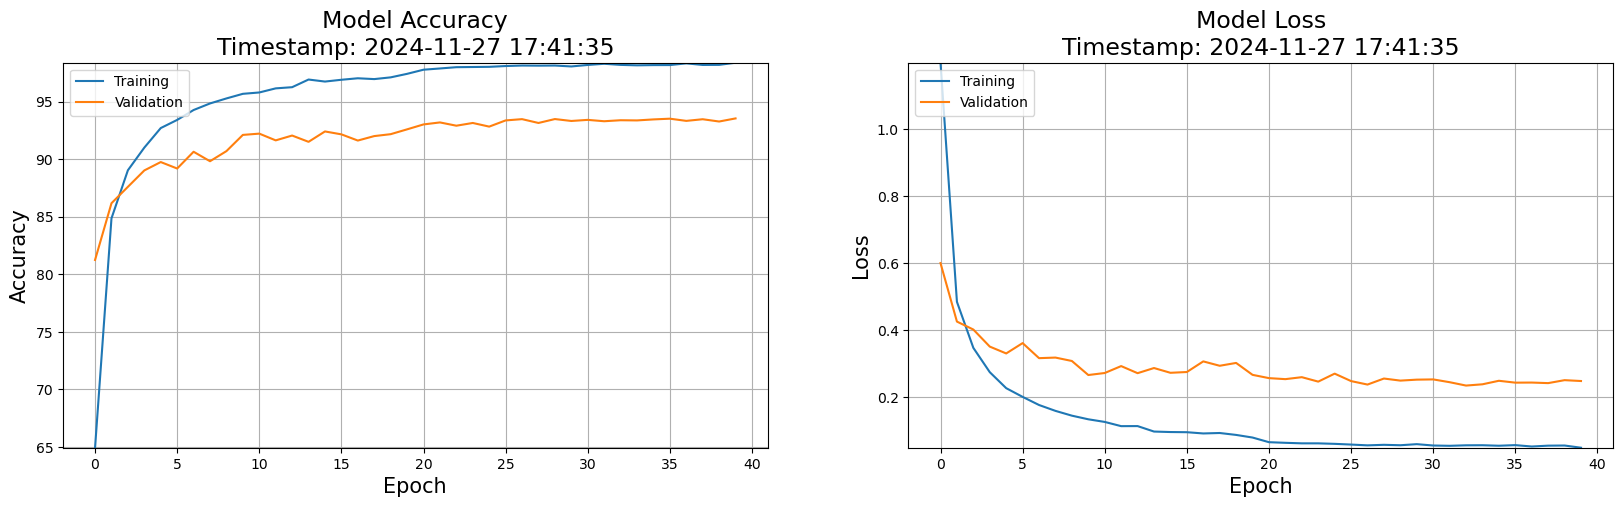

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.5907, Accuracy: 51.90%, Val Loss: 0.9424, Val Accuracy: 70.12%
--------------------
Epoch [2/10], Average Loss: 0.6332, Accuracy: 79.32%, Val Loss: 0.5799, Val Accuracy: 81.64%
--------------------
Epoch [3/10], Average Loss: 0.4206, Accuracy: 86.19%, Val Loss: 0.5499, Val Accuracy: 83.04%
--------------------
Epoch [4/10], Average Loss: 0.3232, Accuracy: 89.62%, Val Loss: 0.3796, Val Accuracy: 87.59%
--------------------
Epoch [5/10], Average Loss: 0.2675, Accuracy: 91.32%, Val Loss: 0.3907, Val Accuracy: 88.51%
--------------------
Epoch [6/10], Average Loss: 0.2428, Accuracy: 92.14%, Val Loss: 0.4215, Val Accuracy: 87.28%
--------------------
Epoch [7/10], Average Loss: 0.

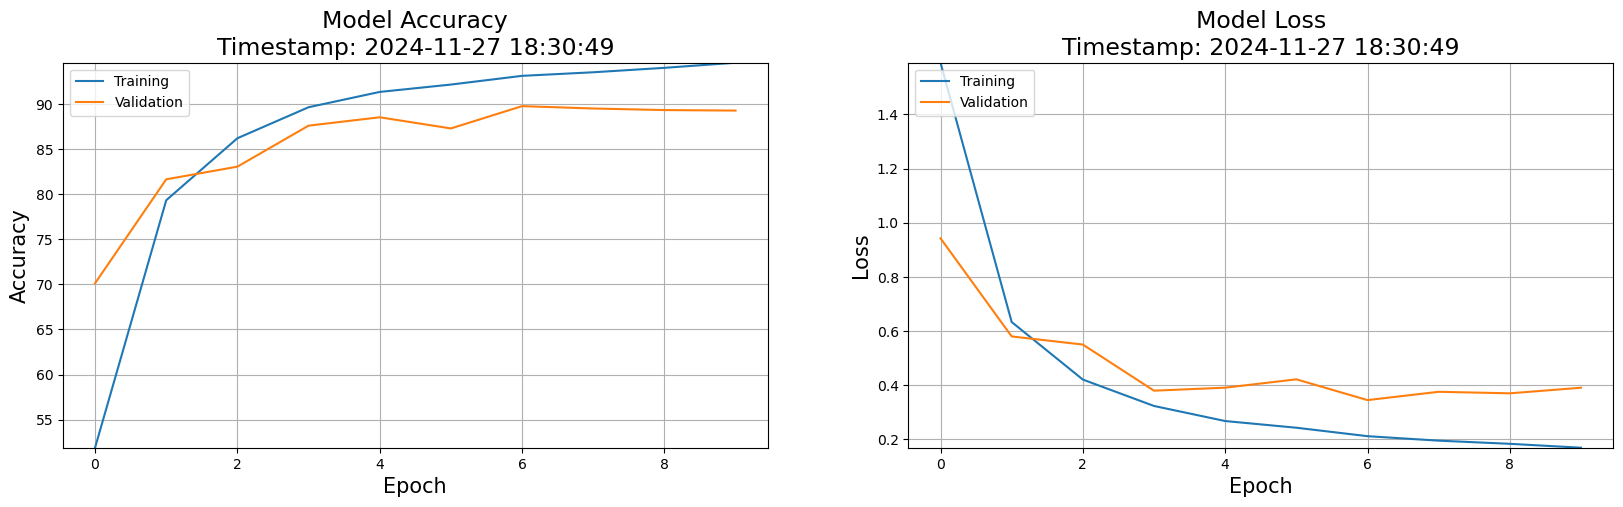

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1412, Accuracy: 95.40%, Val Loss: 0.3362, Val Accuracy: 90.67%
--------------------
Epoch [2/10], Average Loss: 0.1205, Accuracy: 96.03%, Val Loss: 0.3249, Val Accuracy: 91.20%
--------------------
Epoch [3/10], Average Loss: 0.1180, Accuracy: 96.11%, Val Loss: 0.3196, Val Accuracy: 91.33%
--------------------
Epoch [4/10], Average Loss: 0.1215, Accuracy: 96.11%, Val Loss: 0.3262, Val Accuracy: 90.86%
--------------------
Epoch [5/10], Average Loss: 0.1144, Accuracy: 96.26%, Val Loss: 0.3034, Val Accuracy: 91.50%
--------------------
Epoch [6/10], Average Loss: 0.1126, Accuracy: 96.29%, Val Loss: 0.3070, Val Accuracy: 91.59%
--------------------
Epoch [7/10], Average Loss: 0.1113, Accuracy: 96.30

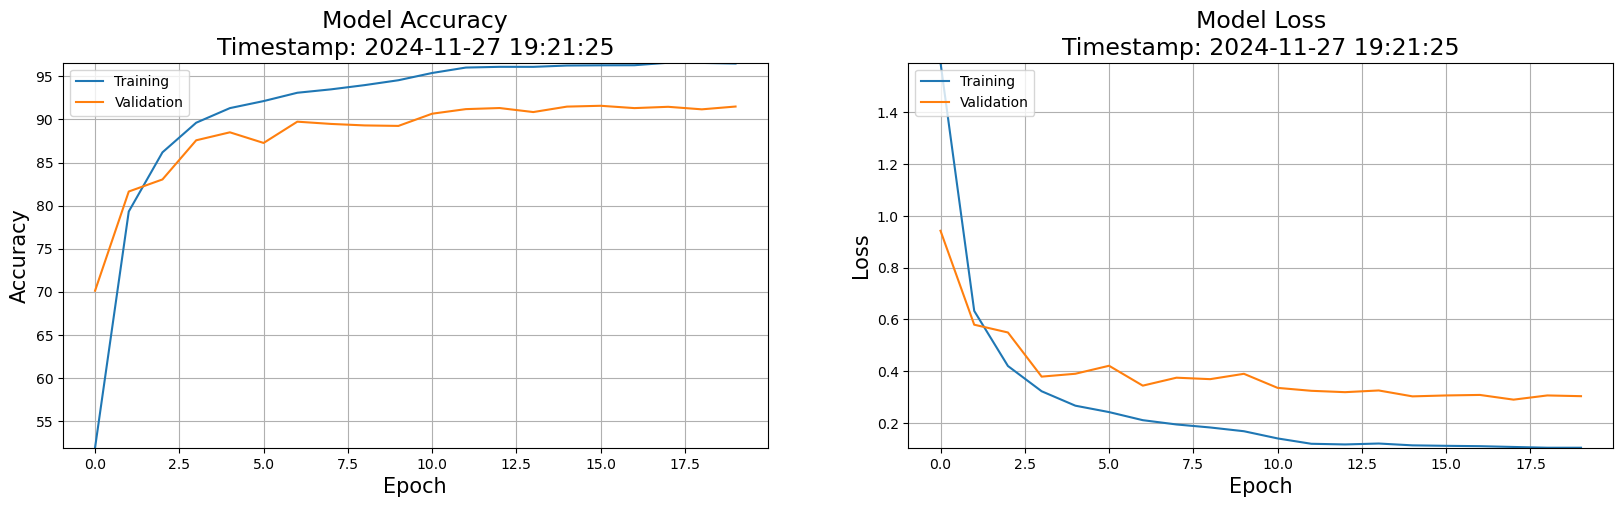

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.5325, Accuracy: 53.06%, Val Loss: 0.8365, Val Accuracy: 73.73%
--------------------
Epoch [2/15], Average Loss: 0.5872, Accuracy: 80.91%, Val Loss: 0.5593, Val Accuracy: 82.77%
--------------------
Epoch [3/15], Average Loss: 0.3969, Accuracy: 86.88%, Val Loss: 0.4310, Val Accuracy: 86.46%
--------------------
Epoch [4/15], Average Loss: 0.3063, Accuracy: 89.99%, Val Loss: 0.4067, Val Accuracy: 87.83%
--------------------
Epoch [5/15], Average Loss: 0.2640, Accuracy: 91.24%, Val Loss: 0.3997, Val Accuracy: 87.84%
--------------------
Epoch [6/15], Average Loss: 0.2272, Accuracy: 92.73%, Val Loss: 0.3785, Val Accuracy: 88.84%
--------------------
Epoch [7/15], Average Loss: 0.

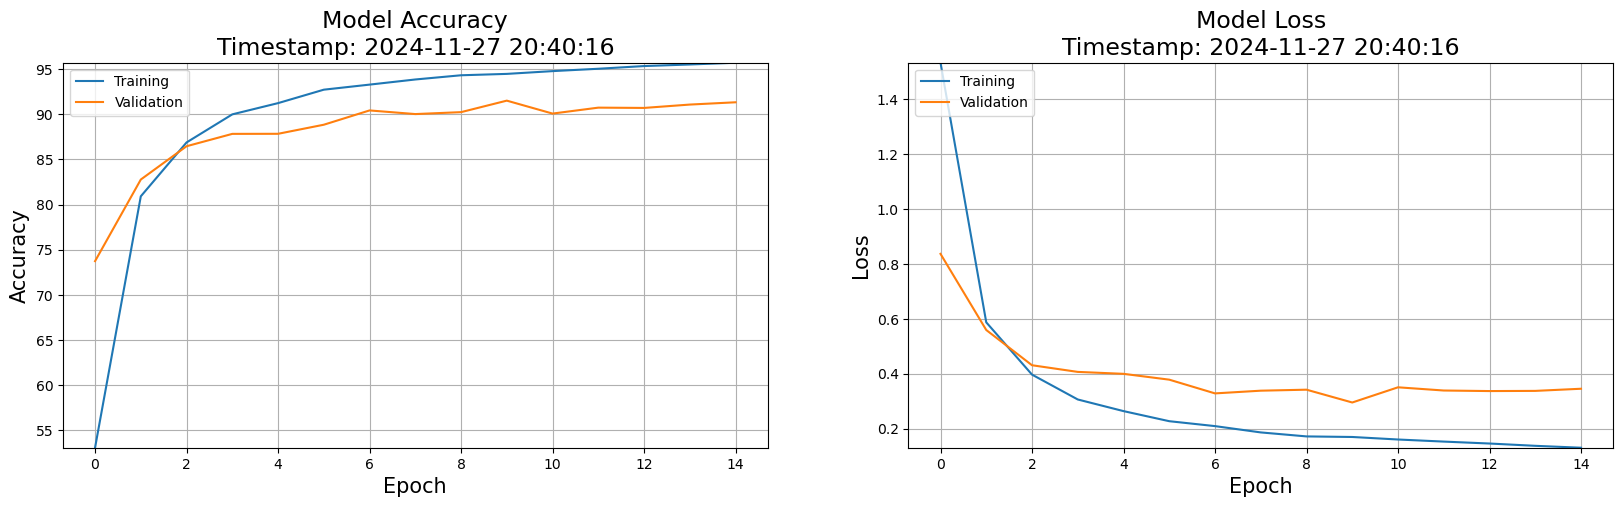

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.0982, Accuracy: 96.81%, Val Loss: 0.2963, Val Accuracy: 92.19%
--------------------
Epoch [2/15], Average Loss: 0.0935, Accuracy: 97.08%, Val Loss: 0.2872, Val Accuracy: 92.05%
--------------------
Epoch [3/15], Average Loss: 0.0836, Accuracy: 97.37%, Val Loss: 0.2866, Val Accuracy: 92.38%
--------------------
Epoch [4/15], Average Loss: 0.0839, Accuracy: 97.20%, Val Loss: 0.2951, Val Accuracy: 92.35%
--------------------
Epoch [5/15], Average Loss: 0.0845, Accuracy: 97.19%, Val Loss: 0.2773, Val Accuracy: 92.48%
--------------------
Epoch [6/15], Average Loss: 0.0862, Accuracy: 97.22%, Val Loss: 0.2856, Val Accuracy: 92.46%
--------------------
Epoch [7/15], Average Loss: 0.0801, Accuracy: 97.40

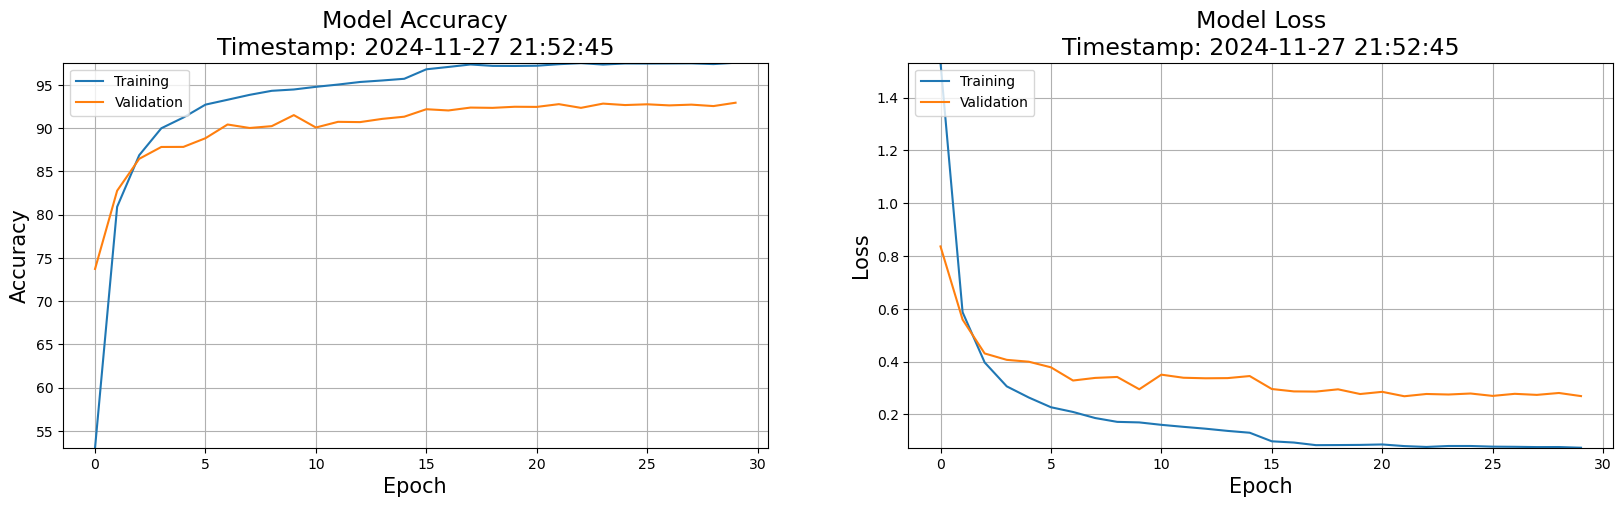

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.4542, Accuracy: 55.90%, Val Loss: 0.8101, Val Accuracy: 74.10%
--------------------
Epoch [2/20], Average Loss: 0.5844, Accuracy: 81.09%, Val Loss: 0.5861, Val Accuracy: 81.81%
--------------------
Epoch [3/20], Average Loss: 0.4068, Accuracy: 86.86%, Val Loss: 0.4627, Val Accuracy: 85.56%
--------------------
Epoch [4/20], Average Loss: 0.3238, Accuracy: 89.45%, Val Loss: 0.4358, Val Accuracy: 86.76%
--------------------
Epoch [5/20], Average Loss: 0.2700, Accuracy: 91.11%, Val Loss: 0.4168, Val Accuracy: 87.99%
--------------------
Epoch [6/20], Average Loss: 0.2454, Accuracy: 92.04%, Val Loss: 0.3990, Val Accuracy: 88.61%
--------------------
Epoch [7/20], Average Loss: 0.

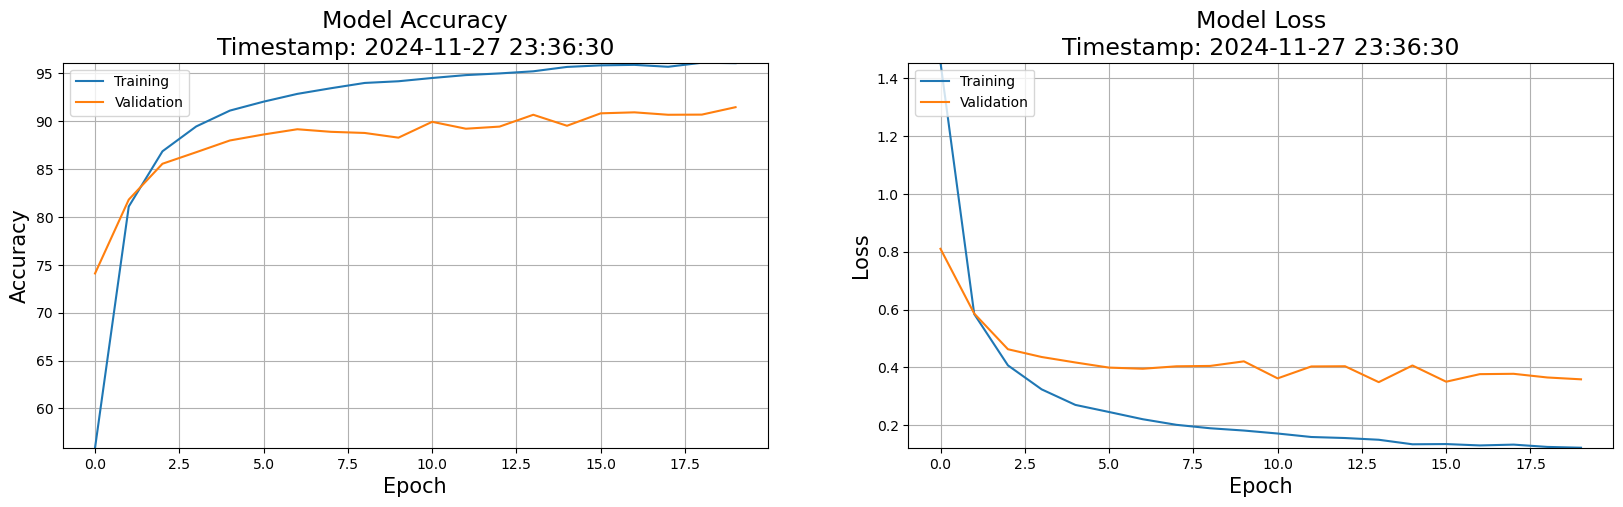

batch_size= 64 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.0956, Accuracy: 96.92%, Val Loss: 0.3215, Val Accuracy: 91.83%
--------------------
Epoch [2/20], Average Loss: 0.0859, Accuracy: 97.20%, Val Loss: 0.3218, Val Accuracy: 91.81%
--------------------
Epoch [3/20], Average Loss: 0.0866, Accuracy: 97.22%, Val Loss: 0.3138, Val Accuracy: 91.96%
--------------------
Epoch [4/20], Average Loss: 0.0804, Accuracy: 97.34%, Val Loss: 0.3009, Val Accuracy: 92.38%
--------------------
Epoch [5/20], Average Loss: 0.0825, Accuracy: 97.37%, Val Loss: 0.2967, Val Accuracy: 92.21%
--------------------
Epoch [6/20], Average Loss: 0.0787, Accuracy: 97.49%, Val Loss: 0.2845, Val Accuracy: 92.47%
--------------------
Epoch [7/20], Average Loss: 0.0762, Accuracy: 97.52

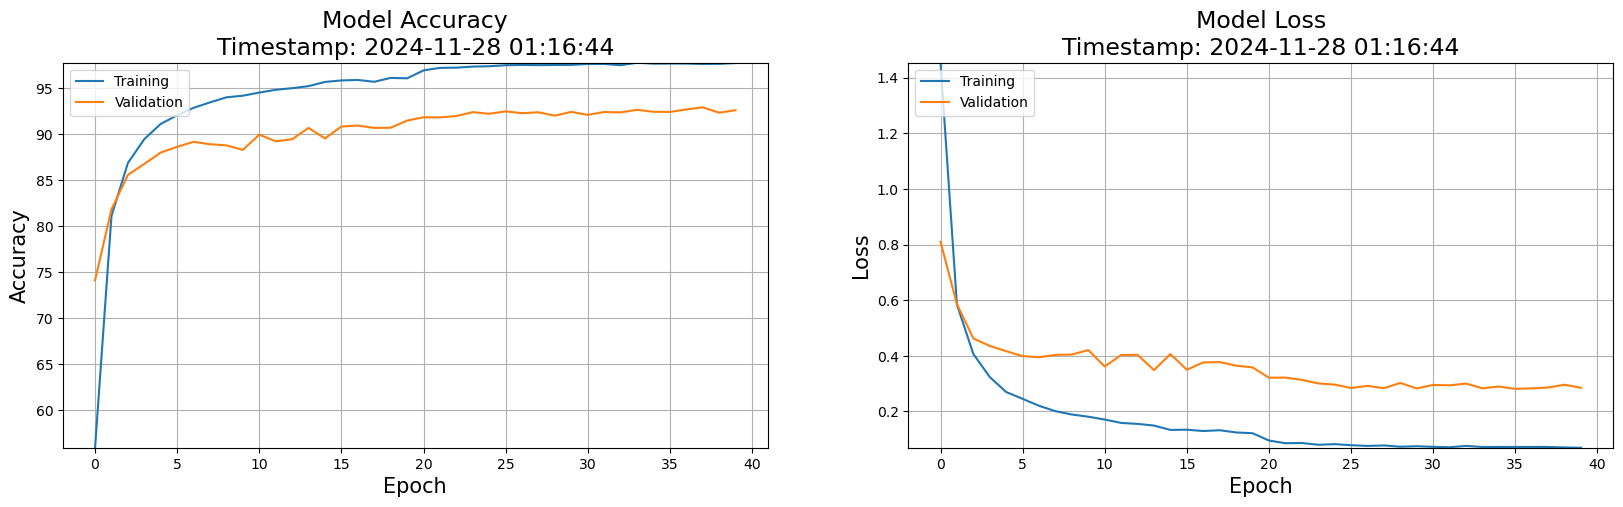

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.7982, Accuracy: 46.19%, Val Loss: 1.1271, Val Accuracy: 63.44%
--------------------
Epoch [2/10], Average Loss: 0.7846, Accuracy: 74.67%, Val Loss: 0.6783, Val Accuracy: 78.17%
--------------------
Epoch [3/10], Average Loss: 0.5337, Accuracy: 82.65%, Val Loss: 0.5669, Val Accuracy: 83.02%
--------------------
Epoch [4/10], Average Loss: 0.4235, Accuracy: 86.17%, Val Loss: 0.5642, Val Accuracy: 82.95%
--------------------
Epoch [5/10], Average Loss: 0.3620, Accuracy: 88.32%, Val Loss: 0.4770, Val Accuracy: 85.68%
--------------------
Epoch [6/10], Average Loss: 0.3358, Accuracy: 89.06%, Val Loss: 0.4656, Val Accuracy: 86.28%
--------------------
Epoch [7/10], Average Loss: 0.30

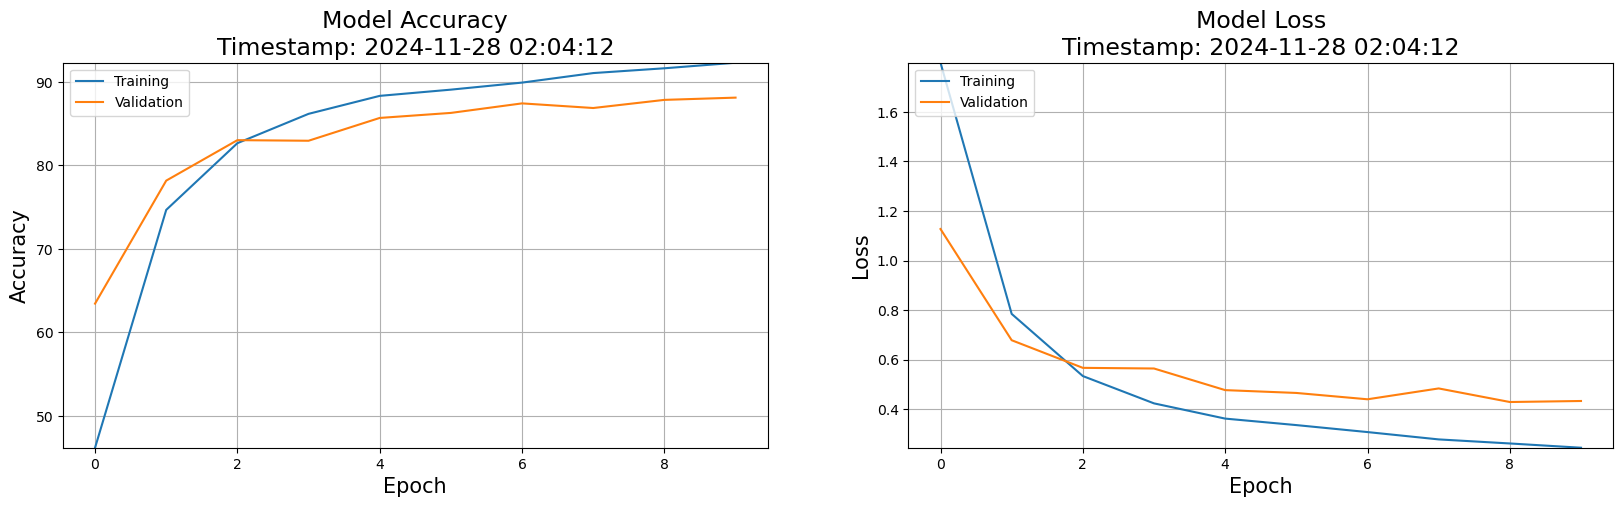

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1829, Accuracy: 94.06%, Val Loss: 0.3419, Val Accuracy: 90.07%
--------------------
Epoch [2/10], Average Loss: 0.1639, Accuracy: 94.68%, Val Loss: 0.3461, Val Accuracy: 90.24%
--------------------
Epoch [3/10], Average Loss: 0.1597, Accuracy: 94.86%, Val Loss: 0.3470, Val Accuracy: 90.21%
--------------------
Epoch [4/10], Average Loss: 0.1548, Accuracy: 95.00%, Val Loss: 0.3339, Val Accuracy: 90.61%
--------------------
Epoch [5/10], Average Loss: 0.1456, Accuracy: 95.22%, Val Loss: 0.3255, Val Accuracy: 90.65%
--------------------
Epoch [6/10], Average Loss: 0.1498, Accuracy: 95.10%, Val Loss: 0.3414, Val Accuracy: 90.41%
--------------------
Epoch [7/10], Average Loss: 0.1445, Accuracy: 95.34%,

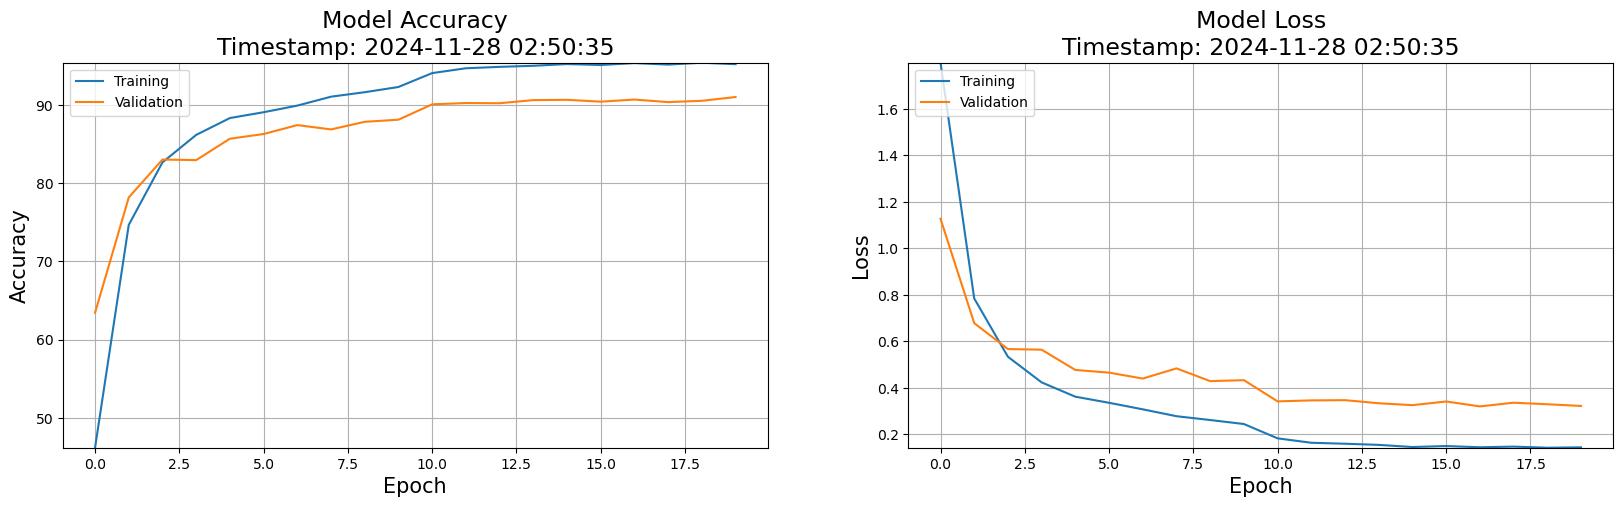

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.7475, Accuracy: 47.73%, Val Loss: 0.9546, Val Accuracy: 69.44%
--------------------
Epoch [2/15], Average Loss: 0.7115, Accuracy: 76.87%, Val Loss: 0.6238, Val Accuracy: 80.72%
--------------------
Epoch [3/15], Average Loss: 0.4730, Accuracy: 84.50%, Val Loss: 0.5629, Val Accuracy: 83.40%
--------------------
Epoch [4/15], Average Loss: 0.3803, Accuracy: 87.57%, Val Loss: 0.3962, Val Accuracy: 87.81%
--------------------
Epoch [5/15], Average Loss: 0.3443, Accuracy: 88.83%, Val Loss: 0.4784, Val Accuracy: 85.86%
--------------------
Epoch [6/15], Average Loss: 0.3009, Accuracy: 90.24%, Val Loss: 0.4955, Val Accuracy: 86.80%
--------------------
Epoch [7/15], Average Loss: 0.27

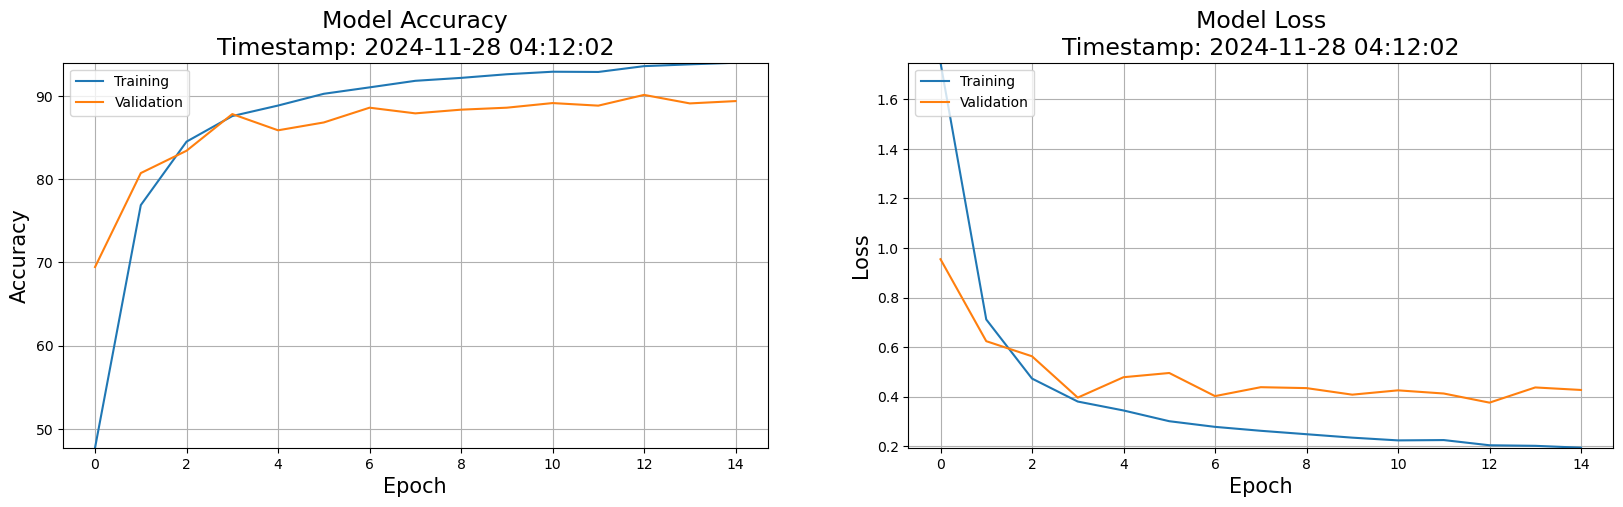

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.1410, Accuracy: 95.48%, Val Loss: 0.3632, Val Accuracy: 90.98%
--------------------
Epoch [2/15], Average Loss: 0.1193, Accuracy: 96.28%, Val Loss: 0.3390, Val Accuracy: 91.53%
--------------------
Epoch [3/15], Average Loss: 0.1180, Accuracy: 96.13%, Val Loss: 0.3229, Val Accuracy: 91.52%
--------------------
Epoch [4/15], Average Loss: 0.1120, Accuracy: 96.28%, Val Loss: 0.3260, Val Accuracy: 91.61%
--------------------
Epoch [5/15], Average Loss: 0.1071, Accuracy: 96.51%, Val Loss: 0.3236, Val Accuracy: 91.49%
--------------------
Epoch [6/15], Average Loss: 0.1124, Accuracy: 96.40%, Val Loss: 0.3115, Val Accuracy: 91.87%
--------------------
Epoch [7/15], Average Loss: 0.1118, Accuracy: 96.40%,

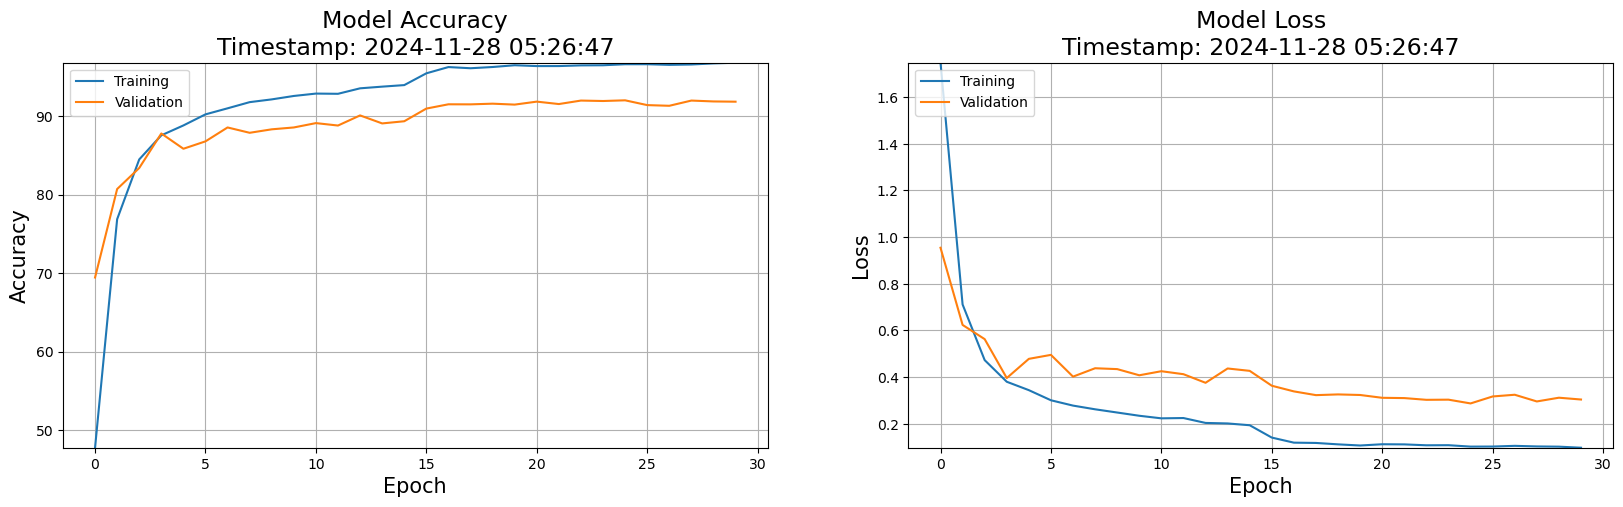

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.7783, Accuracy: 46.30%, Val Loss: 1.0254, Val Accuracy: 67.59%
--------------------
Epoch [2/20], Average Loss: 0.7730, Accuracy: 74.87%, Val Loss: 0.6513, Val Accuracy: 79.88%
--------------------
Epoch [3/20], Average Loss: 0.5264, Accuracy: 82.82%, Val Loss: 0.6380, Val Accuracy: 80.21%
--------------------
Epoch [4/20], Average Loss: 0.4195, Accuracy: 86.30%, Val Loss: 0.5904, Val Accuracy: 82.30%
--------------------
Epoch [5/20], Average Loss: 0.3747, Accuracy: 87.84%, Val Loss: 0.4806, Val Accuracy: 85.98%
--------------------
Epoch [6/20], Average Loss: 0.3293, Accuracy: 89.26%, Val Loss: 0.4933, Val Accuracy: 85.45%
--------------------
Epoch [7/20], Average Loss: 0.30

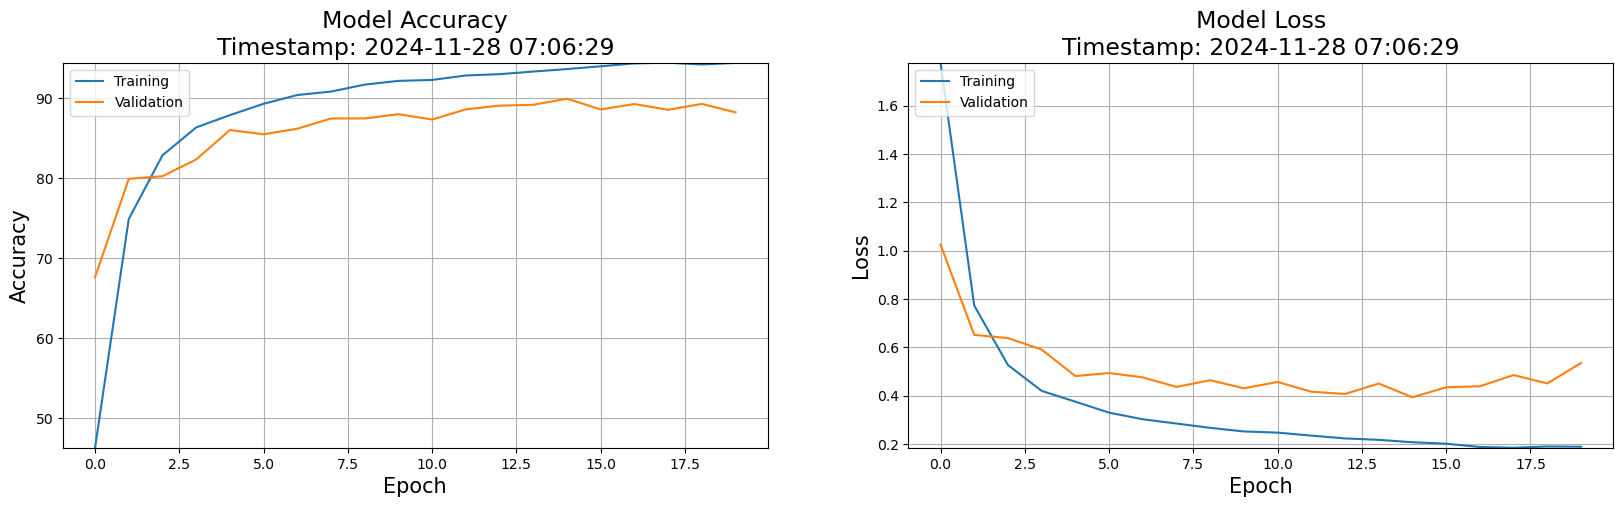

batch_size= 64 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.1398, Accuracy: 95.62%, Val Loss: 0.4077, Val Accuracy: 90.19%
--------------------
Epoch [2/20], Average Loss: 0.1135, Accuracy: 96.42%, Val Loss: 0.4023, Val Accuracy: 90.21%
--------------------
Epoch [3/20], Average Loss: 0.1095, Accuracy: 96.52%, Val Loss: 0.3834, Val Accuracy: 90.64%
--------------------
Epoch [4/20], Average Loss: 0.1064, Accuracy: 96.53%, Val Loss: 0.3789, Val Accuracy: 90.84%
--------------------
Epoch [5/20], Average Loss: 0.1060, Accuracy: 96.65%, Val Loss: 0.3747, Val Accuracy: 90.49%
--------------------
Epoch [6/20], Average Loss: 0.1042, Accuracy: 96.65%, Val Loss: 0.3586, Val Accuracy: 90.86%
--------------------
Epoch [7/20], Average Loss: 0.1033, Accuracy: 96.62%,

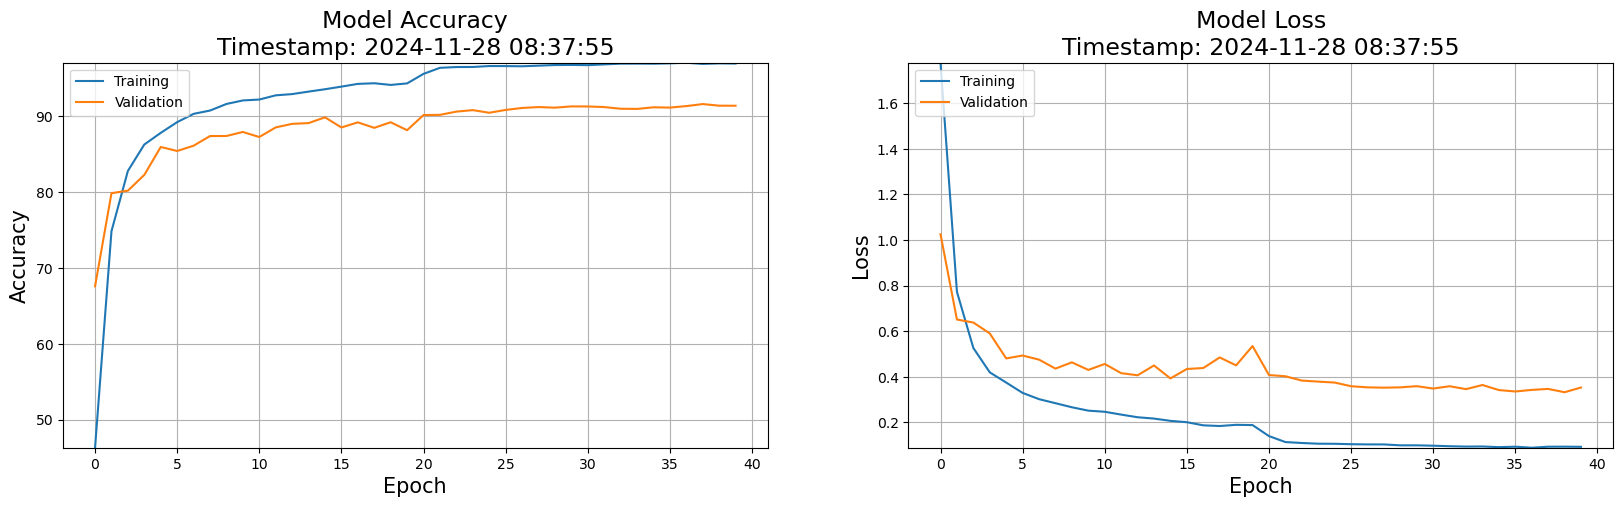

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.3285, Accuracy: 62.25%, Val Loss: 0.6570, Val Accuracy: 79.90%
--------------------
Epoch [2/10], Average Loss: 0.5113, Accuracy: 84.34%, Val Loss: 0.4425, Val Accuracy: 85.99%
--------------------
Epoch [3/10], Average Loss: 0.3608, Accuracy: 88.76%, Val Loss: 0.3715, Val Accuracy: 88.29%
--------------------
Epoch [4/10], Average Loss: 0.2815, Accuracy: 91.15%, Val Loss: 0.3680, Val Accuracy: 88.35%
--------------------
Epoch [5/10], Average Loss: 0.2289, Accuracy: 92.60%, Val Loss: 0.3649, Val Accuracy: 88.65%
--------------------
Epoch [6/10], Average Loss: 0.1950, Accuracy: 93.88%, Val Loss: 0.3292, Val Accuracy: 89.87%
--------------------
Epoch [7/10], Average Loss: 0

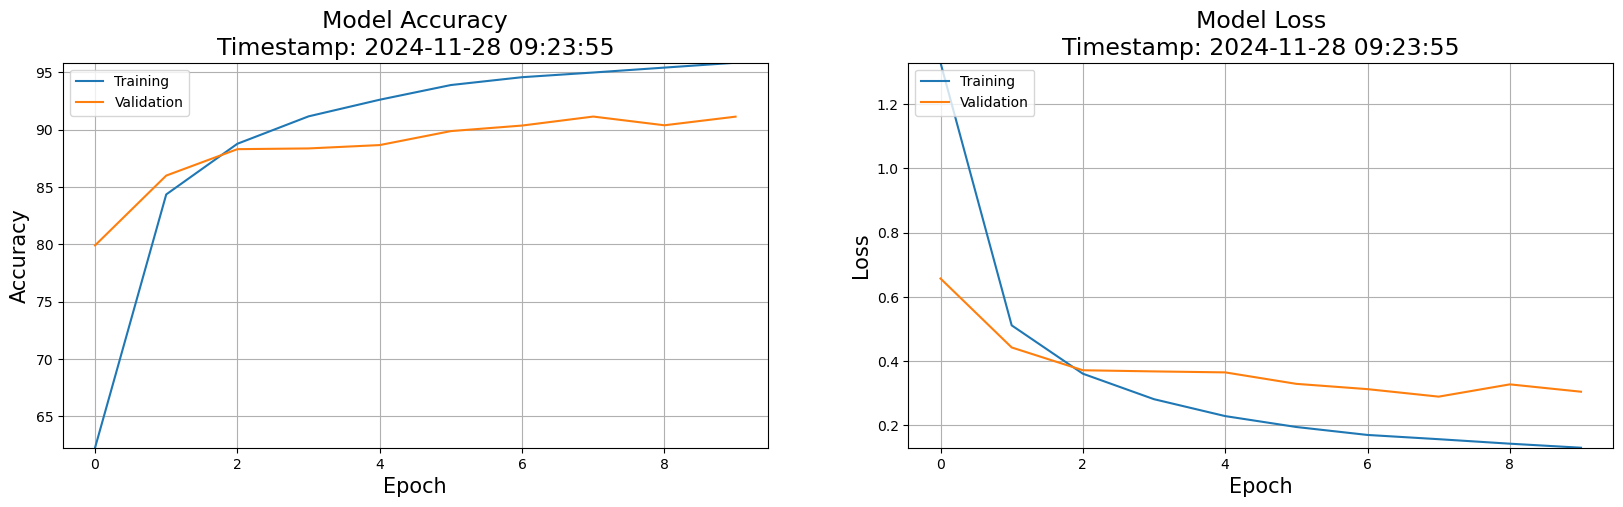

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1274, Accuracy: 95.97%, Val Loss: 0.2670, Val Accuracy: 91.88%
--------------------
Epoch [2/10], Average Loss: 0.1063, Accuracy: 96.57%, Val Loss: 0.2704, Val Accuracy: 91.72%
--------------------
Epoch [3/10], Average Loss: 0.1002, Accuracy: 96.79%, Val Loss: 0.2762, Val Accuracy: 91.98%
--------------------
Epoch [4/10], Average Loss: 0.0985, Accuracy: 96.91%, Val Loss: 0.2498, Val Accuracy: 92.42%
--------------------
Epoch [5/10], Average Loss: 0.0984, Accuracy: 96.93%, Val Loss: 0.2602, Val Accuracy: 92.29%
--------------------
Epoch [6/10], Average Loss: 0.0933, Accuracy: 97.08%, Val Loss: 0.2750, Val Accuracy: 91.39%
--------------------
Epoch [7/10], Average Loss: 0.0959, Accuracy: 96.9

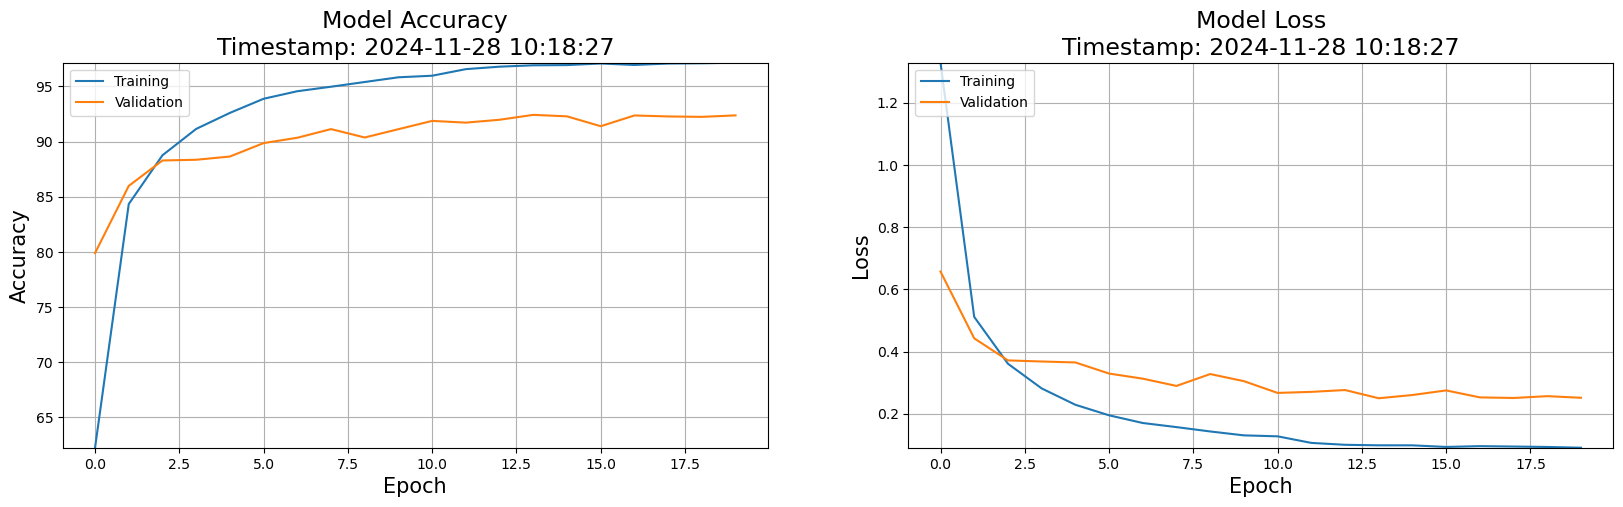

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.3145, Accuracy: 62.37%, Val Loss: 0.6462, Val Accuracy: 80.49%
--------------------
Epoch [2/15], Average Loss: 0.5160, Accuracy: 84.36%, Val Loss: 0.4568, Val Accuracy: 86.04%
--------------------
Epoch [3/15], Average Loss: 0.3594, Accuracy: 88.95%, Val Loss: 0.3737, Val Accuracy: 88.28%
--------------------
Epoch [4/15], Average Loss: 0.2741, Accuracy: 91.29%, Val Loss: 0.3443, Val Accuracy: 89.39%
--------------------
Epoch [5/15], Average Loss: 0.2167, Accuracy: 93.28%, Val Loss: 0.3253, Val Accuracy: 90.04%
--------------------
Epoch [6/15], Average Loss: 0.1886, Accuracy: 93.96%, Val Loss: 0.3065, Val Accuracy: 90.66%
--------------------
Epoch [7/15], Average Loss: 0

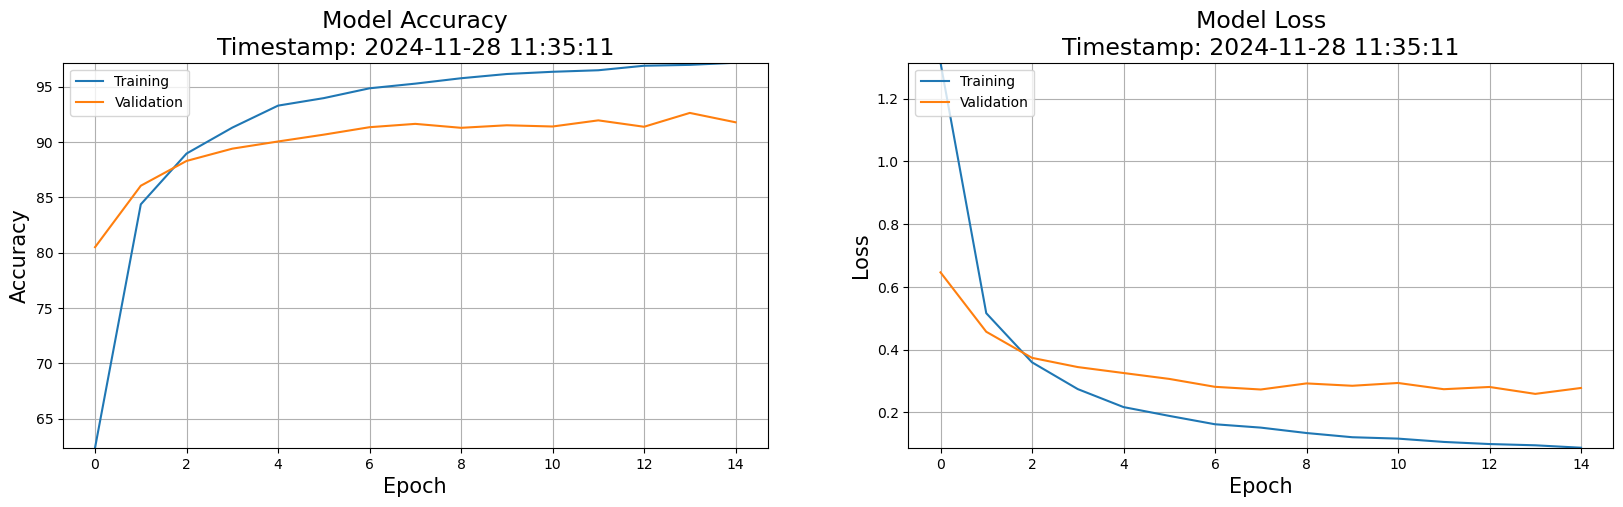

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.0828, Accuracy: 97.33%, Val Loss: 0.2728, Val Accuracy: 92.11%
--------------------
Epoch [2/15], Average Loss: 0.0733, Accuracy: 97.68%, Val Loss: 0.2524, Val Accuracy: 92.65%
--------------------
Epoch [3/15], Average Loss: 0.0729, Accuracy: 97.65%, Val Loss: 0.2618, Val Accuracy: 92.31%
--------------------
Epoch [4/15], Average Loss: 0.0733, Accuracy: 97.69%, Val Loss: 0.2790, Val Accuracy: 91.93%
--------------------
Epoch [5/15], Average Loss: 0.0700, Accuracy: 97.70%, Val Loss: 0.2571, Val Accuracy: 92.26%
--------------------
Epoch [6/15], Average Loss: 0.0664, Accuracy: 97.90%, Val Loss: 0.2490, Val Accuracy: 92.91%
--------------------
Epoch [7/15], Average Loss: 0.0691, Accuracy: 97.8

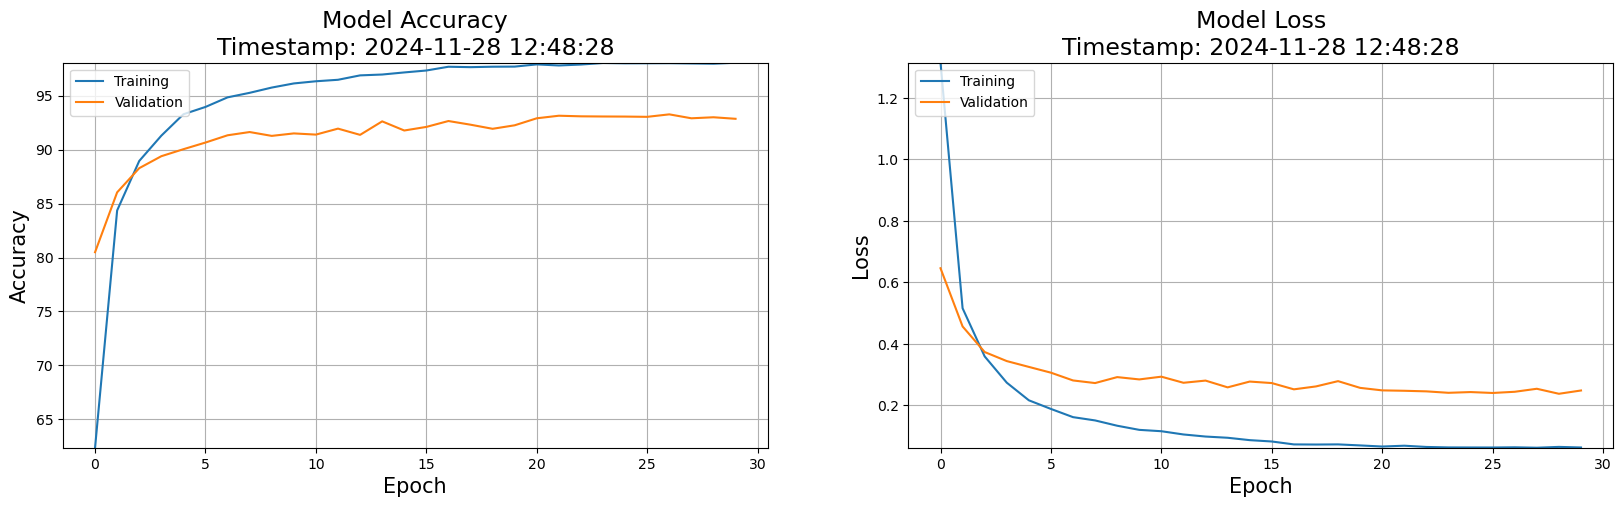

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.3147, Accuracy: 62.35%, Val Loss: 0.6720, Val Accuracy: 79.70%
--------------------
Epoch [2/20], Average Loss: 0.5233, Accuracy: 84.19%, Val Loss: 0.4529, Val Accuracy: 85.84%
--------------------
Epoch [3/20], Average Loss: 0.3661, Accuracy: 88.64%, Val Loss: 0.3955, Val Accuracy: 87.69%
--------------------
Epoch [4/20], Average Loss: 0.2793, Accuracy: 91.19%, Val Loss: 0.3370, Val Accuracy: 89.07%
--------------------
Epoch [5/20], Average Loss: 0.2307, Accuracy: 92.75%, Val Loss: 0.3214, Val Accuracy: 89.71%
--------------------
Epoch [6/20], Average Loss: 0.1993, Accuracy: 93.74%, Val Loss: 0.3204, Val Accuracy: 90.23%
--------------------
Epoch [7/20], Average Loss: 0

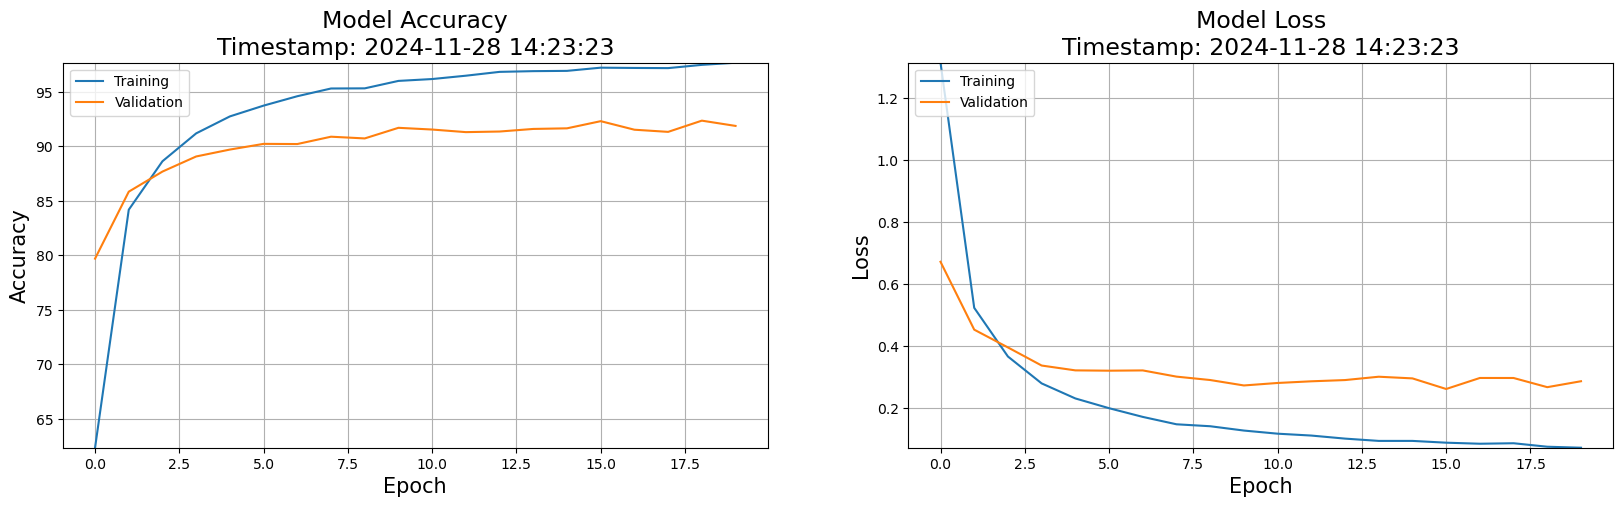

batch_size= 128 ,learning_rate= 0.001 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.0672, Accuracy: 97.82%, Val Loss: 0.2508, Val Accuracy: 93.13%
--------------------
Epoch [2/20], Average Loss: 0.0615, Accuracy: 98.07%, Val Loss: 0.2580, Val Accuracy: 92.88%
--------------------
Epoch [3/20], Average Loss: 0.0578, Accuracy: 98.18%, Val Loss: 0.2443, Val Accuracy: 93.10%
--------------------
Epoch [4/20], Average Loss: 0.0603, Accuracy: 98.11%, Val Loss: 0.2494, Val Accuracy: 92.97%
--------------------
Epoch [5/20], Average Loss: 0.0561, Accuracy: 98.22%, Val Loss: 0.2403, Val Accuracy: 93.03%
--------------------
Epoch [6/20], Average Loss: 0.0558, Accuracy: 98.26%, Val Loss: 0.2451, Val Accuracy: 93.06%
--------------------
Epoch [7/20], Average Loss: 0.0550, Accuracy: 98.2

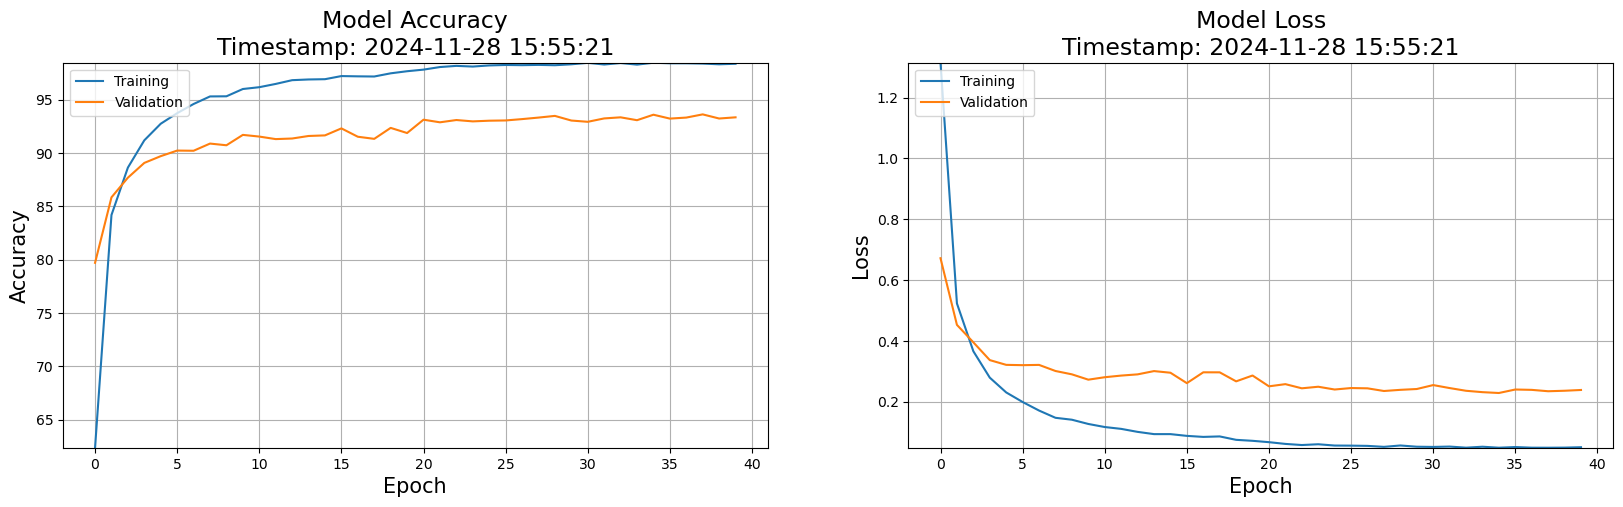

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.4953, Accuracy: 53.71%, Val Loss: 0.8623, Val Accuracy: 73.63%
--------------------
Epoch [2/10], Average Loss: 0.6251, Accuracy: 79.35%, Val Loss: 0.7188, Val Accuracy: 78.12%
--------------------
Epoch [3/10], Average Loss: 0.4246, Accuracy: 86.13%, Val Loss: 0.5221, Val Accuracy: 83.68%
--------------------
Epoch [4/10], Average Loss: 0.3179, Accuracy: 89.48%, Val Loss: 0.4621, Val Accuracy: 86.05%
--------------------
Epoch [5/10], Average Loss: 0.2634, Accuracy: 91.28%, Val Loss: 0.4226, Val Accuracy: 87.36%
--------------------
Epoch [6/10], Average Loss: 0.2297, Accuracy: 92.46%, Val Loss: 0.4141, Val Accuracy: 87.51%
--------------------
Epoch [7/10], Average Loss: 0

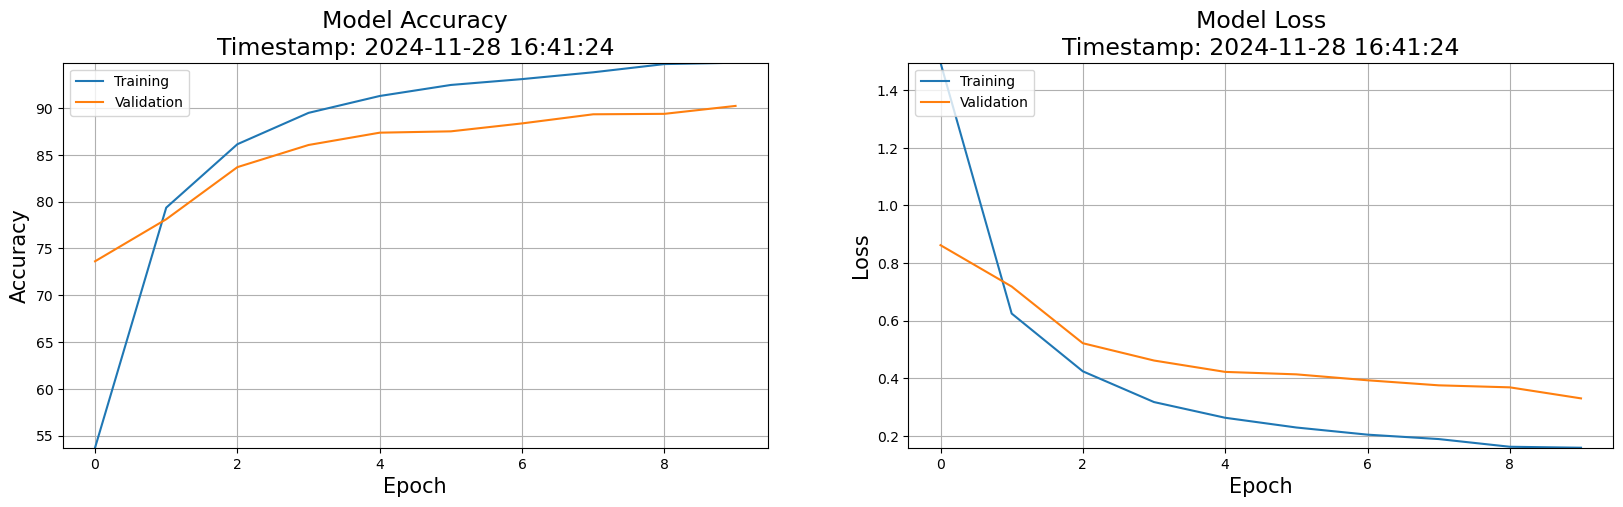

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1266, Accuracy: 95.89%, Val Loss: 0.3400, Val Accuracy: 90.15%
--------------------
Epoch [2/10], Average Loss: 0.1202, Accuracy: 96.07%, Val Loss: 0.3036, Val Accuracy: 91.16%
--------------------
Epoch [3/10], Average Loss: 0.1165, Accuracy: 96.26%, Val Loss: 0.3062, Val Accuracy: 91.05%
--------------------
Epoch [4/10], Average Loss: 0.1093, Accuracy: 96.47%, Val Loss: 0.3001, Val Accuracy: 91.03%
--------------------
Epoch [5/10], Average Loss: 0.1068, Accuracy: 96.62%, Val Loss: 0.3053, Val Accuracy: 91.26%
--------------------
Epoch [6/10], Average Loss: 0.1076, Accuracy: 96.48%, Val Loss: 0.2977, Val Accuracy: 91.51%
--------------------
Epoch [7/10], Average Loss: 0.1040, Accuracy: 96.6

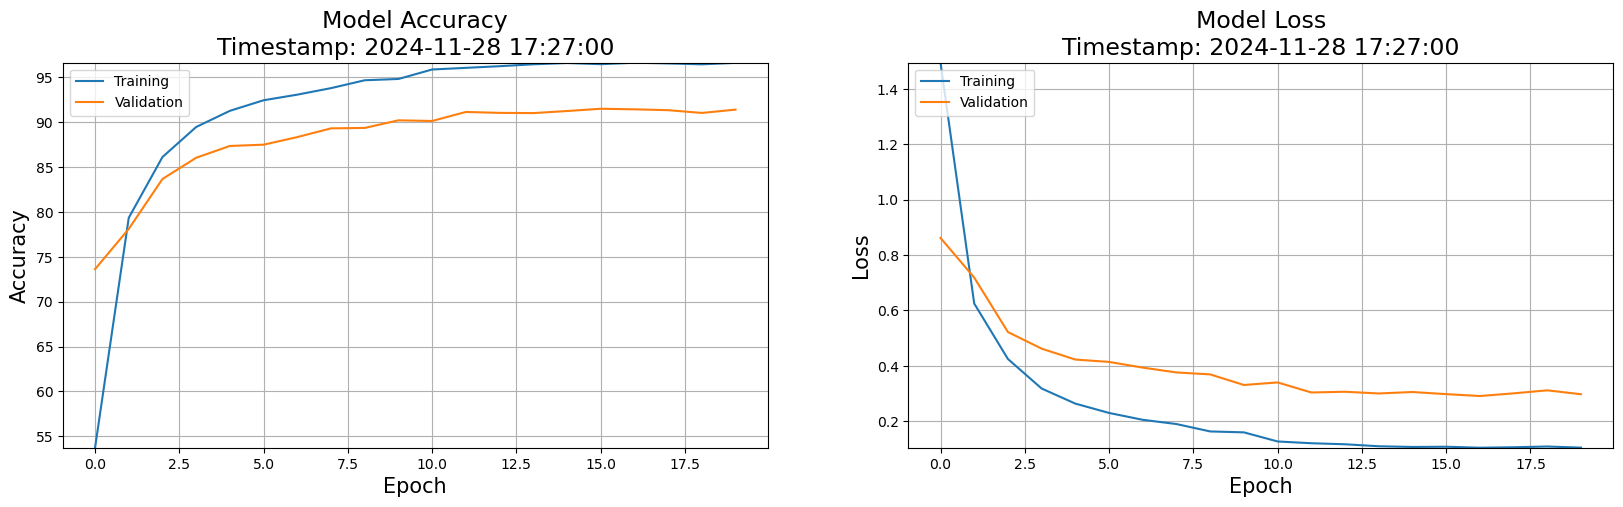

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.4764, Accuracy: 55.30%, Val Loss: 0.8769, Val Accuracy: 71.62%
--------------------
Epoch [2/15], Average Loss: 0.5904, Accuracy: 80.88%, Val Loss: 0.5409, Val Accuracy: 83.28%
--------------------
Epoch [3/15], Average Loss: 0.3865, Accuracy: 87.15%, Val Loss: 0.4644, Val Accuracy: 85.64%
--------------------
Epoch [4/15], Average Loss: 0.3005, Accuracy: 90.12%, Val Loss: 0.3909, Val Accuracy: 87.95%
--------------------
Epoch [5/15], Average Loss: 0.2505, Accuracy: 91.92%, Val Loss: 0.3966, Val Accuracy: 87.94%
--------------------
Epoch [6/15], Average Loss: 0.2270, Accuracy: 92.59%, Val Loss: 0.3710, Val Accuracy: 88.95%
--------------------
Epoch [7/15], Average Loss: 0

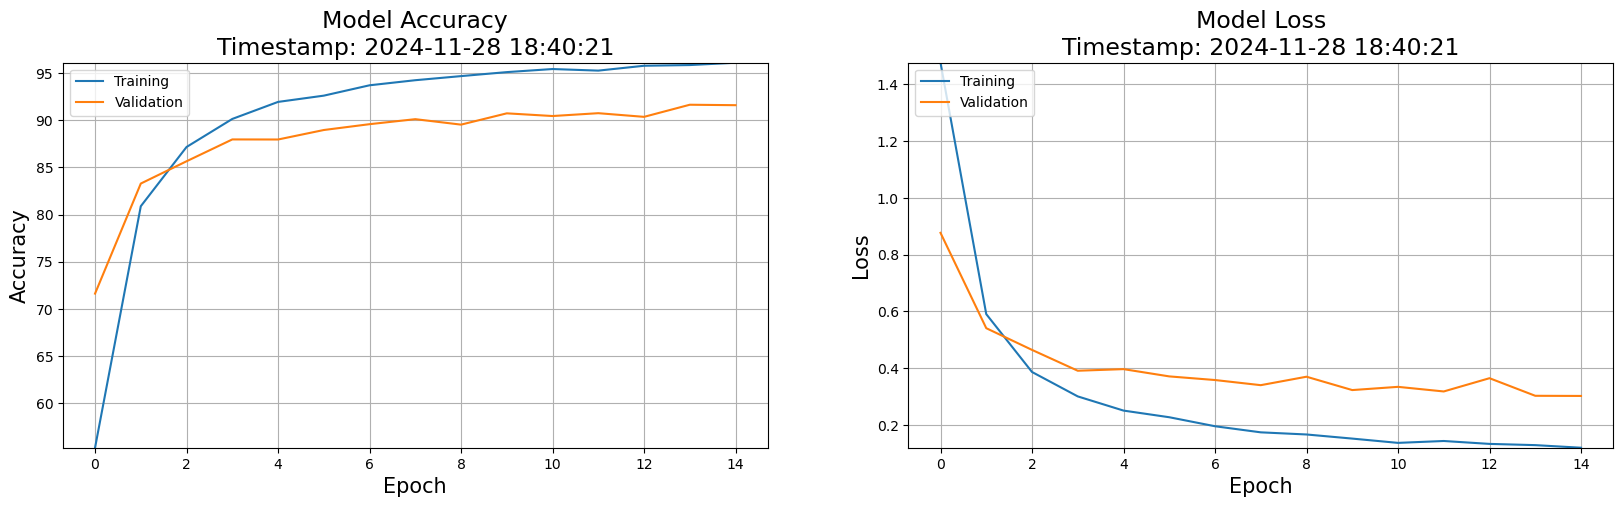

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.0929, Accuracy: 96.80%, Val Loss: 0.3146, Val Accuracy: 91.78%
--------------------
Epoch [2/15], Average Loss: 0.0875, Accuracy: 97.18%, Val Loss: 0.2883, Val Accuracy: 92.27%
--------------------
Epoch [3/15], Average Loss: 0.0837, Accuracy: 97.24%, Val Loss: 0.3013, Val Accuracy: 91.39%
--------------------
Epoch [4/15], Average Loss: 0.0805, Accuracy: 97.34%, Val Loss: 0.3164, Val Accuracy: 91.43%
--------------------
Epoch [5/15], Average Loss: 0.0807, Accuracy: 97.31%, Val Loss: 0.2963, Val Accuracy: 92.04%
--------------------
Epoch [6/15], Average Loss: 0.0763, Accuracy: 97.46%, Val Loss: 0.2981, Val Accuracy: 91.86%
--------------------
Epoch [7/15], Average Loss: 0.0767, Accuracy: 97.5

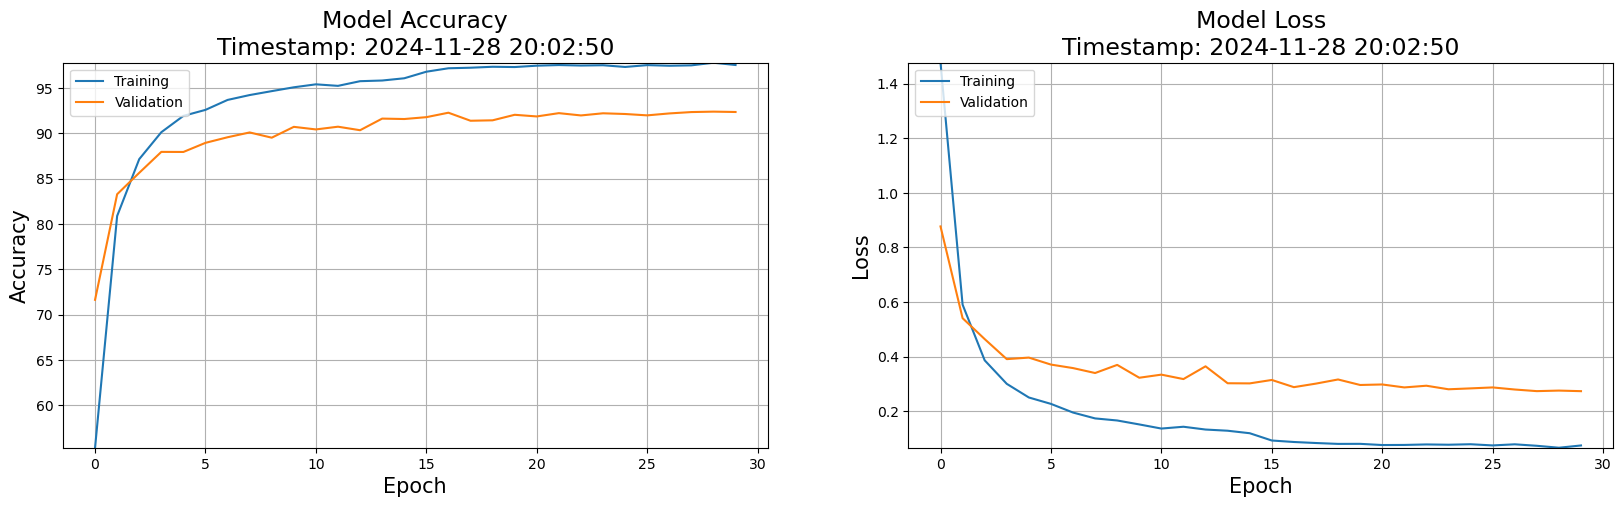

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.5214, Accuracy: 52.96%, Val Loss: 0.8690, Val Accuracy: 71.80%
--------------------
Epoch [2/20], Average Loss: 0.6000, Accuracy: 80.27%, Val Loss: 0.5064, Val Accuracy: 83.59%
--------------------
Epoch [3/20], Average Loss: 0.3827, Accuracy: 87.49%, Val Loss: 0.4675, Val Accuracy: 85.36%
--------------------
Epoch [4/20], Average Loss: 0.2958, Accuracy: 90.38%, Val Loss: 0.3634, Val Accuracy: 88.68%
--------------------
Epoch [5/20], Average Loss: 0.2413, Accuracy: 92.15%, Val Loss: 0.4058, Val Accuracy: 87.56%
--------------------
Epoch [6/20], Average Loss: 0.2178, Accuracy: 92.89%, Val Loss: 0.3610, Val Accuracy: 89.14%
--------------------
Epoch [7/20], Average Loss: 0

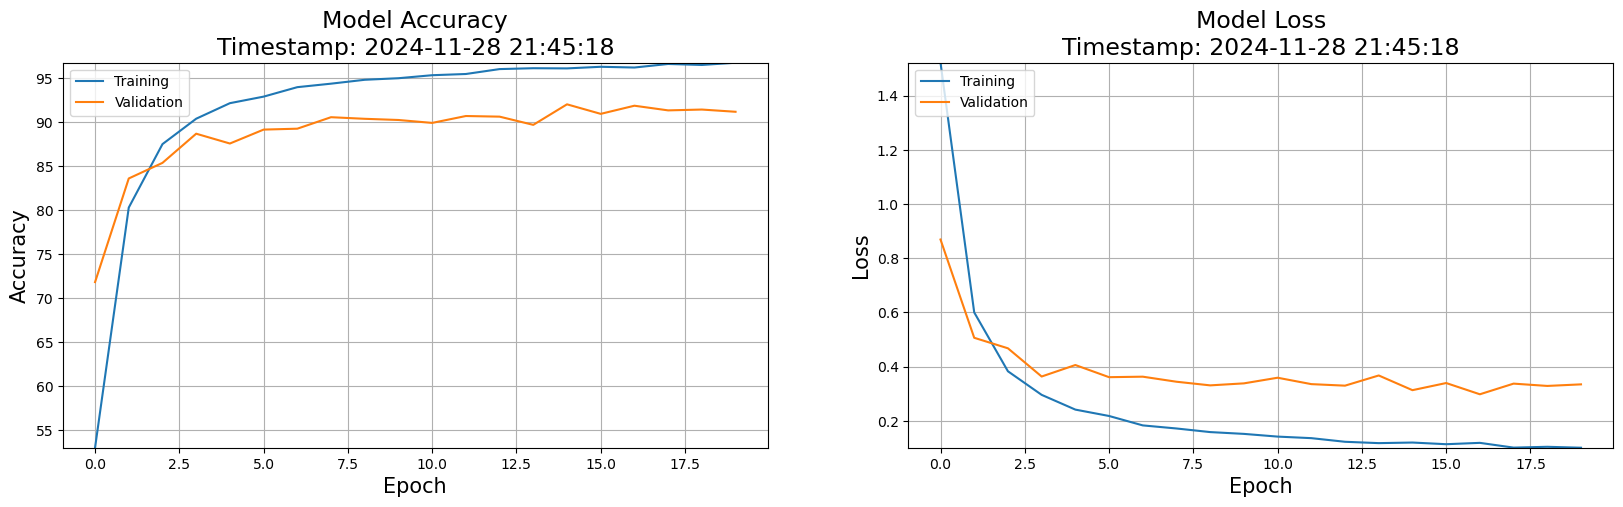

batch_size= 128 ,learning_rate= 0.005 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.0797, Accuracy: 97.32%, Val Loss: 0.2838, Val Accuracy: 92.41%
--------------------
Epoch [2/20], Average Loss: 0.0712, Accuracy: 97.65%, Val Loss: 0.2757, Val Accuracy: 92.74%
--------------------
Epoch [3/20], Average Loss: 0.0709, Accuracy: 97.68%, Val Loss: 0.2974, Val Accuracy: 92.15%
--------------------
Epoch [4/20], Average Loss: 0.0689, Accuracy: 97.77%, Val Loss: 0.2583, Val Accuracy: 93.09%
--------------------
Epoch [5/20], Average Loss: 0.0698, Accuracy: 97.64%, Val Loss: 0.2633, Val Accuracy: 92.76%
--------------------
Epoch [6/20], Average Loss: 0.0638, Accuracy: 97.91%, Val Loss: 0.2628, Val Accuracy: 92.76%
--------------------
Epoch [7/20], Average Loss: 0.0646, Accuracy: 97.8

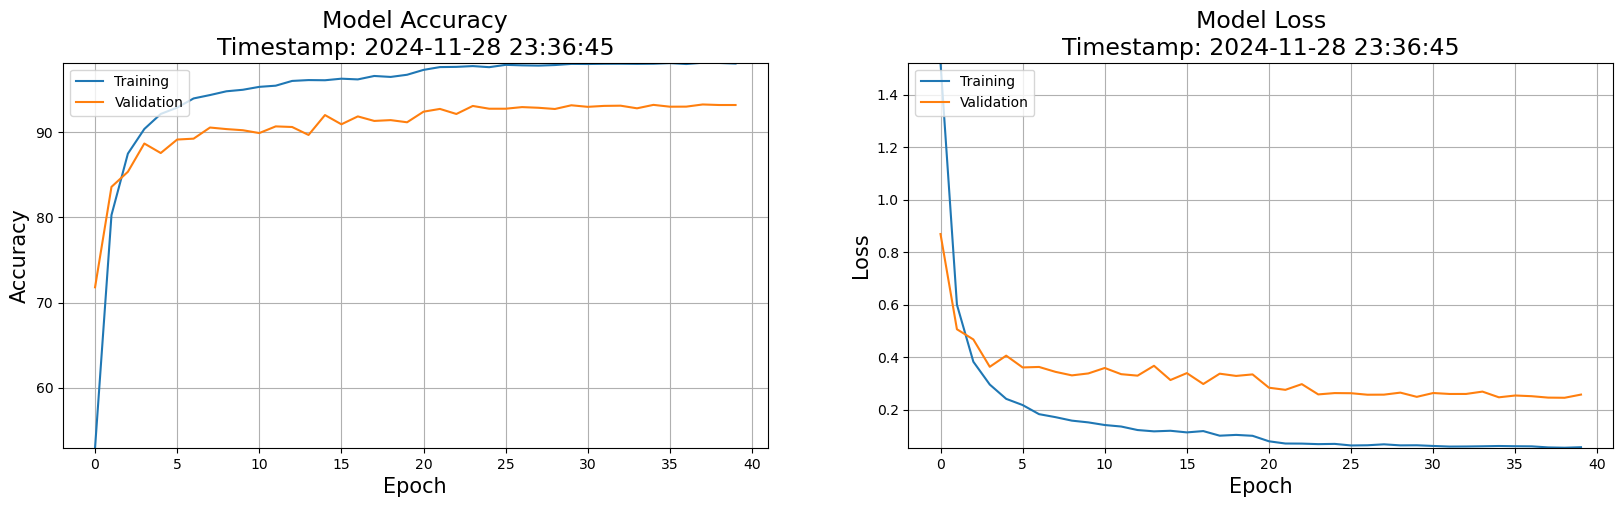

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/10], Average Loss: 1.8328, Accuracy: 43.74%, Val Loss: 1.2550, Val Accuracy: 60.50%
--------------------
Epoch [2/10], Average Loss: 0.8746, Accuracy: 71.24%, Val Loss: 0.7573, Val Accuracy: 75.99%
--------------------
Epoch [3/10], Average Loss: 0.5178, Accuracy: 83.03%, Val Loss: 0.5819, Val Accuracy: 81.58%
--------------------
Epoch [4/10], Average Loss: 0.3966, Accuracy: 86.77%, Val Loss: 0.5495, Val Accuracy: 83.77%
--------------------
Epoch [5/10], Average Loss: 0.3236, Accuracy: 89.34%, Val Loss: 0.4448, Val Accuracy: 86.70%
--------------------
Epoch [6/10], Average Loss: 0.2915, Accuracy: 90.50%, Val Loss: 0.4429, Val Accuracy: 86.83%
--------------------
Epoch [7/10], Average Loss: 0.2

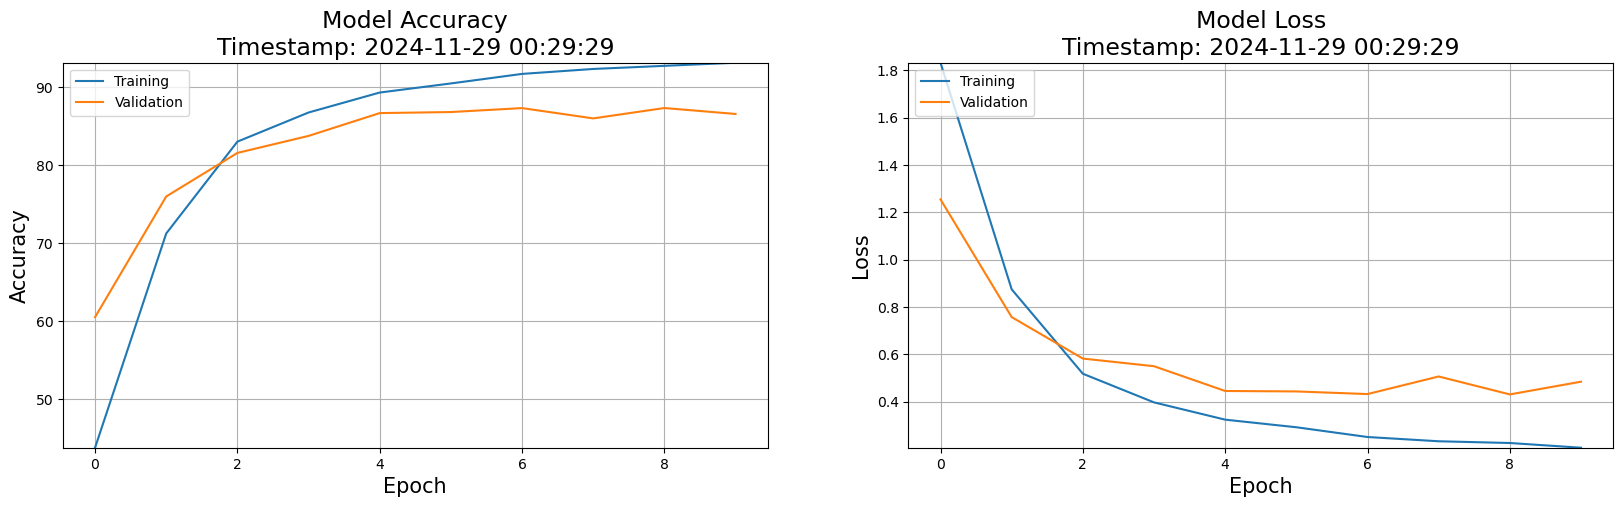

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 10 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/10], Average Loss: 0.1652, Accuracy: 94.62%, Val Loss: 0.3719, Val Accuracy: 89.37%
--------------------
Epoch [2/10], Average Loss: 0.1473, Accuracy: 95.15%, Val Loss: 0.3696, Val Accuracy: 89.22%
--------------------
Epoch [3/10], Average Loss: 0.1413, Accuracy: 95.34%, Val Loss: 0.3671, Val Accuracy: 89.59%
--------------------
Epoch [4/10], Average Loss: 0.1382, Accuracy: 95.36%, Val Loss: 0.3635, Val Accuracy: 89.71%
--------------------
Epoch [5/10], Average Loss: 0.1391, Accuracy: 95.46%, Val Loss: 0.3537, Val Accuracy: 90.11%
--------------------
Epoch [6/10], Average Loss: 0.1309, Accuracy: 95.74%, Val Loss: 0.3445, Val Accuracy: 90.05%
--------------------
Epoch [7/10], Average Loss: 0.1273, Accuracy: 95.80%

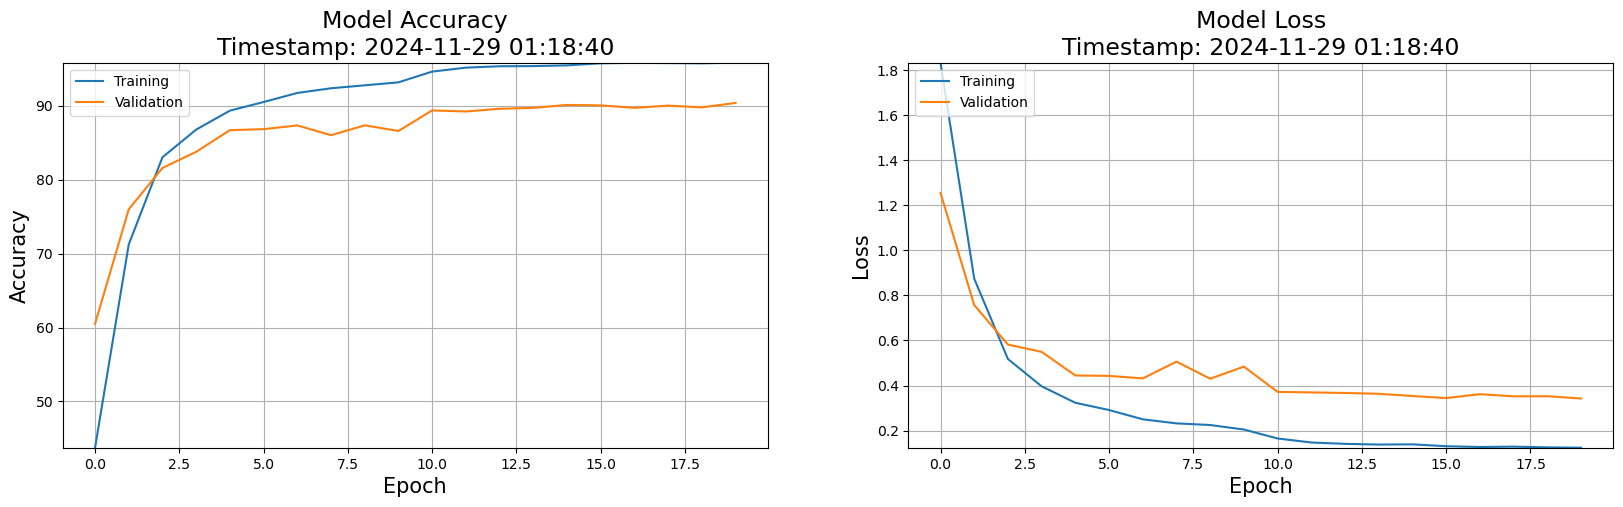

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/15], Average Loss: 1.8697, Accuracy: 43.02%, Val Loss: 1.2136, Val Accuracy: 60.39%
--------------------
Epoch [2/15], Average Loss: 0.8349, Accuracy: 72.69%, Val Loss: 0.7012, Val Accuracy: 77.49%
--------------------
Epoch [3/15], Average Loss: 0.5203, Accuracy: 82.76%, Val Loss: 0.5229, Val Accuracy: 83.57%
--------------------
Epoch [4/15], Average Loss: 0.3876, Accuracy: 87.17%, Val Loss: 0.4710, Val Accuracy: 85.17%
--------------------
Epoch [5/15], Average Loss: 0.3263, Accuracy: 89.25%, Val Loss: 0.4668, Val Accuracy: 85.73%
--------------------
Epoch [6/15], Average Loss: 0.2784, Accuracy: 90.81%, Val Loss: 0.4828, Val Accuracy: 85.89%
--------------------
Epoch [7/15], Average Loss: 0.2

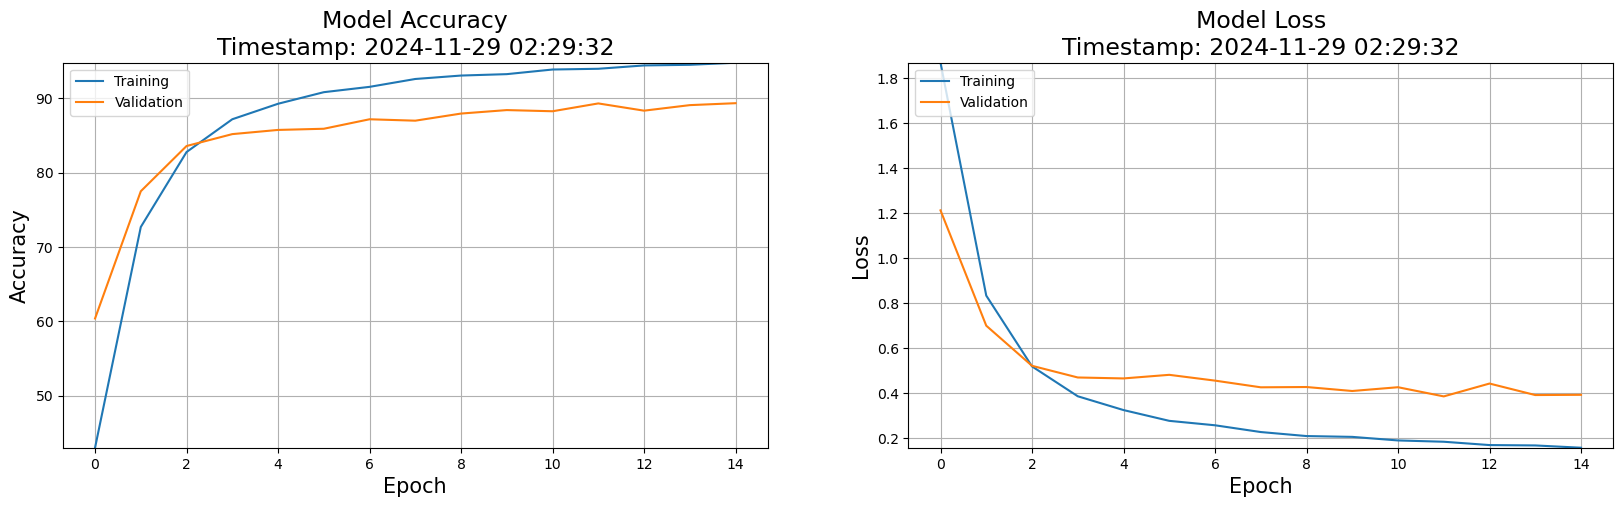

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 15 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/15], Average Loss: 0.1237, Accuracy: 95.94%, Val Loss: 0.3526, Val Accuracy: 90.32%
--------------------
Epoch [2/15], Average Loss: 0.1111, Accuracy: 96.39%, Val Loss: 0.3371, Val Accuracy: 90.99%
--------------------
Epoch [3/15], Average Loss: 0.1073, Accuracy: 96.48%, Val Loss: 0.3464, Val Accuracy: 90.36%
--------------------
Epoch [4/15], Average Loss: 0.1048, Accuracy: 96.58%, Val Loss: 0.3337, Val Accuracy: 90.79%
--------------------
Epoch [5/15], Average Loss: 0.1027, Accuracy: 96.67%, Val Loss: 0.3368, Val Accuracy: 90.93%
--------------------
Epoch [6/15], Average Loss: 0.1024, Accuracy: 96.67%, Val Loss: 0.3219, Val Accuracy: 91.17%
--------------------
Epoch [7/15], Average Loss: 0.1026, Accuracy: 96.71%

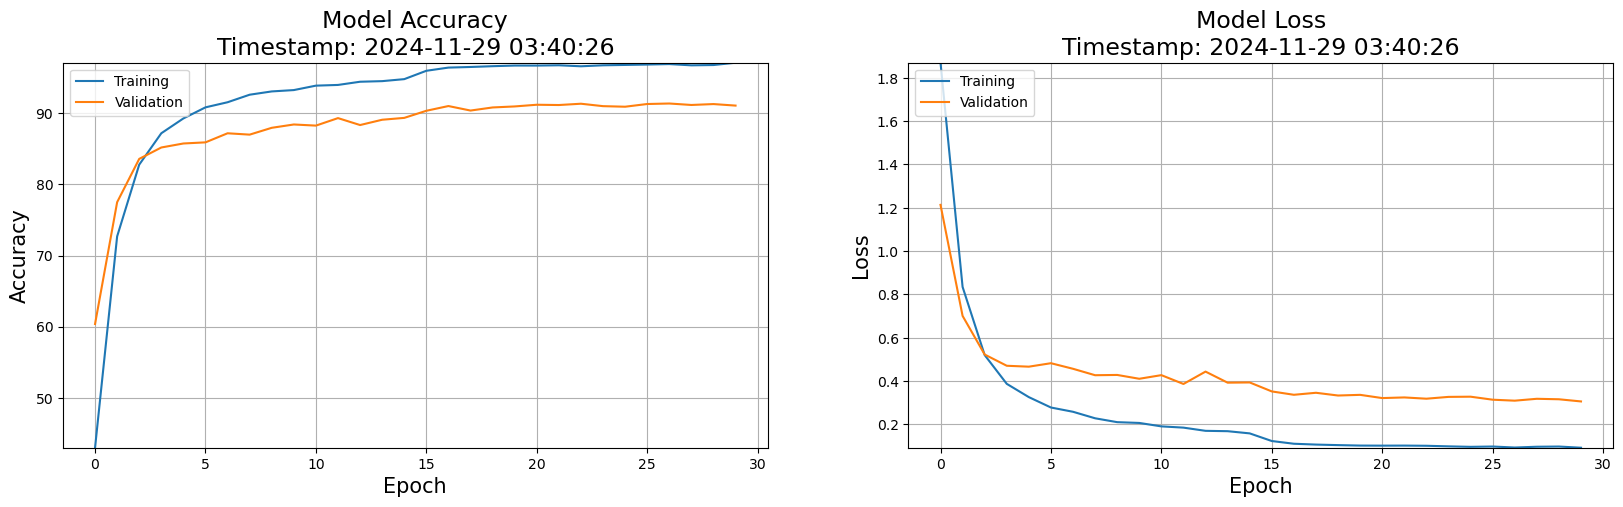

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Epoch [1/20], Average Loss: 1.6252, Accuracy: 51.17%, Val Loss: 1.0358, Val Accuracy: 67.41%
--------------------
Epoch [2/20], Average Loss: 0.7035, Accuracy: 77.11%, Val Loss: 0.6743, Val Accuracy: 79.20%
--------------------
Epoch [3/20], Average Loss: 0.4823, Accuracy: 84.31%, Val Loss: 0.5831, Val Accuracy: 82.27%
--------------------
Epoch [4/20], Average Loss: 0.3901, Accuracy: 87.09%, Val Loss: 0.5555, Val Accuracy: 83.30%
--------------------
Epoch [5/20], Average Loss: 0.3191, Accuracy: 89.67%, Val Loss: 0.4737, Val Accuracy: 85.42%
--------------------
Epoch [6/20], Average Loss: 0.2760, Accuracy: 90.73%, Val Loss: 0.4521, Val Accuracy: 86.88%
--------------------
Epoch [7/20], Average Loss: 0.2

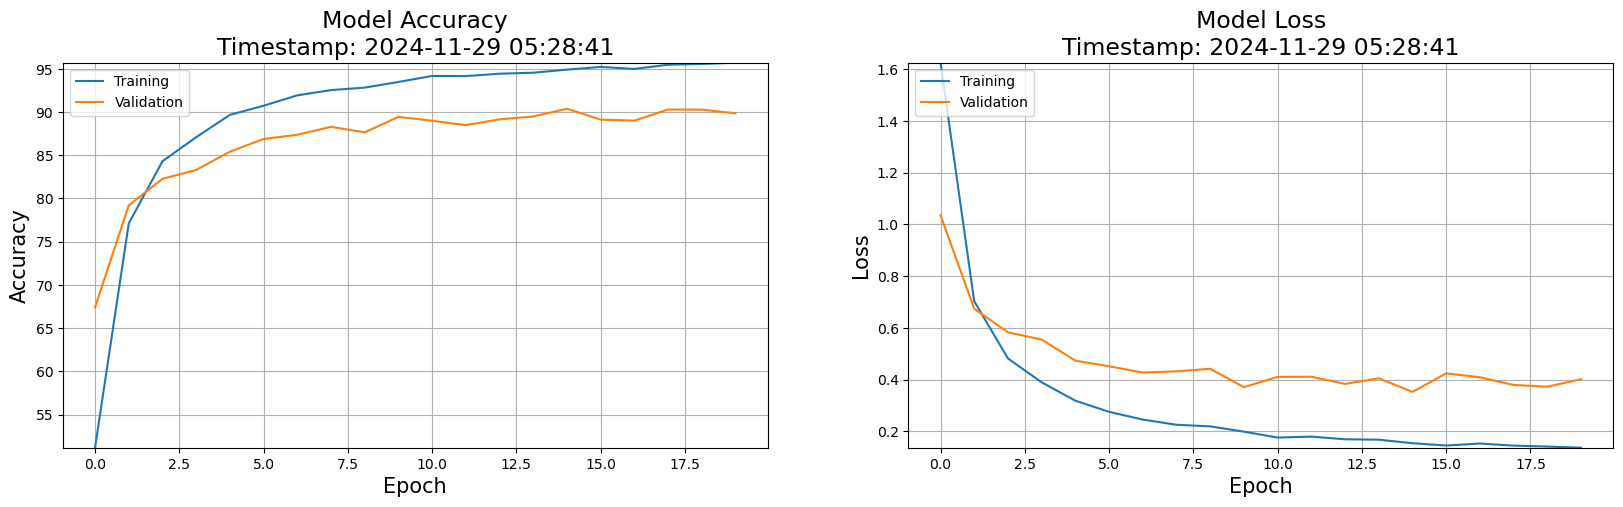

batch_size= 128 ,learning_rate= 0.01 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20], Average Loss: 0.1099, Accuracy: 96.39%, Val Loss: 0.3847, Val Accuracy: 90.77%
--------------------
Epoch [2/20], Average Loss: 0.0973, Accuracy: 96.78%, Val Loss: 0.3440, Val Accuracy: 91.40%
--------------------
Epoch [3/20], Average Loss: 0.0938, Accuracy: 96.97%, Val Loss: 0.3543, Val Accuracy: 91.21%
--------------------
Epoch [4/20], Average Loss: 0.0912, Accuracy: 97.08%, Val Loss: 0.3447, Val Accuracy: 91.32%
--------------------
Epoch [5/20], Average Loss: 0.0885, Accuracy: 97.12%, Val Loss: 0.3361, Val Accuracy: 91.72%
--------------------
Epoch [6/20], Average Loss: 0.0871, Accuracy: 97.07%, Val Loss: 0.3265, Val Accuracy: 91.50%
--------------------
Epoch [7/20], Average Loss: 0.0834, Accuracy: 97.32%

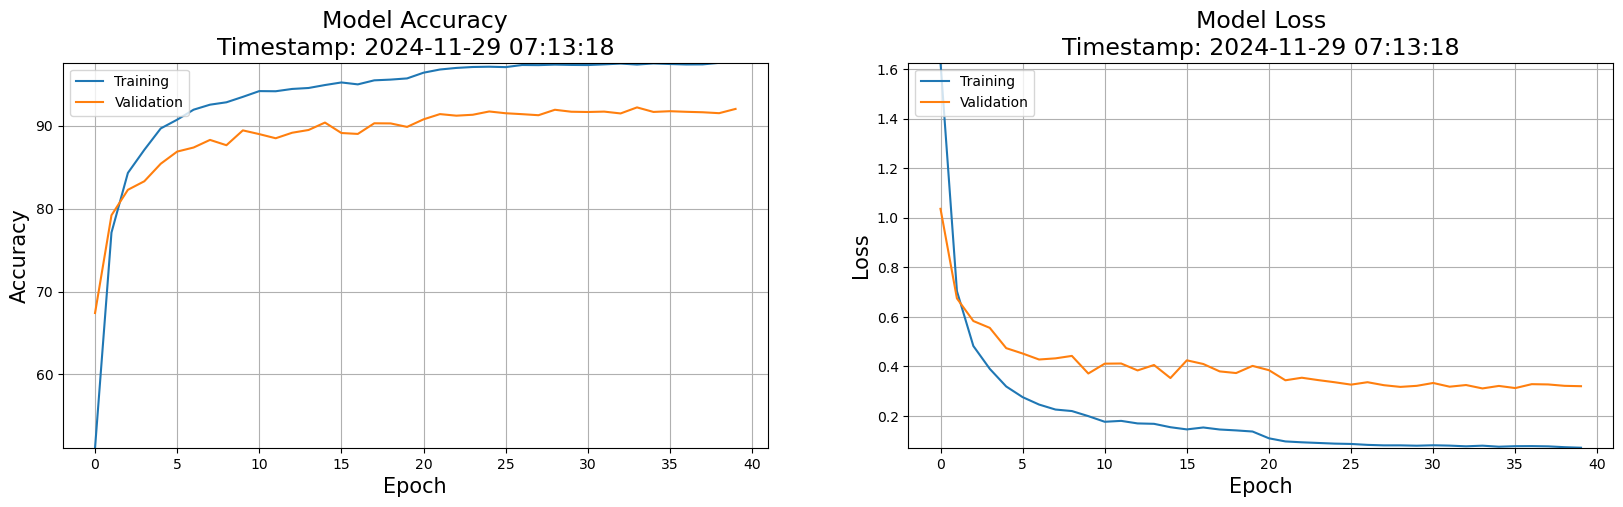

In [31]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epochs in num_epochs_list:
            train_dataset = GTSRBDataset(train_df, cur_path, train=True)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataset = GTSRBDataset(test_df, cur_path)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            model = LeNet5_extend(num_classes)
            optimizers = [
                torch.optim.Adam(model.parameters(), lr=learning_rate),
                torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
            ]
            total_step = len(train_loader)
            for optimizer_ in optimizers:
                optimizer = optimizer_
                history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
                print("batch_size=",batch_size,",learning_rate=",learning_rate, ",num_epochs=", num_epochs, ",optimizer=", optimizer)
                for epoch in range(num_epochs):
                    running_loss = 0.0
                    correct_train = 0
                    total_train = 0
                    for i, (images, labels) in enumerate(train_loader):#tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
                
                        images = images.to(device)
                        labels = labels.to(device)
                
                        optimizer.zero_grad()
                        
                        outputs = model(images)
                        loss = cost(outputs, labels)
                
                        
                        loss.backward()
                        optimizer.step()
                
                        running_loss += loss.item()
                
                        _, predicted = torch.max(outputs.data, 1) # Находим индекс класса с наибольшей вероятностью
                        total_train += labels.size(0)
                        correct_train += (predicted == labels).sum().item()
                        
                        #if (i+1) % 300 == 0:
                        #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                            #running_loss = 0.0
                    average_loss = running_loss / len(train_loader)
                    train_loss = average_loss
                    train_accuracy = 100 * correct_train / total_train
                
                    with torch.no_grad():
                        correct = 0
                        total = 0
                        running_val_loss = 0.0
                        for j, (images, labels) in enumerate(test_loader):
                                images = images.to(device)
                                labels = labels.to(device)
                                outputs = model(images)
                    
                                loss = cost(outputs, labels)
                                running_val_loss += loss.item()
                            
                                _, predicted = torch.max(outputs.data, 1)
                                total += labels.size(0)
                                correct += (predicted == labels).sum().item()
                        val_accuracy = 100 * correct / total
                        val_loss = running_val_loss / len(test_loader)
                
                    history['loss'].append(train_loss)
                    history['accuracy'].append(train_accuracy)
                    history['val_loss'].append(val_loss)
                    history['val_accuracy'].append(val_accuracy)
                    
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
                    print("-" * 20)
                plot_performance(history=history)